In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from pipeline_config import (
    dataloaders_conf,
    aug_config,
    train_conf,
    model_config, 
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [ ]:
from exp_config import data_conf

## Prepare train, validation and test data

In [ ]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:00, 726.58it/s]
100%|██████████| 720/720 [00:07<00:00, 91.03it/s] 
8280it [00:00, 97265.22it/s]
7920it [00:00, 228671.55it/s]
720it [00:00, 747.20it/s]
100%|██████████| 720/720 [00:07<00:00, 91.17it/s] 
8280it [00:00, 242389.48it/s]
720it [00:00, 771.05it/s]
100%|██████████| 720/720 [00:07<00:00, 90.06it/s] 
8280it [00:00, 246396.43it/s]
700it [00:00, 796.91it/s]
100%|██████████| 700/700 [00:07<00:00, 95.91it/s] 
8280it [00:00, 243724.82it/s]
509it [00:00, 1166.93it/s]
100%|██████████| 509/509 [00:02<00:00, 188.87it/s]
3664it [00:00, 235062.71it/s]
700it [00:00, 821.47it/s]
100%|██████████| 700/700 [00:07<00:00, 97.88it/s] 
8280it [00:00, 231309.69it/s]
700it [00:00, 813.99it/s]
100%|██████████| 700/700 [00:07<00:00, 96.84it/s] 
8280it [00:00, 233480.59it/s]
710it [00:01, 376.23it/s]
100%|██████████| 710/710 [00:07<00:00, 94.14it/s] 
8280it [00:00, 241583.51it/s]
710it [00:01, 394.62it/s]
100%|██████████| 710/710 [00:07<00:00, 94.22it/s] 
8280it [00:00, 233691.12it/s]
710it [

In [ ]:
len(data_train), len(data_val), len(data_test)

In [ ]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [ ]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [ ]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [ ]:
device = 'cuda:1'

In [ ]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

## Dump experiment results

In [67]:
import pickle
import json

In [16]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'wb') as f:
#     pickle.dump(results, f)

In [68]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [15]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))
model = model.to('cpu').to(device)

## Train and validation losses

In [18]:
from itertools import chain

In [19]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [20]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

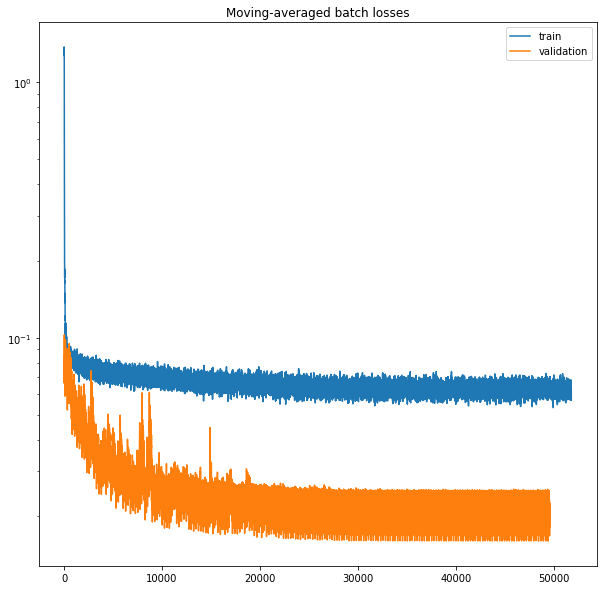

In [21]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [22]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

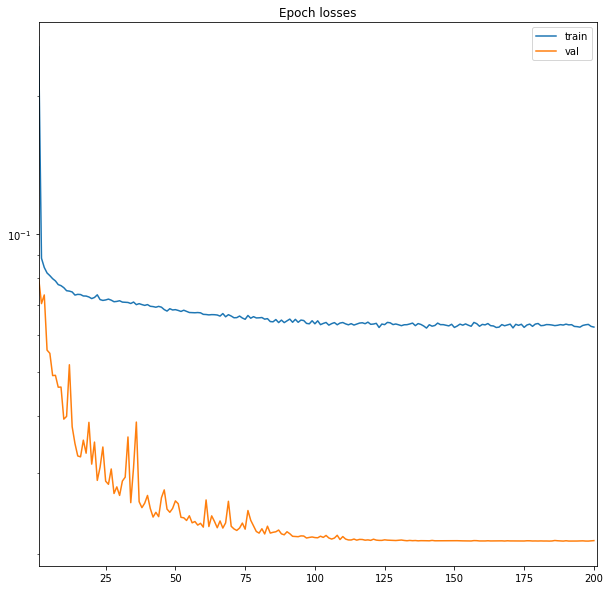

In [23]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Predicted samples

In [15]:
import os

In [16]:
import torch

In [17]:
from visualization_utils import output_to_binary, plot_sample

In [18]:
threshold = 0.5
to_plot = 10
# device = model_conf['device']

In [19]:
device

'cuda:1'

In [22]:
samples.shape

(32, 1, 128, 128)

In [26]:
pred[:, 0, 0]

array([-0.05529951, -0.05408851], dtype=float32)

In [28]:
from visualization_utils import output_to_binary

In [33]:
a = output_to_binary(pred, threshold=0.6)

In [35]:
sample

array([[[ 2.6713026e-01,  2.0805198e-01,  2.6713026e-01, ...,
         -7.3720062e-01, -4.1226998e-01, -2.9411340e-01],
        [ 2.6713026e-01,  2.6713026e-01,  2.6713026e-01, ...,
         -4.7134838e-01, -3.2365254e-01, -5.0088751e-01],
        [-1.1687857e-01,  8.9895420e-02,  1.2779955e-03, ...,
         -3.2365254e-01, -4.7134838e-01, -6.7812234e-01],
        ...,
        [-2.6457426e-01, -9.1443545e-01, -1.5347575e+00, ...,
         -2.3027751e+00, -2.3027751e+00, -2.3027751e+00],
        [-5.3042662e-01, -1.0030528e+00, -1.5052184e+00, ...,
         -2.2436969e+00, -2.3027751e+00, -2.3027751e+00],
        [-1.3279834e+00, -1.2098268e+00, -1.2098268e+00, ...,
         -1.6529140e+00, -1.6824533e+00, -2.0960011e+00]]], dtype=float32)

carb96558


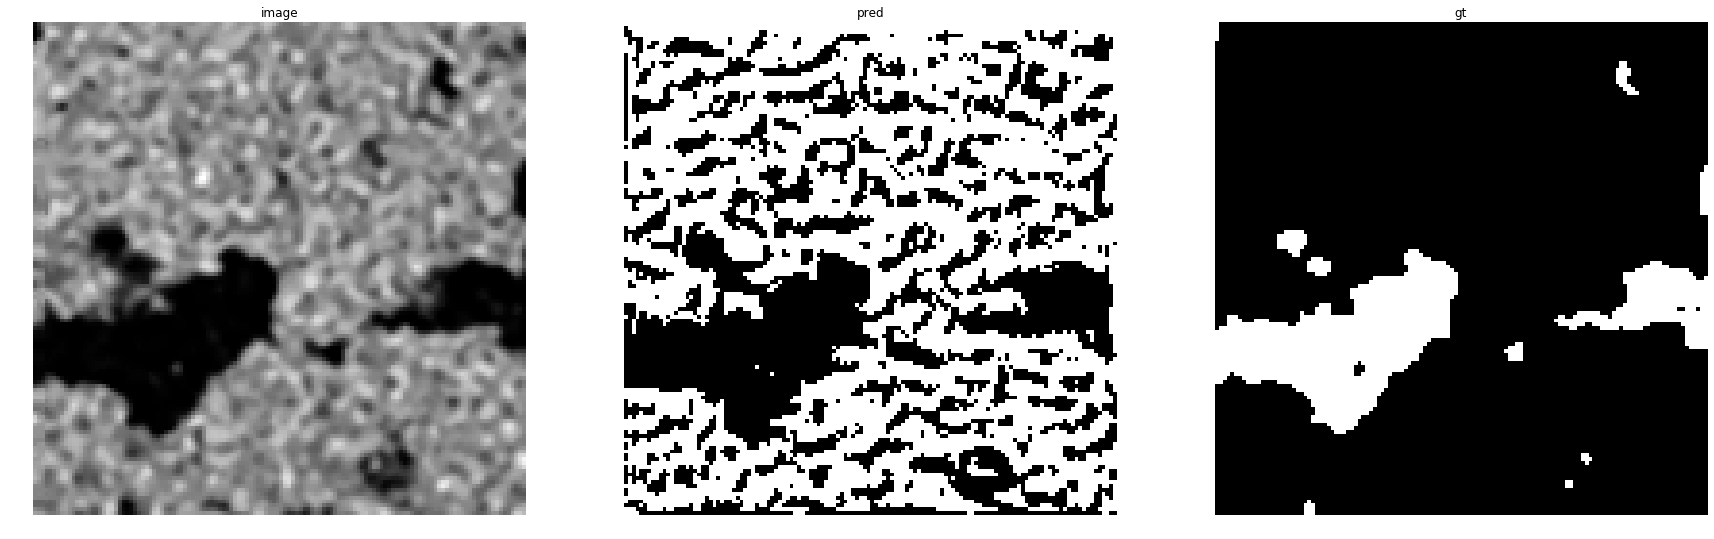

accuracy    : 0.2940673828125
precision   : 0.010650281618023553
recall      : 0.051767048282727726
f1          : 0.01766604382537795
pr_auc      : 0.06680052523196821
iou         : 0.008911739502999142


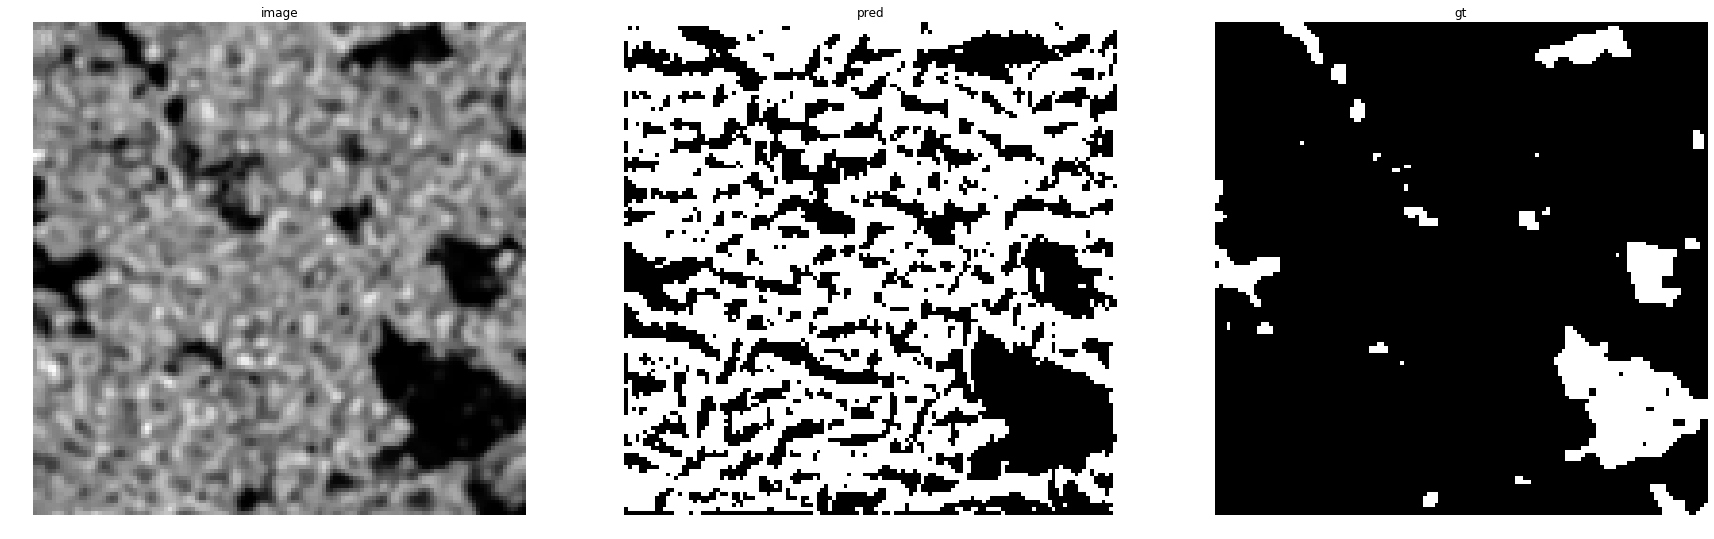

accuracy    : 0.29998779296875
precision   : 0.00924014548314165
recall      : 0.06334231805929919
f1          : 0.01612764862314489
pr_auc      : 0.0486477060426488
iou         : 0.008129378189051285


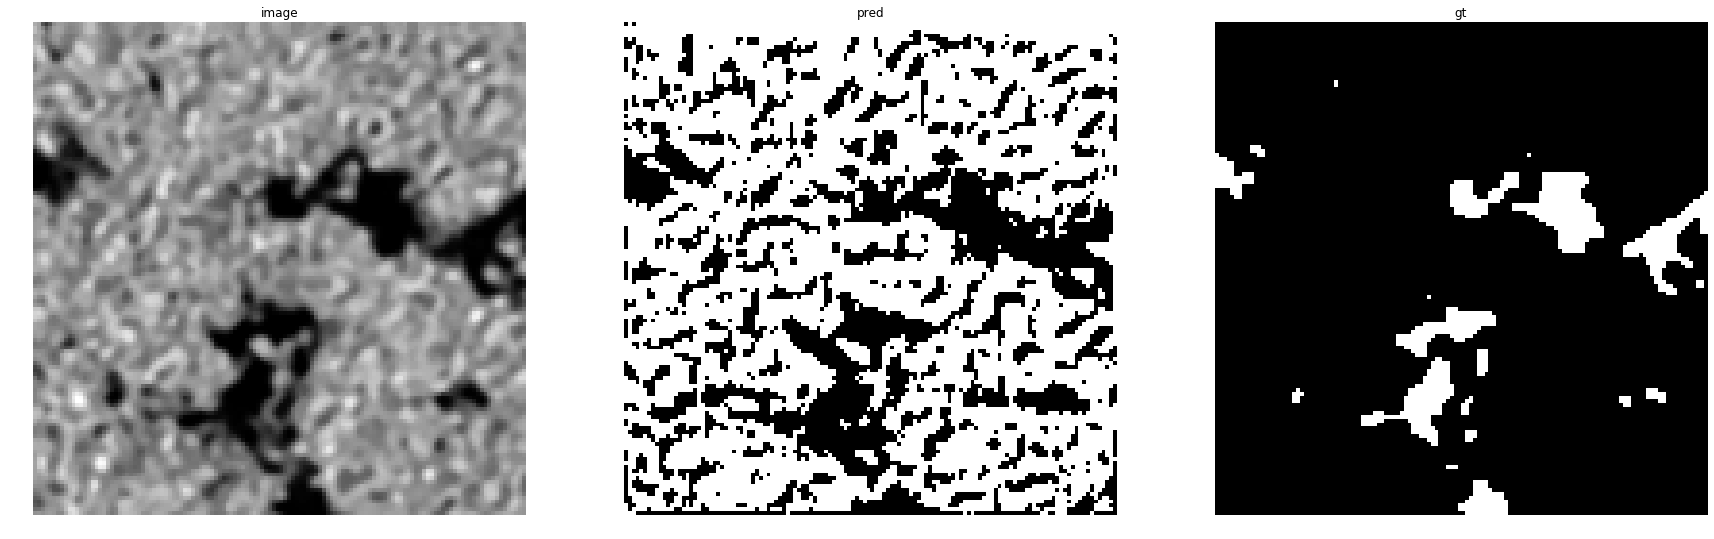

accuracy    : 0.28448486328125
precision   : 0.010167298271559294
recall      : 0.09786476868327403
f1          : 0.018420832286695134
pr_auc      : 0.03689406792916919
iou         : 0.00929603650807065


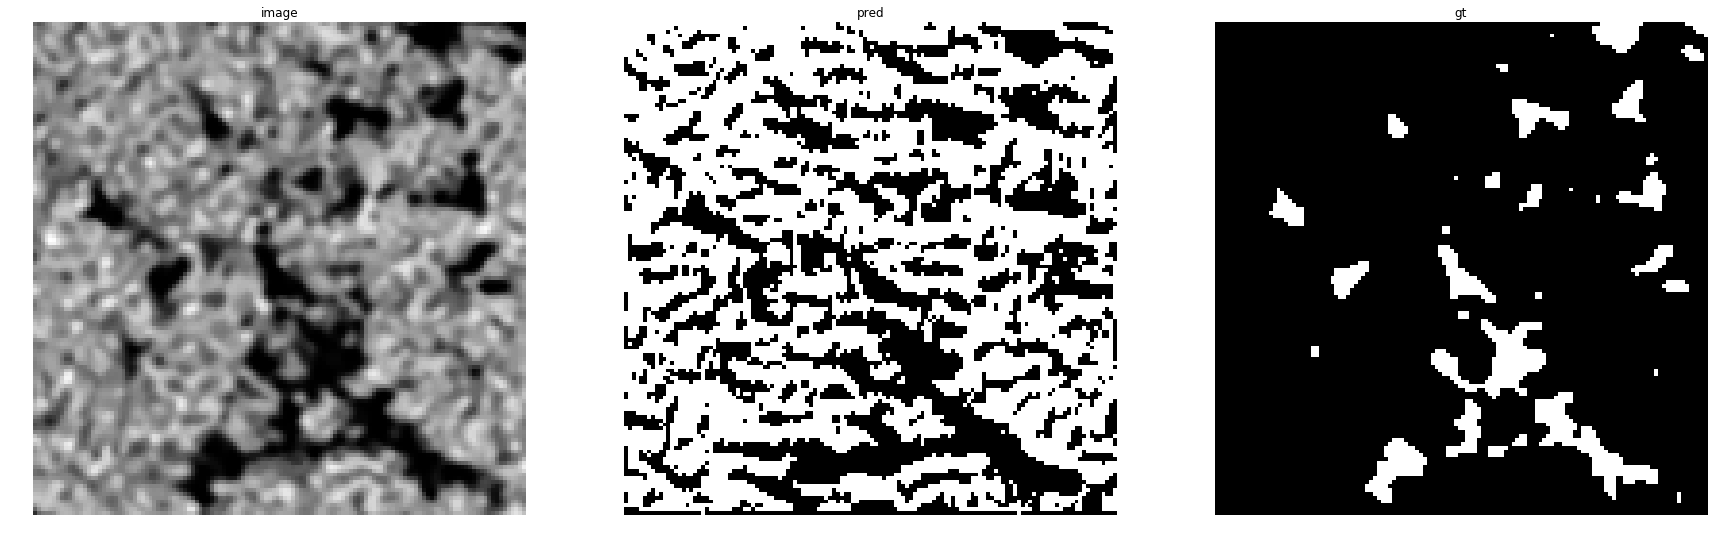

accuracy    : 0.3216552734375
precision   : 0.013281406031555821
recall      : 0.09736456808199122
f1          : 0.02337434094903339
pr_auc      : 0.04556480860876815
iou         : 0.011825375655730417


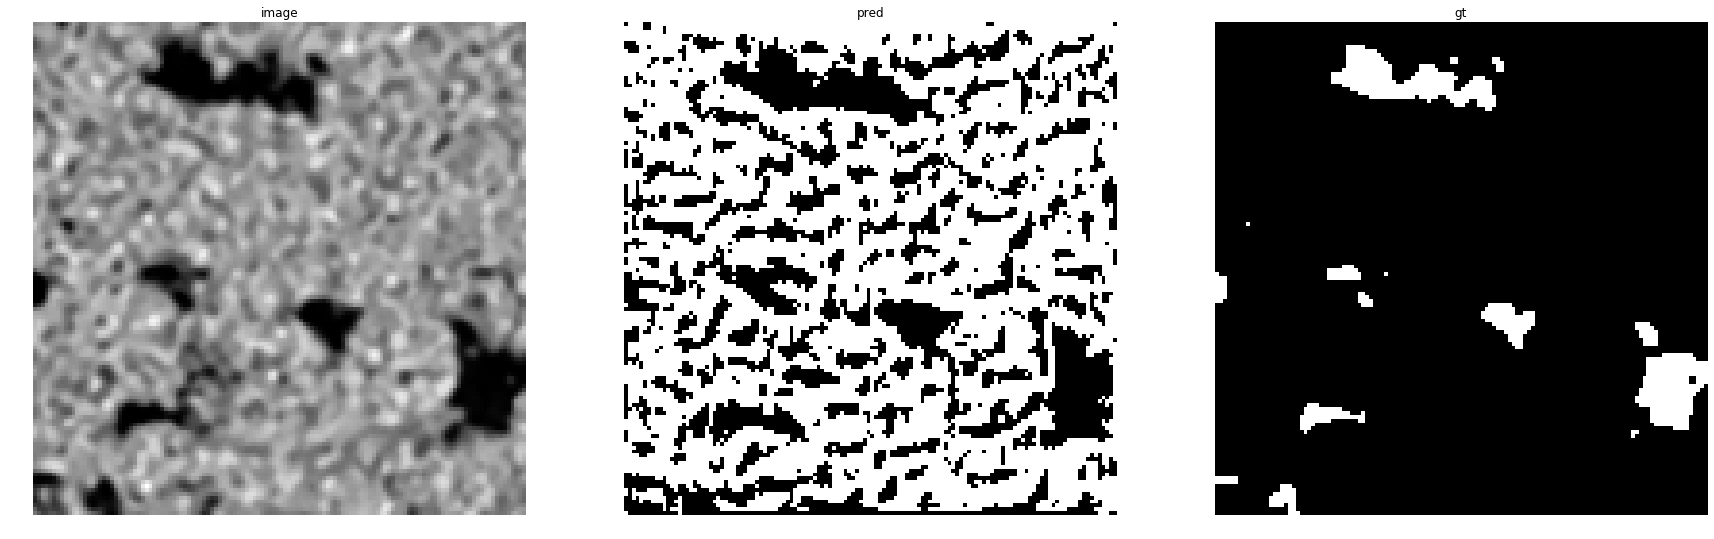

accuracy    : 0.28485107421875
precision   : 0.005846350598337444
recall      : 0.07126948775055679
f1          : 0.010806247361756015
pr_auc      : 0.028926970367574762
iou         : 0.005432476020711315


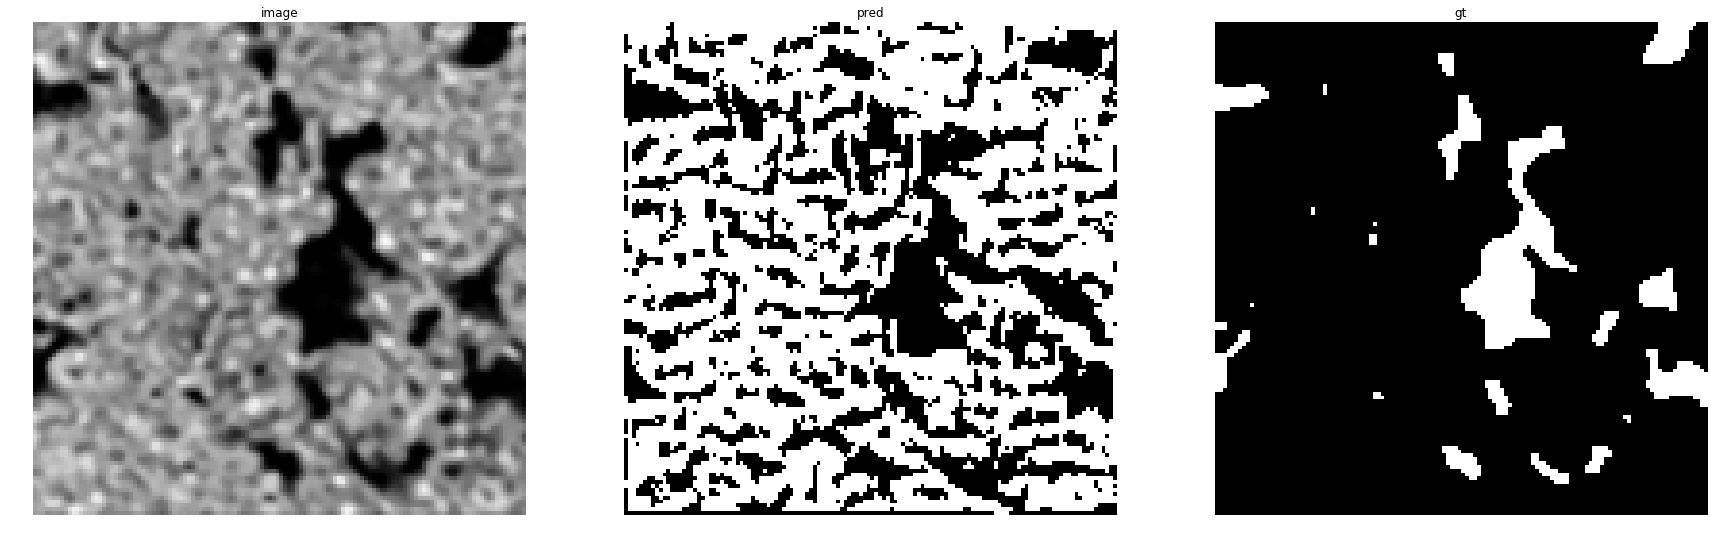

accuracy    : 0.30548095703125
precision   : 0.015384615384615385
recall      : 0.11087719298245614
f1          : 0.027020094057289442
pr_auc      : 0.0476325023821203
iou         : 0.013695068041951981


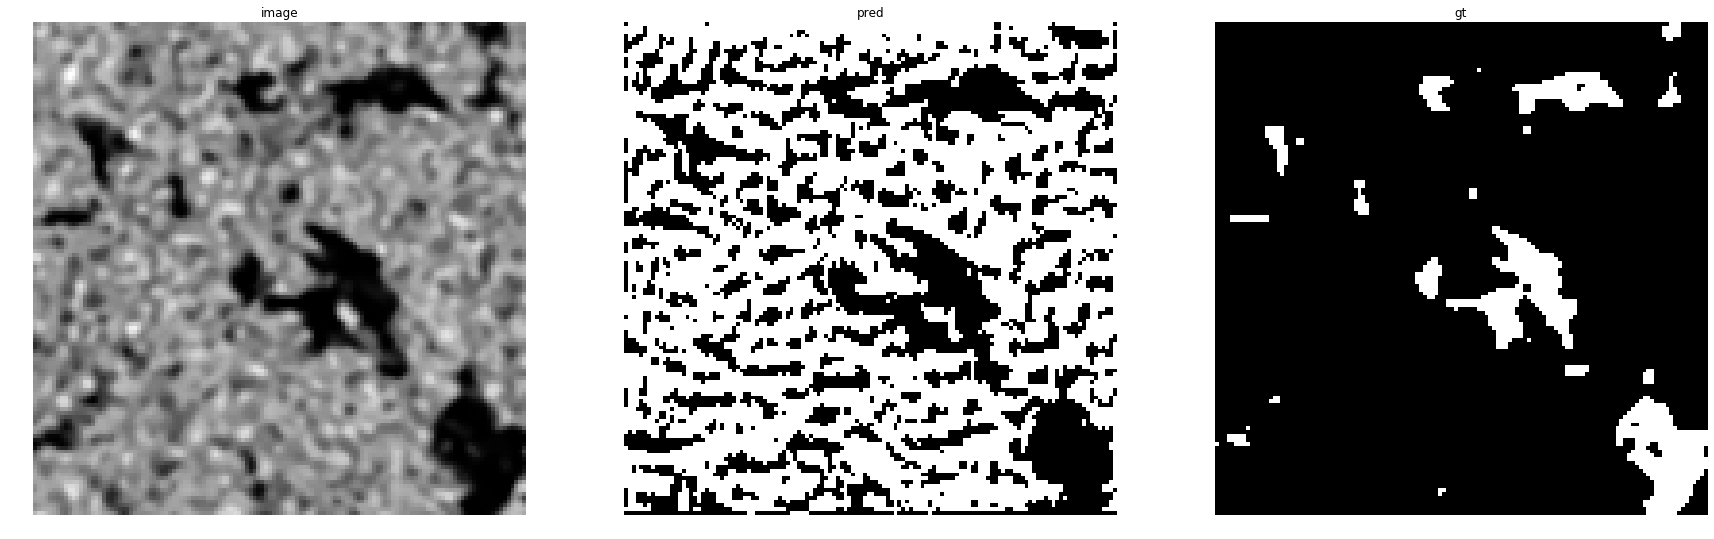

accuracy    : 0.29296875
precision   : 0.009453781512605041
recall      : 0.07557251908396946
f1          : 0.01680529621456459
pr_auc      : 0.04308491651245133
iou         : 0.008473850894462039


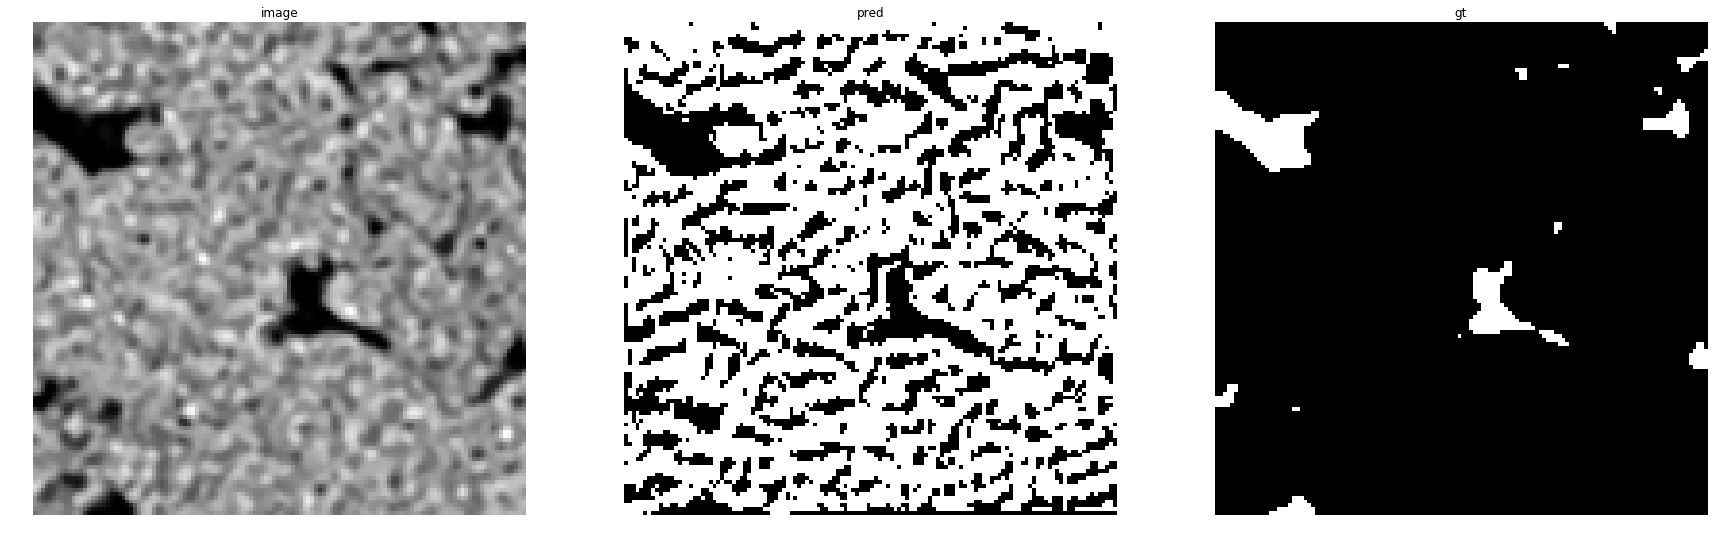

accuracy    : 0.292724609375
precision   : 0.005875971795335382
recall      : 0.09908536585365854
f1          : 0.011094043352107869
pr_auc      : 0.02107879304311733
iou         : 0.00557796275637175


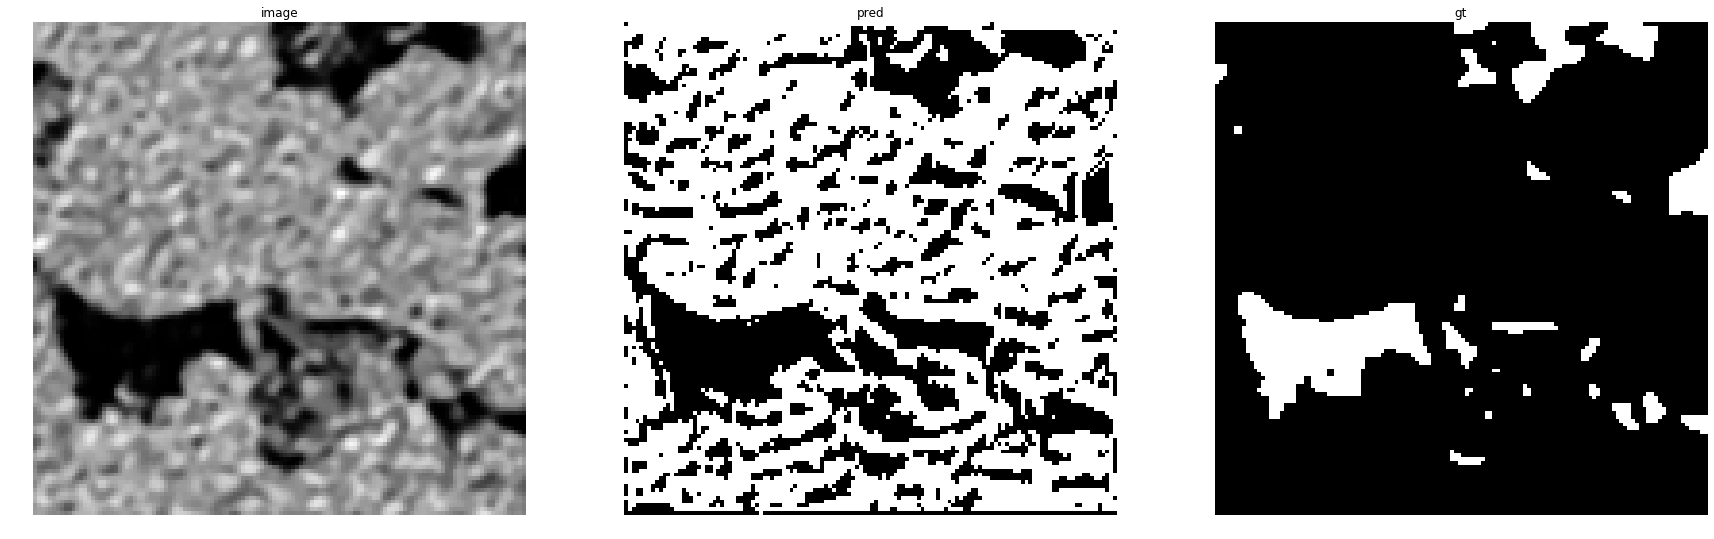

accuracy    : 0.28302001953125
precision   : 0.015297829620422603
recall      : 0.09950248756218906
f1          : 0.026518604458440374
pr_auc      : 0.054486778635935866
iou         : 0.013437473754934072


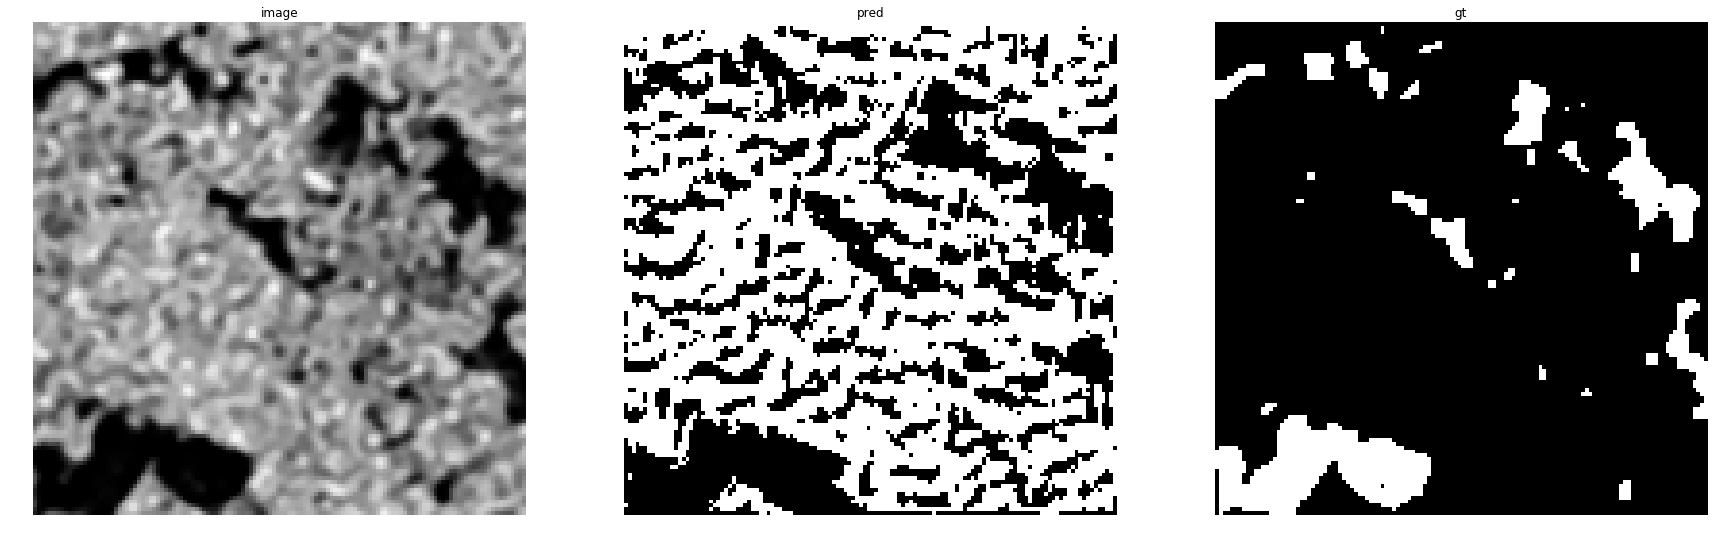

accuracy    : 0.29638671875
precision   : 0.014459513362584763
recall      : 0.08100558659217877
f1          : 0.02453883905906245
pr_auc      : 0.059911875577102904
iou         : 0.012421828150432622
carb71


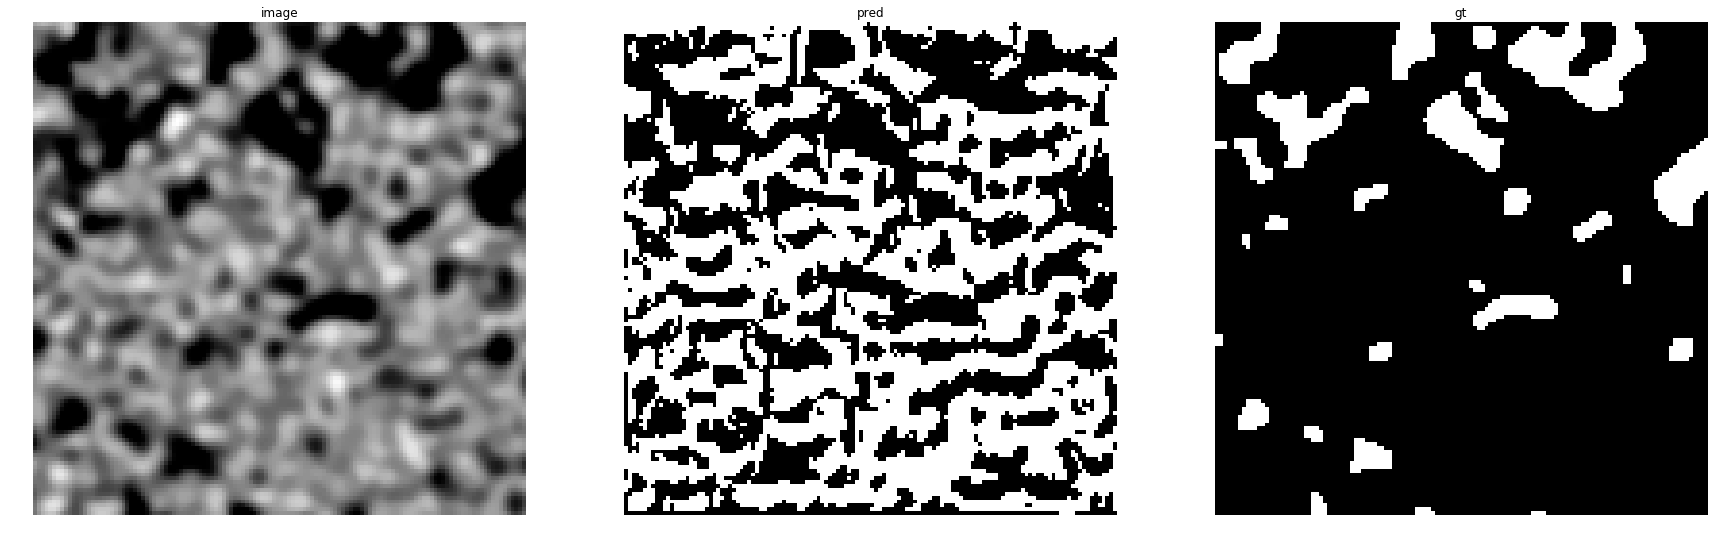

accuracy    : 0.37457275390625
precision   : 0.026585337783404304
recall      : 0.11435643564356436
f1          : 0.04314128303296293
pr_auc      : 0.07083252743973184
iou         : 0.022046192021378124


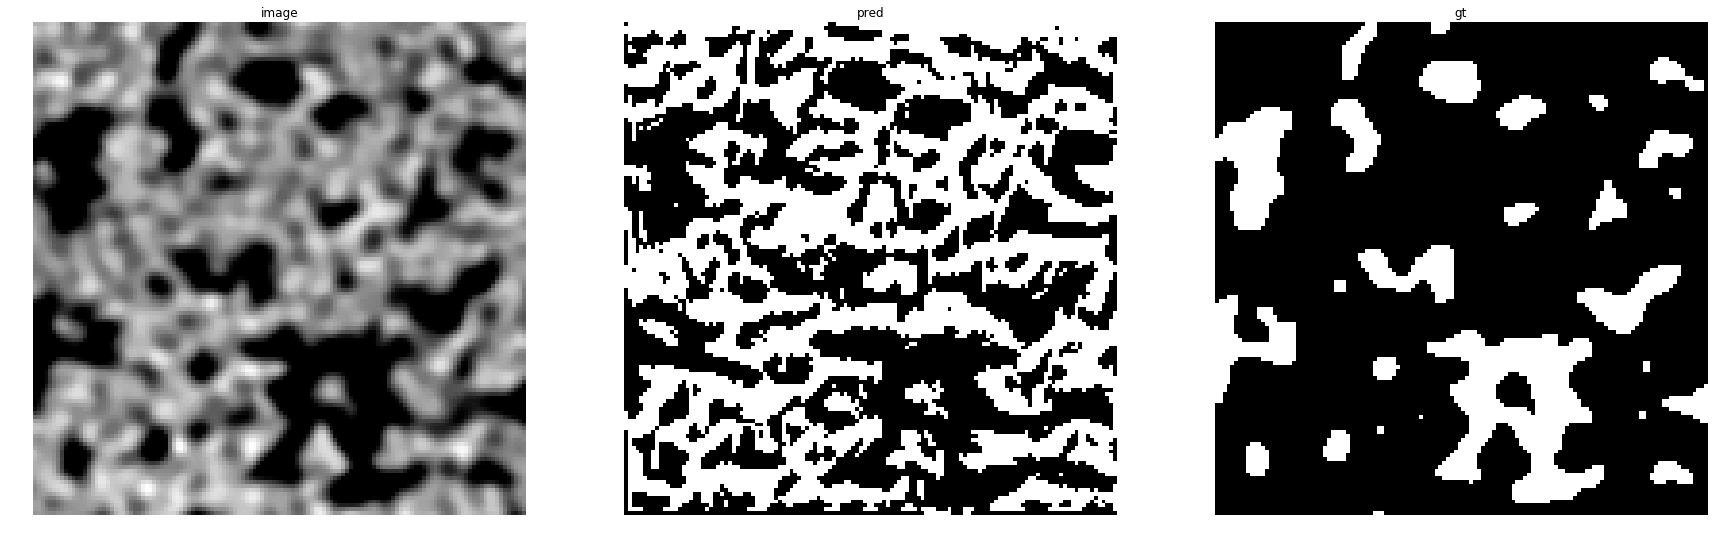

accuracy    : 0.329833984375
precision   : 0.026620091544206217
recall      : 0.07083333333333333
f1          : 0.038697250919278586
pr_auc      : 0.11075128661030324
iou         : 0.01973038121596286


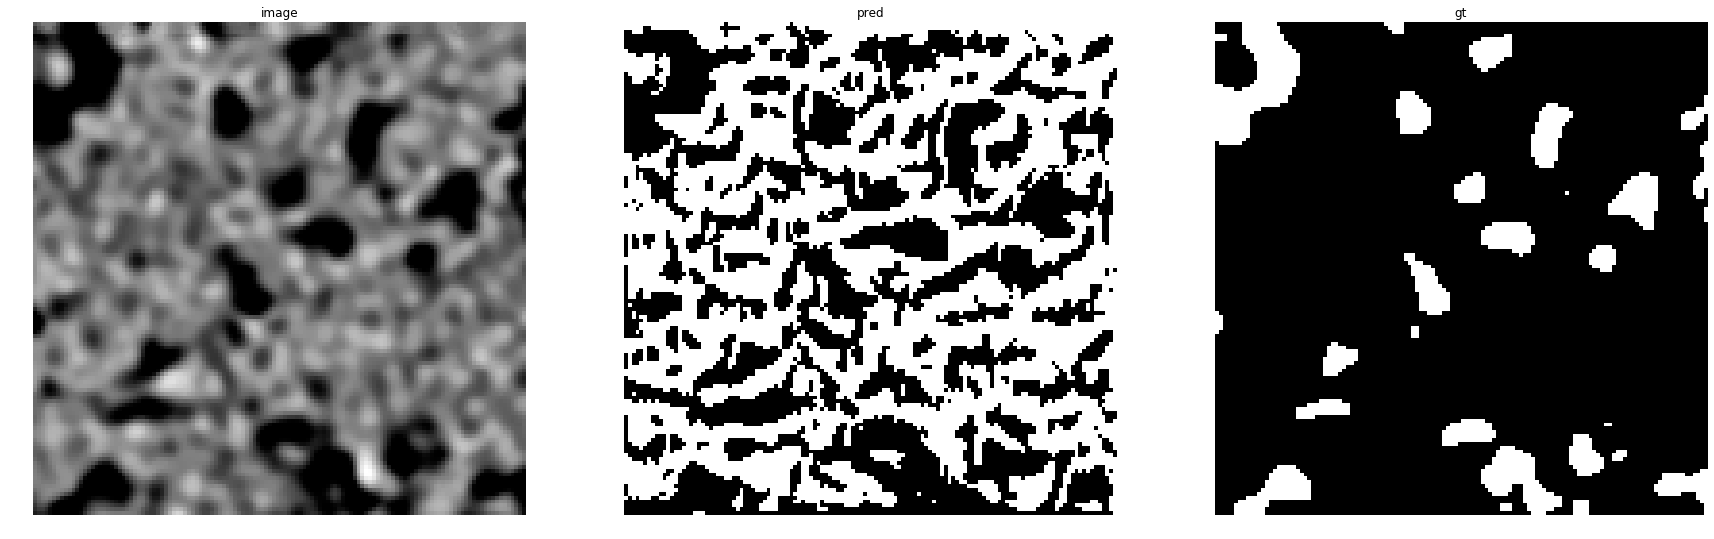

accuracy    : 0.35028076171875
precision   : 0.020477072214355733
recall      : 0.10217391304347827
f1          : 0.034116686326104706
pr_auc      : 0.06346601269970611
iou         : 0.01735438013477338


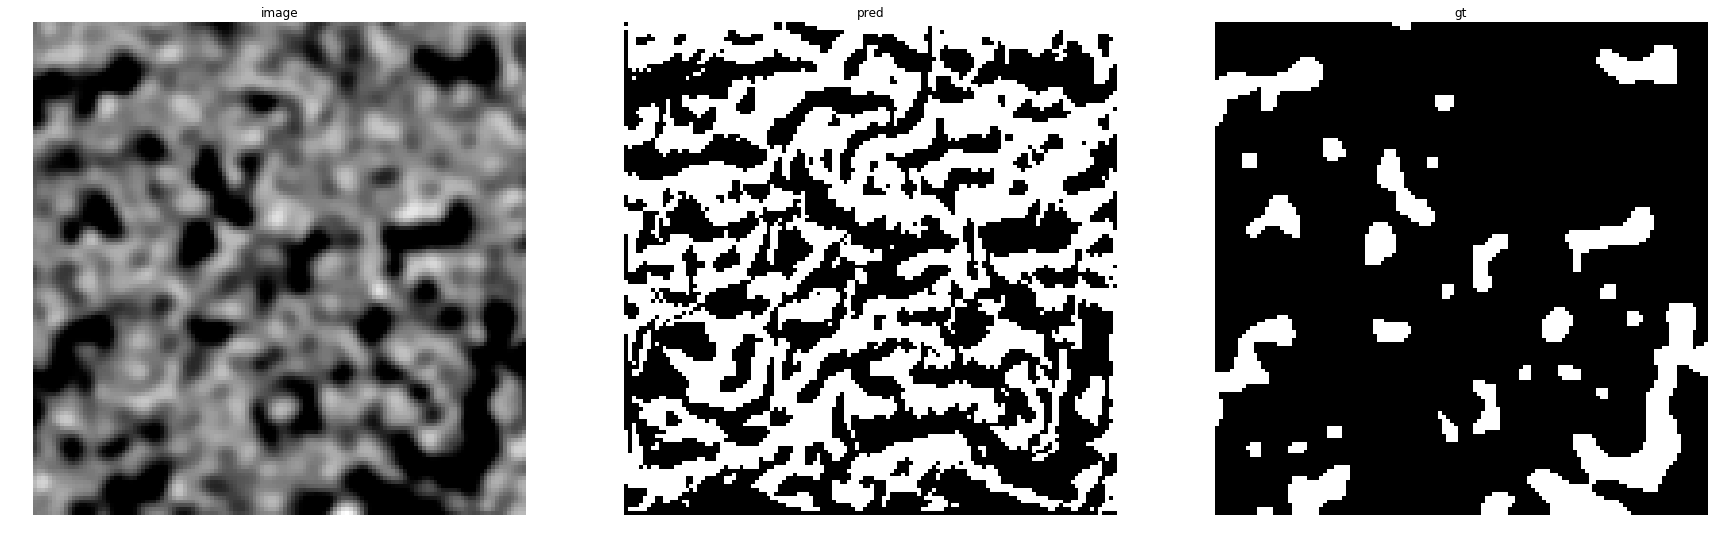

accuracy    : 0.364013671875
precision   : 0.02507910465252549
recall      : 0.09244060475161987
f1          : 0.039454277286135694
pr_auc      : 0.08059218931483979
iou         : 0.020124130148580027


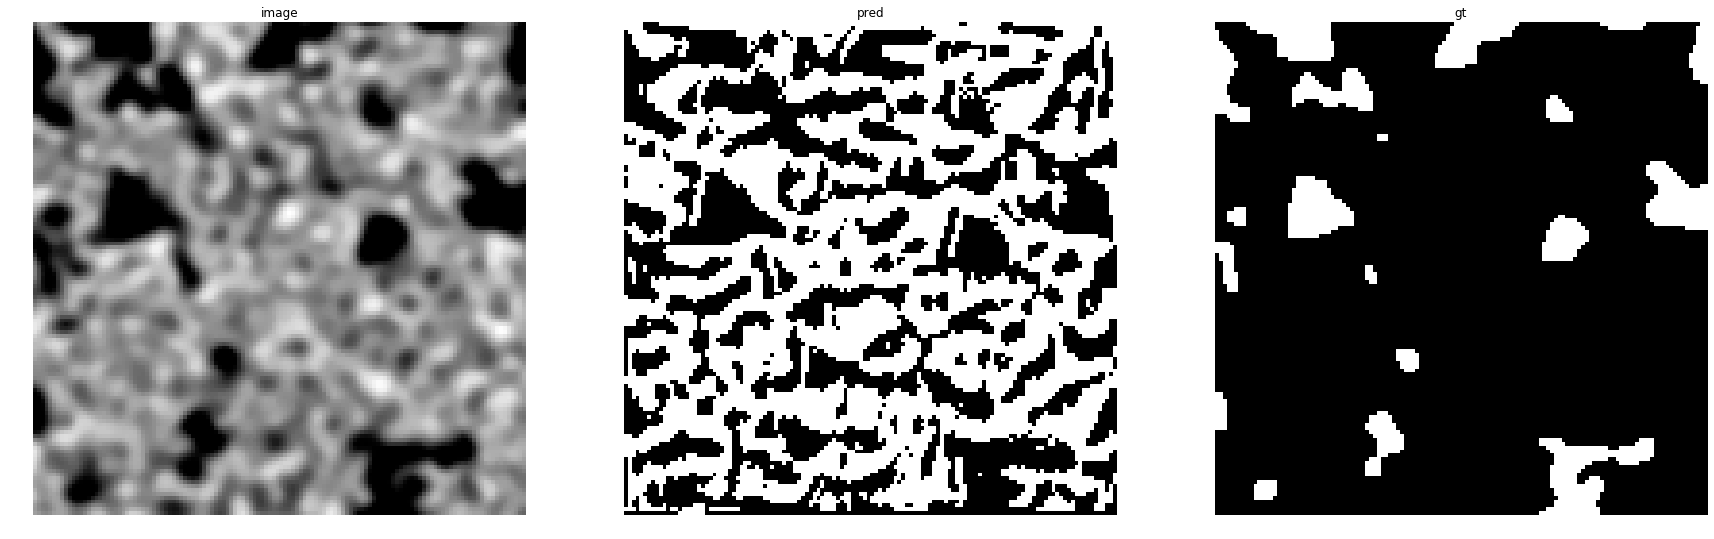

accuracy    : 0.3642578125
precision   : 0.02619515389652914
recall      : 0.1384083044982699
f1          : 0.04405286343612334
pr_auc      : 0.060977523924595954
iou         : 0.02252252252252252


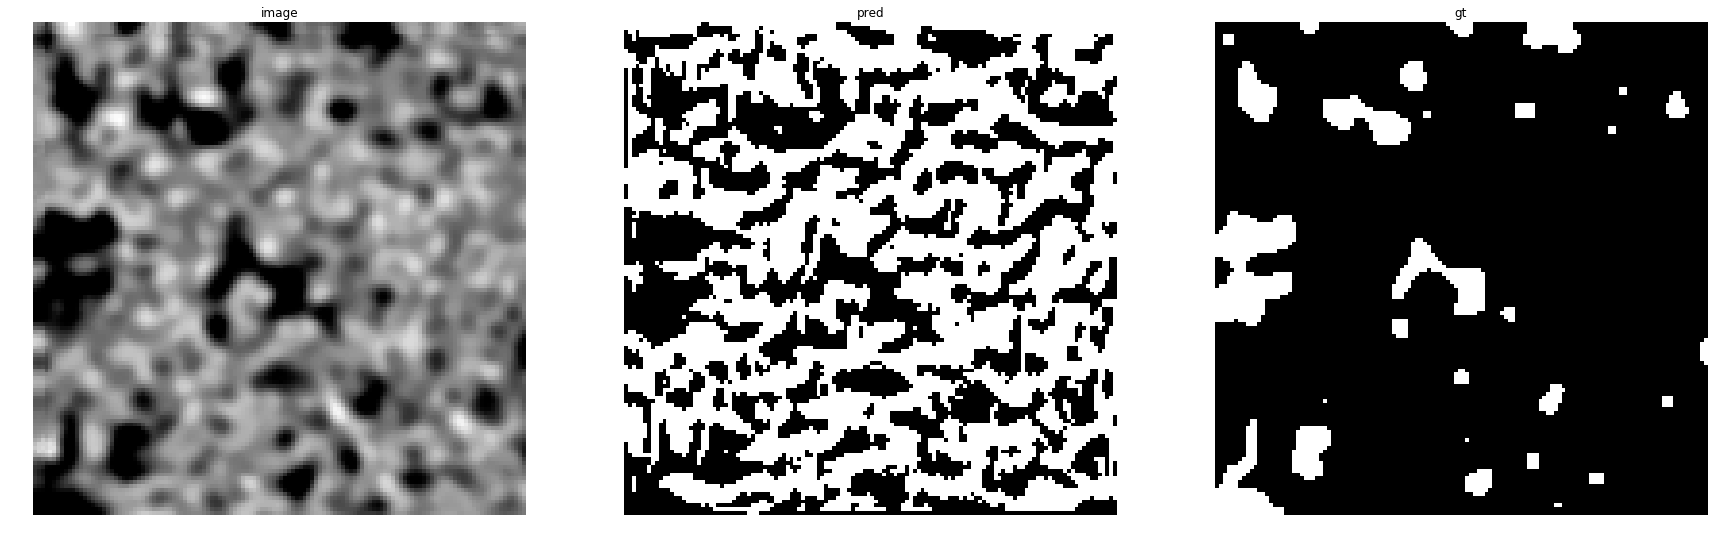

accuracy    : 0.3603515625
precision   : 0.01895938812883766
recall      : 0.11362169141381537
f1          : 0.03249630723781388
pr_auc      : 0.05313028151748332
iou         : 0.016516516516516516


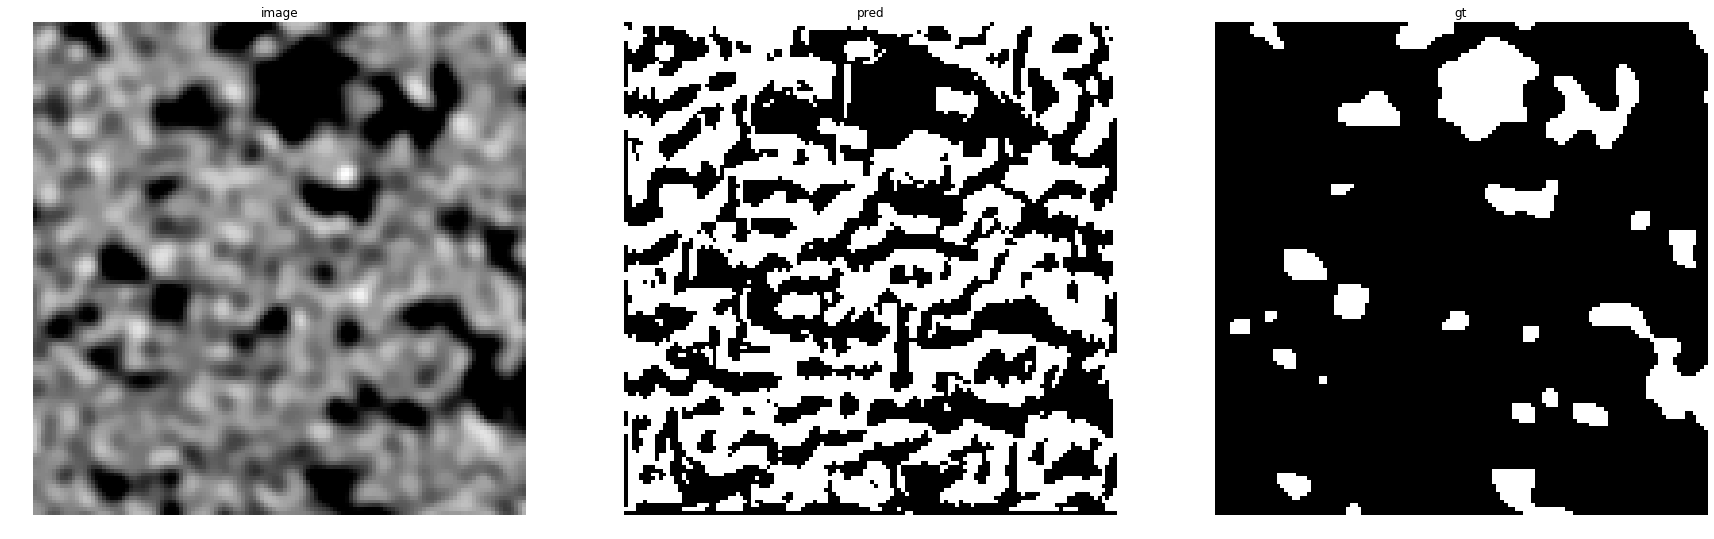

accuracy    : 0.37286376953125
precision   : 0.025646923519263946
recall      : 0.11006910167818361
f1          : 0.04160059695923888
pr_auc      : 0.07071540140481124
iou         : 0.021242141360259096


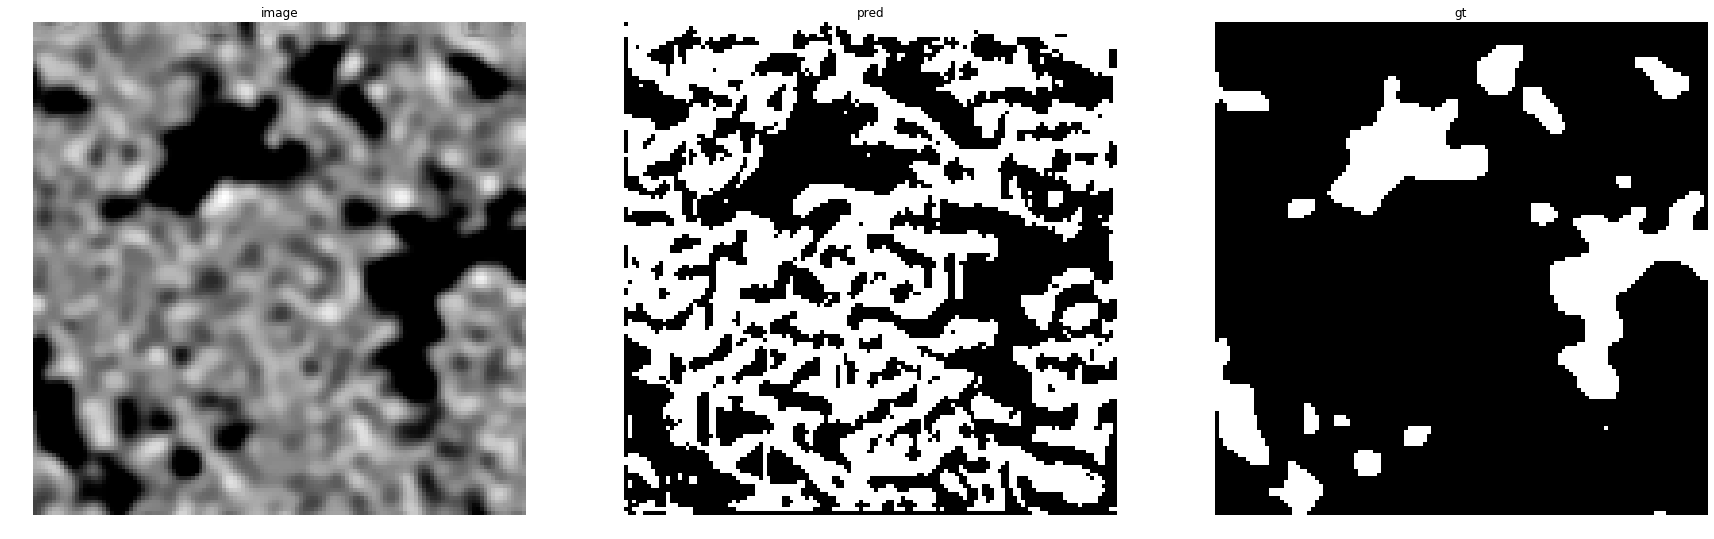

accuracy    : 0.33172607421875
precision   : 0.01669334552938486
recall      : 0.05851703406813627
f1          : 0.025976336624855434
pr_auc      : 0.0851672523609202
iou         : 0.013159080666967103


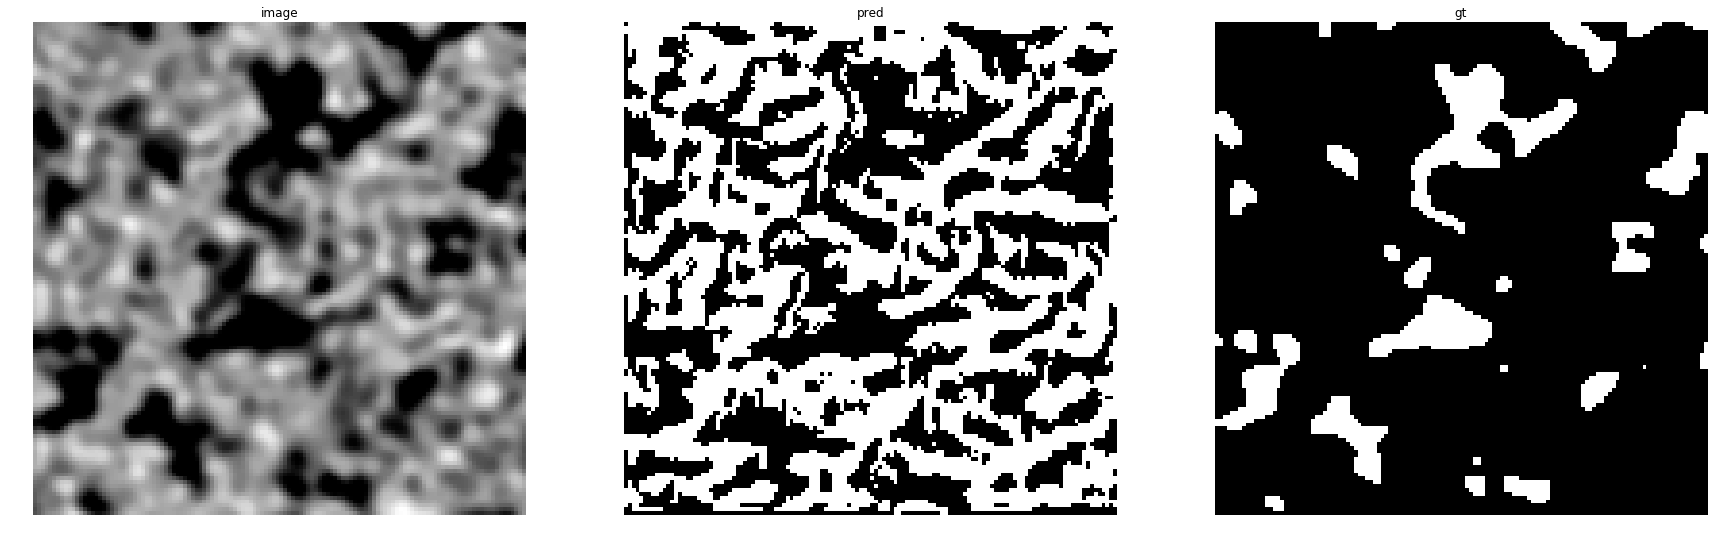

accuracy    : 0.3642578125
precision   : 0.023763058202272987
recall      : 0.0976875884851345
f1          : 0.03822714681440442
pr_auc      : 0.07446240305141288
iou         : 0.019486020898051397


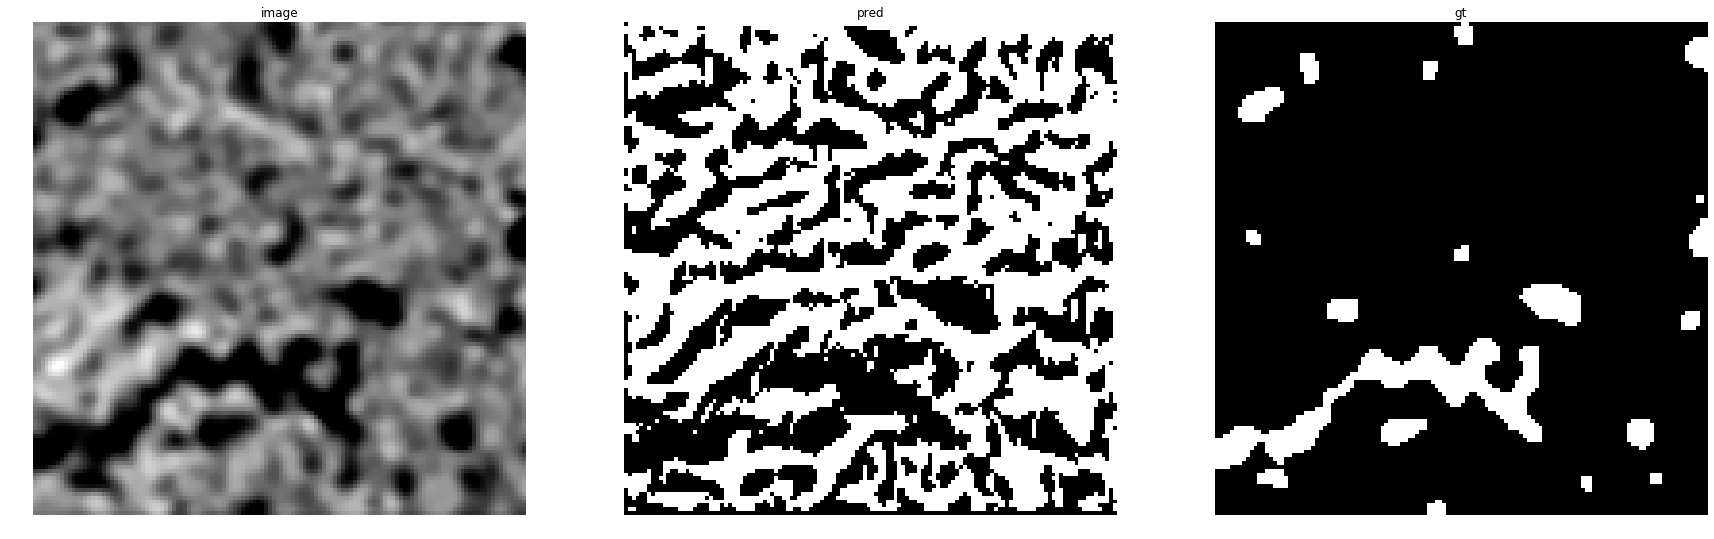

accuracy    : 0.370361328125
precision   : 0.013519406890536415
recall      : 0.08908045977011494
f1          : 0.023475956077243468
pr_auc      : 0.04751731213644865
iou         : 0.011877394636015325
carbRNF


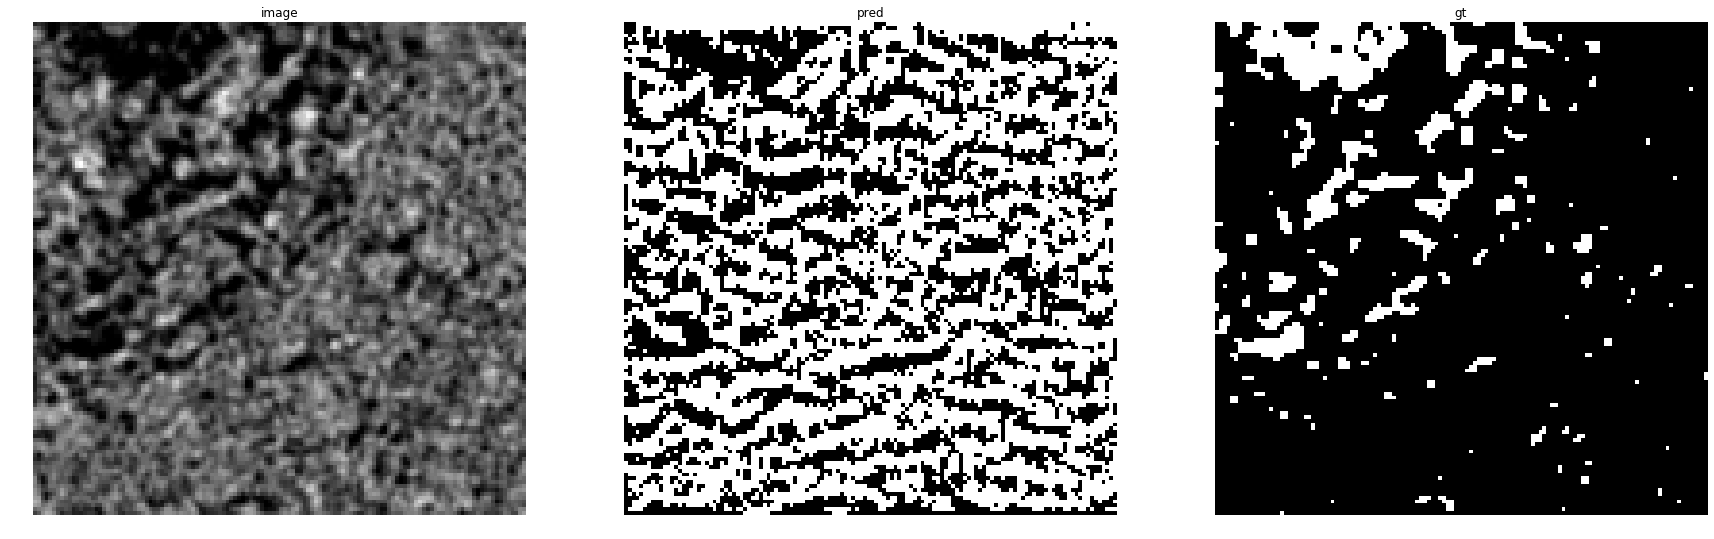

accuracy    : 0.3736572265625
precision   : 0.04705011630365828
recall      : 0.2626918536009445
f1          : 0.07980631276901004
pr_auc      : 0.0649874040725872
iou         : 0.04156159521808163


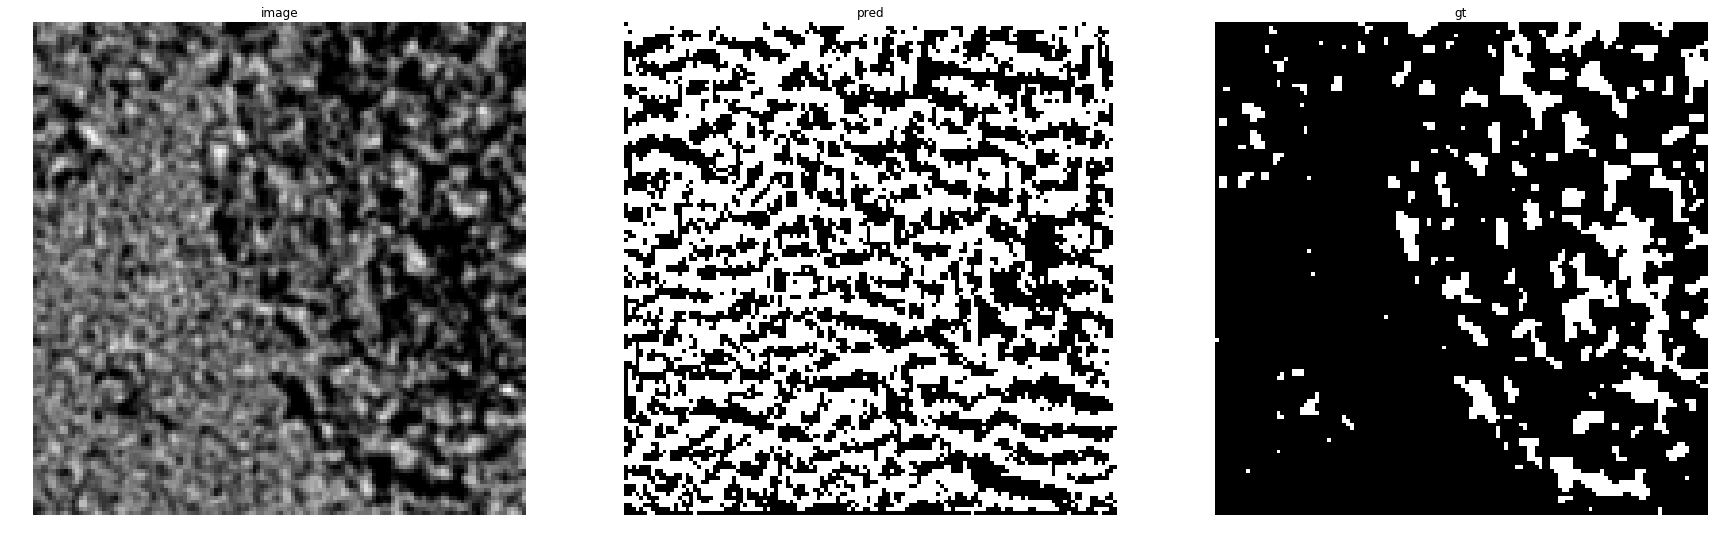

accuracy    : 0.3892822265625
precision   : 0.0865040650406504
recall      : 0.3357172907025663
f1          : 0.1375624892259955
pr_auc      : 0.0992994485481799
iou         : 0.07386153276564235


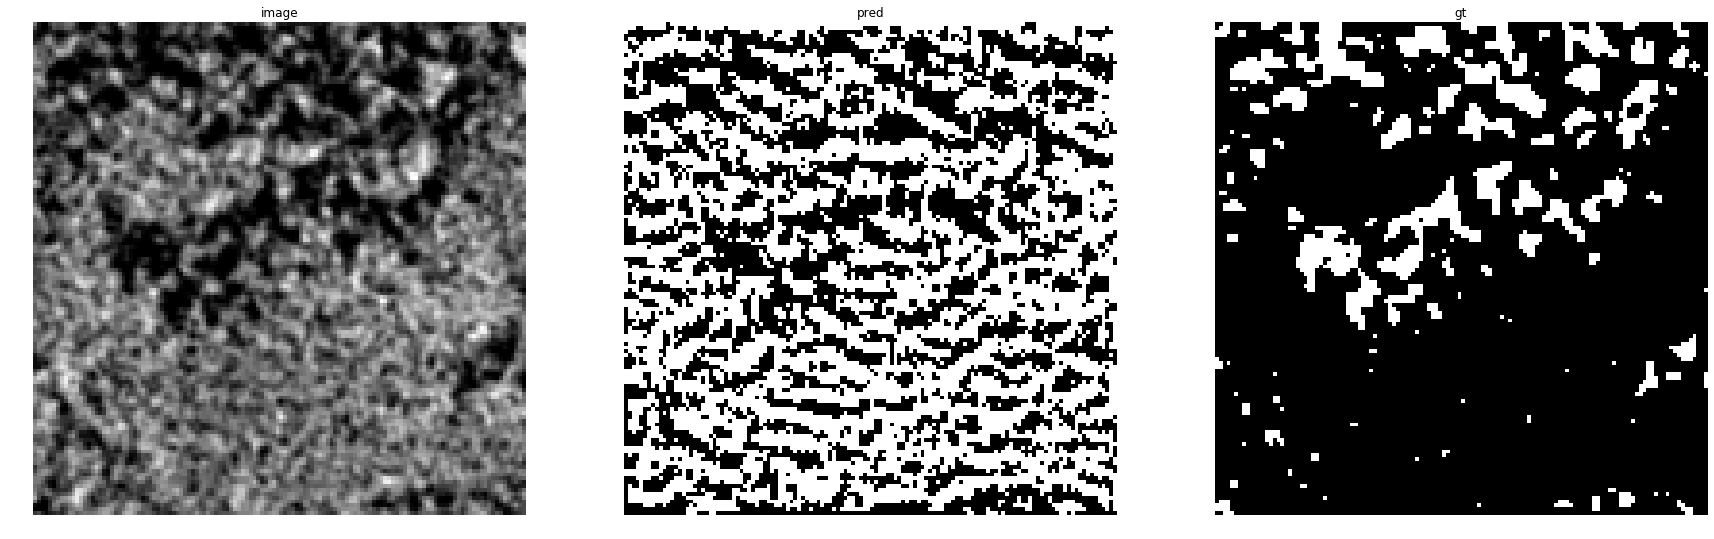

accuracy    : 0.37591552734375
precision   : 0.06212468610110274
recall      : 0.25816696914700543
f1          : 0.10014960837806917
pr_auc      : 0.08502471714135094
iou         : 0.052714471002408746


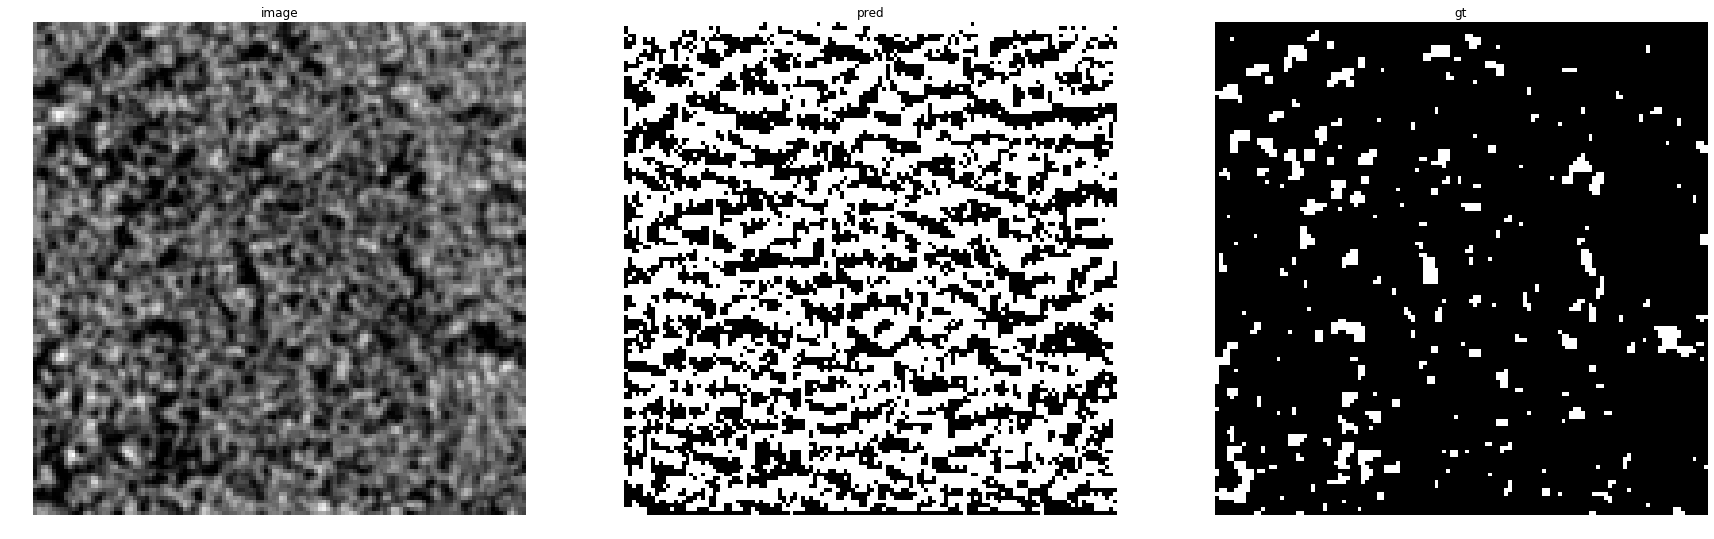

accuracy    : 0.3809814453125
precision   : 0.03674729799279465
recall      : 0.3128834355828221
f1          : 0.06577008106116435
pr_auc      : 0.04535697540057647
iou         : 0.034003238403657494


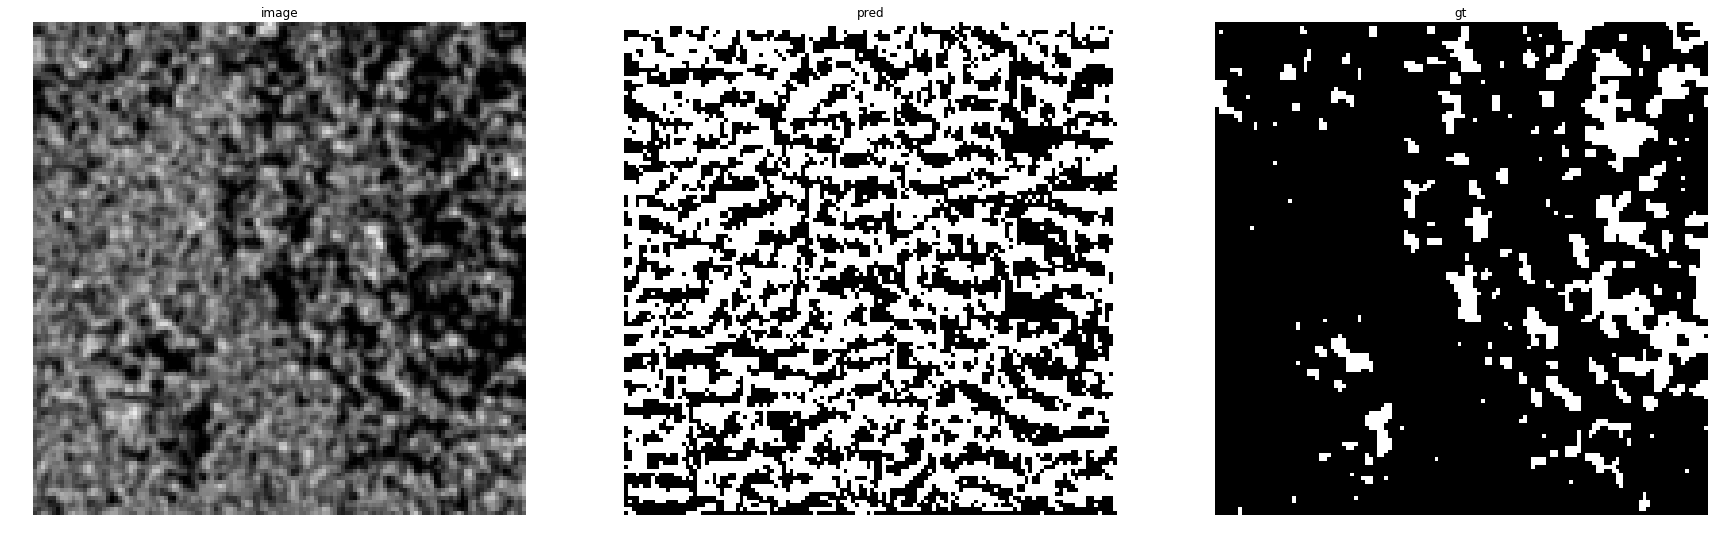

accuracy    : 0.3917236328125
precision   : 0.08031955090143582
recall      : 0.3395709721588316
f1          : 0.12991094814038762
pr_auc      : 0.09085394233009096
iou         : 0.06946778711484594


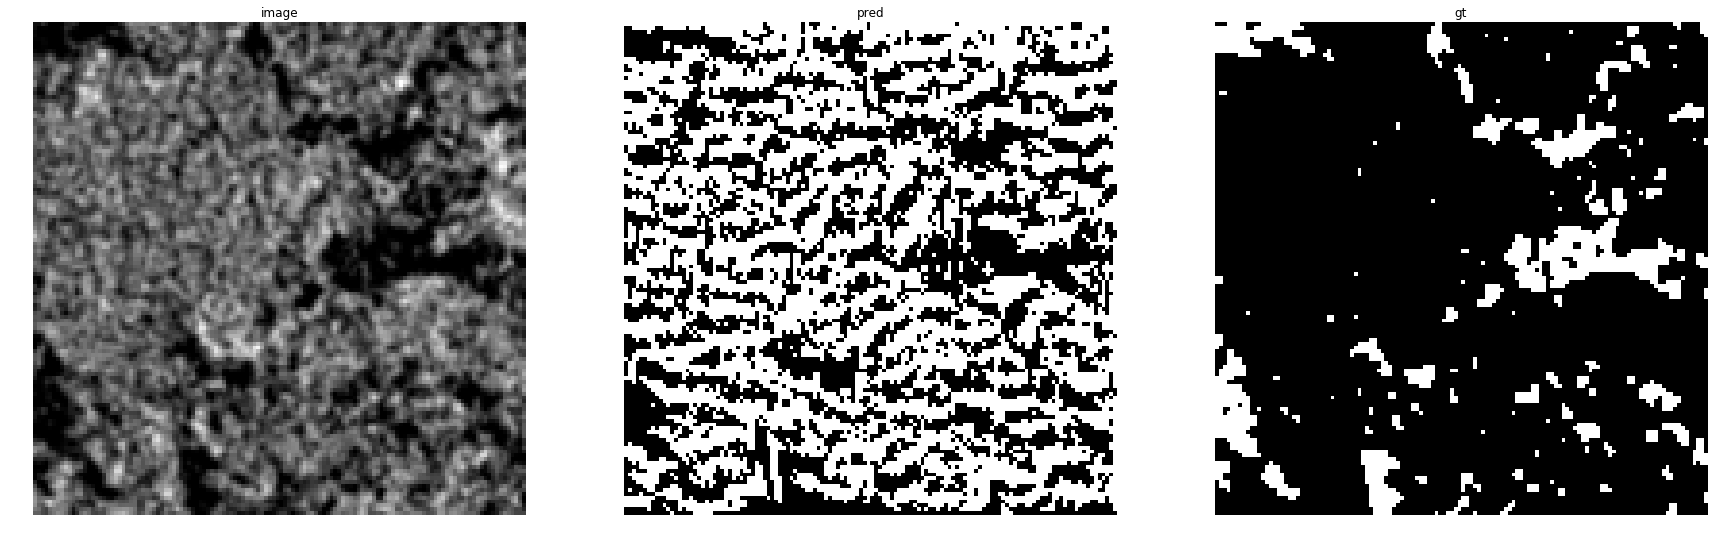

accuracy    : 0.3751220703125
precision   : 0.04689880304678999
recall      : 0.2256544502617801
f1          : 0.07765765765765766
pr_auc      : 0.0720259932652405
iou         : 0.040397413065891834


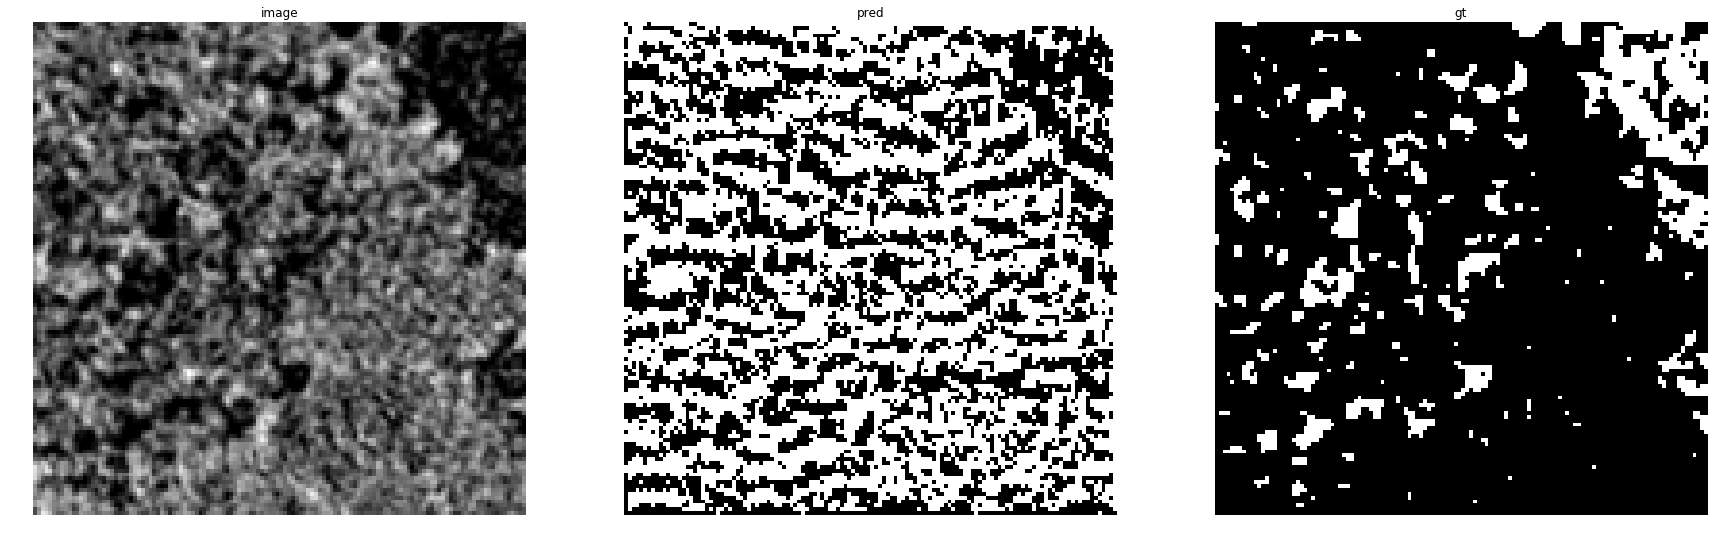

accuracy    : 0.392333984375
precision   : 0.08000872029649007
recall      : 0.32622222222222225
f1          : 0.12850140056022408
pr_auc      : 0.09403171454940495
iou         : 0.06866230121608981


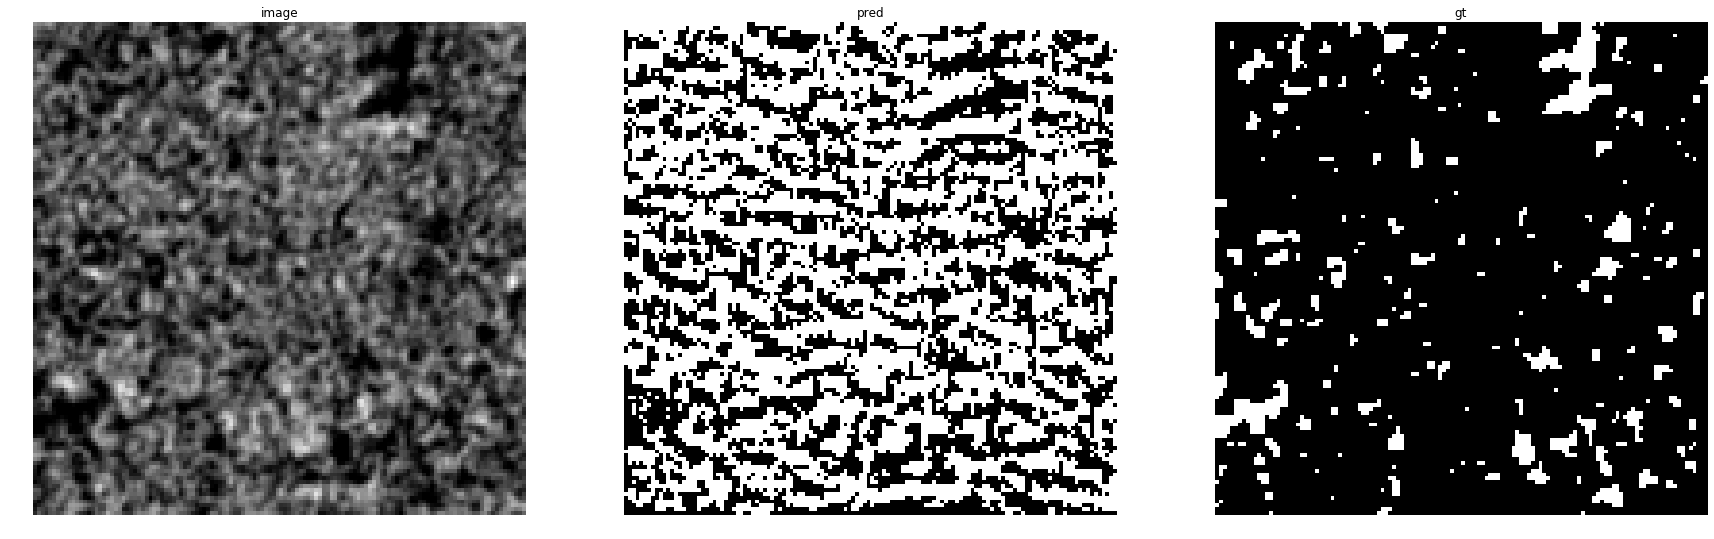

accuracy    : 0.385986328125
precision   : 0.04698553479041284
recall      : 0.3008789722785666
f1          : 0.08127853881278539
pr_auc      : 0.0585075849461336
iou         : 0.04236078058067587


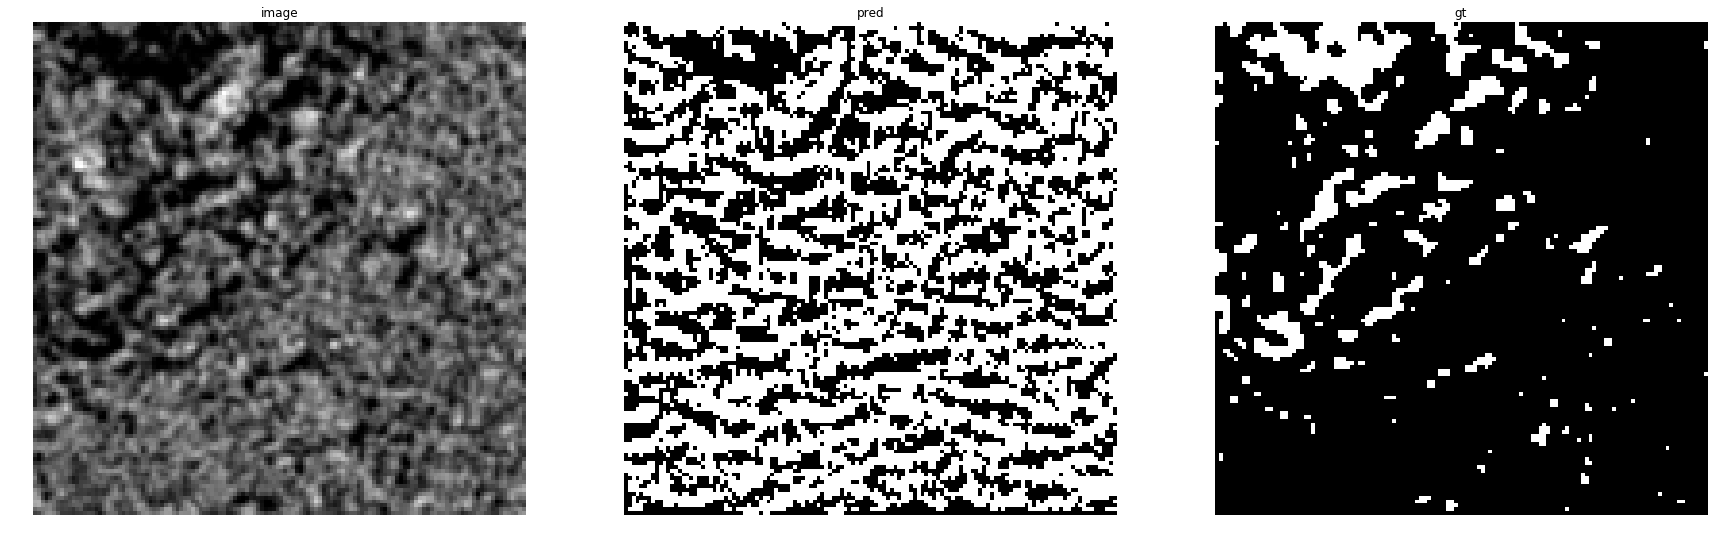

accuracy    : 0.375244140625
precision   : 0.0491005291005291
recall      : 0.2707117852975496
f1          : 0.08312432819777858
pr_auc      : 0.066006369251158
iou         : 0.04336448598130841


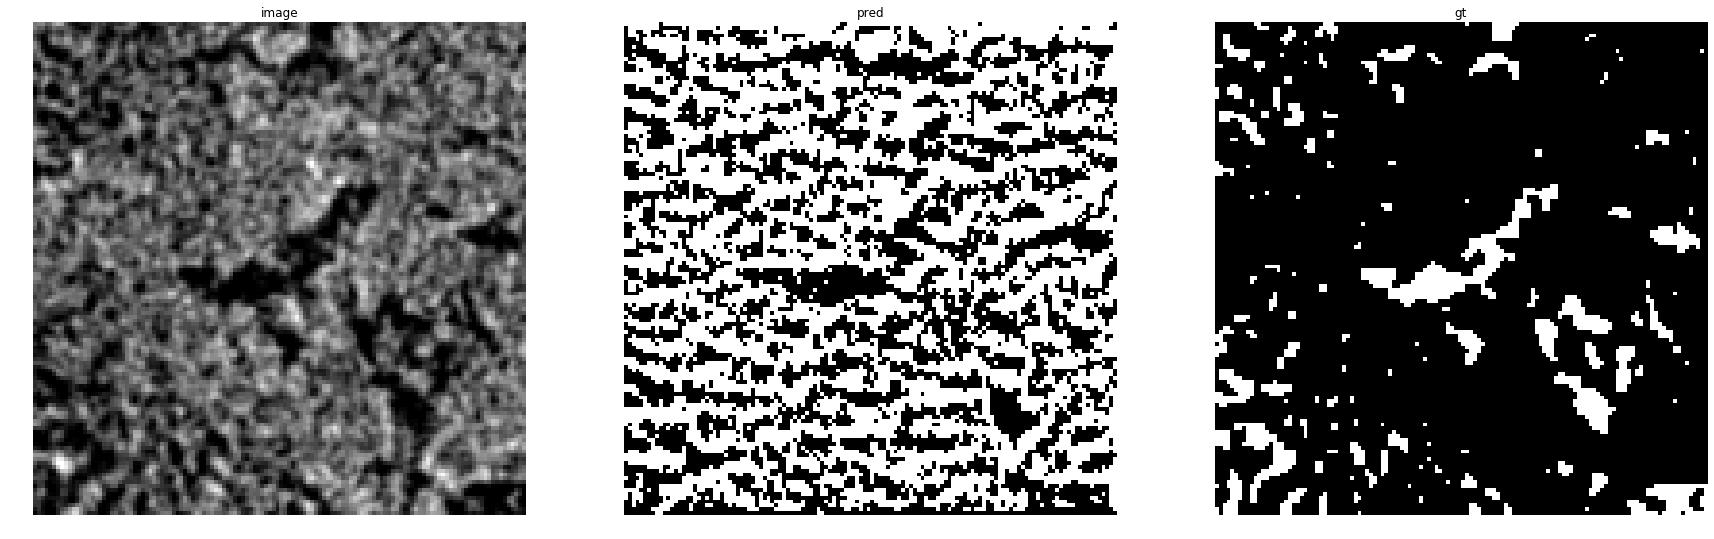

accuracy    : 0.37176513671875
precision   : 0.04891535516801361
recall      : 0.2542841348811498
f1          : 0.08204762329439044
pr_auc      : 0.06906591231384489
iou         : 0.04277875941597694
SPE_carb10_58_box3


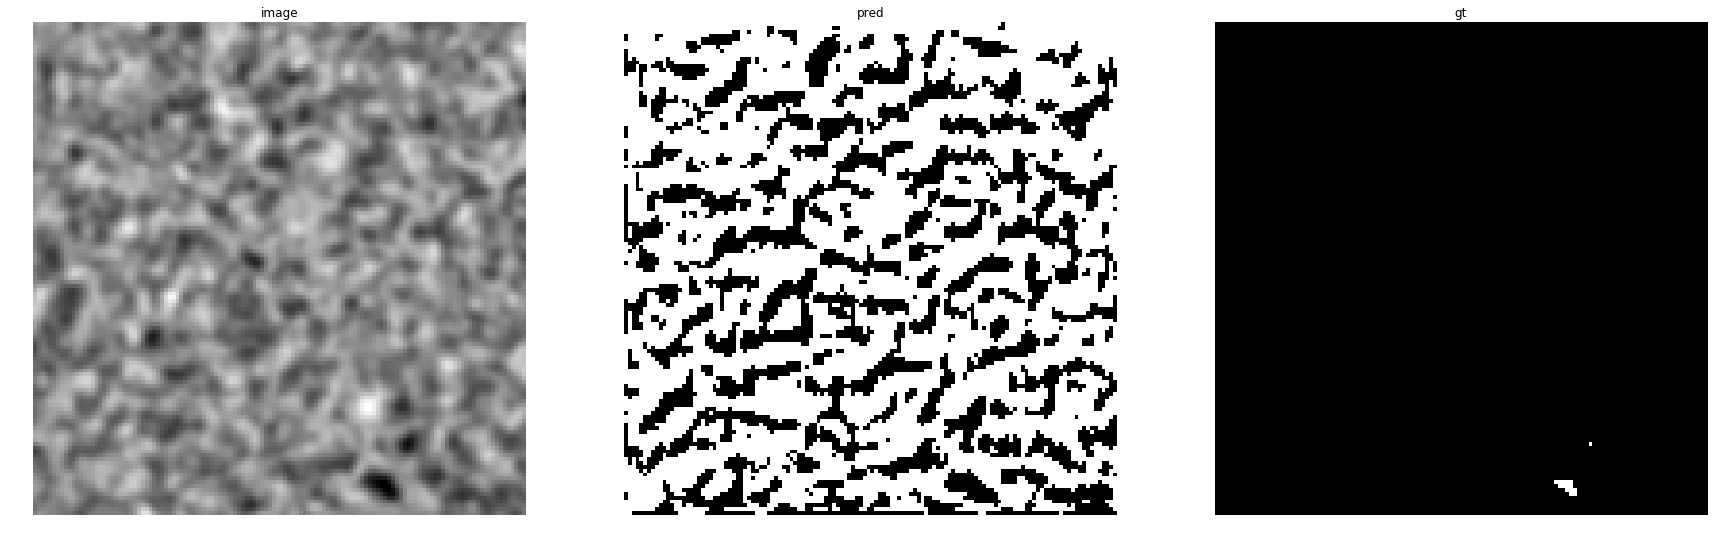

accuracy    : 0.32855224609375
precision   : 0.0
recall      : 0.0
f1          : 0.0
pr_auc      : 0.0004942637883406592
iou         : 0.0


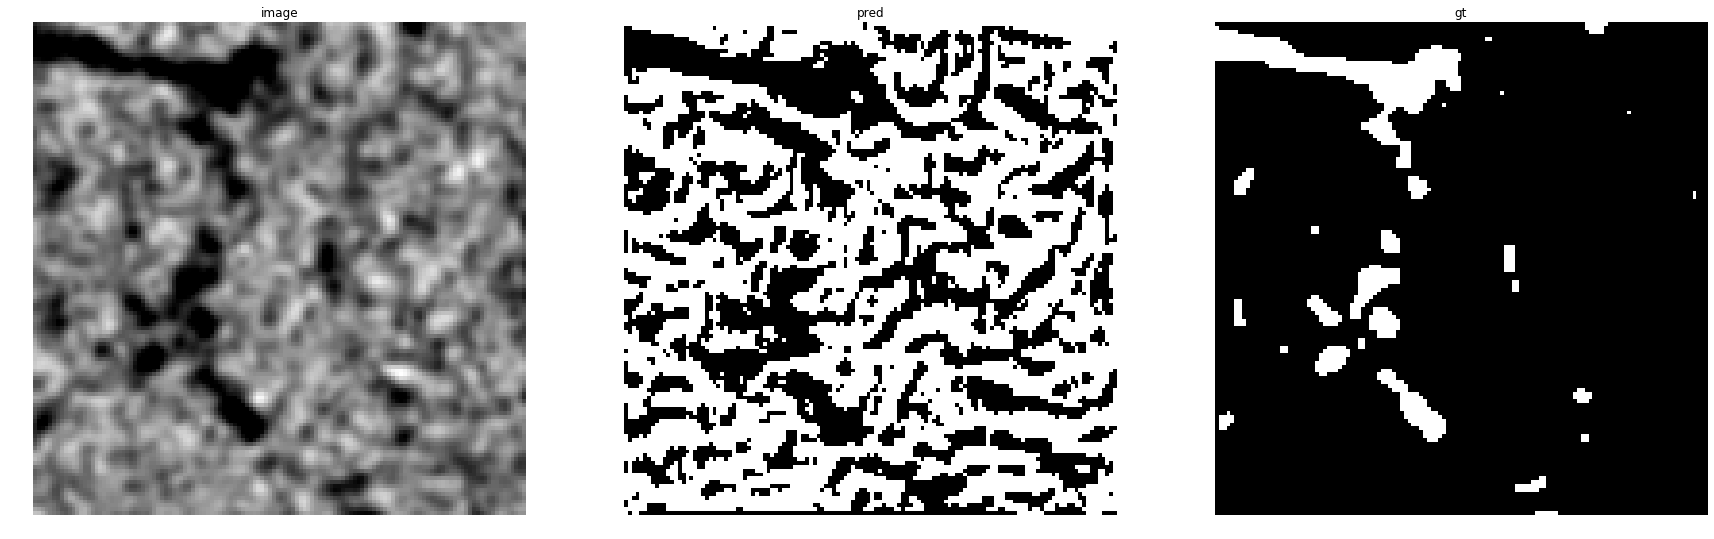

accuracy    : 0.34381103515625
precision   : 0.00728952772073922
recall      : 0.06157849089332177
f1          : 0.013035894611218214
pr_auc      : 0.037513006872822455
iou         : 0.006560709665496212


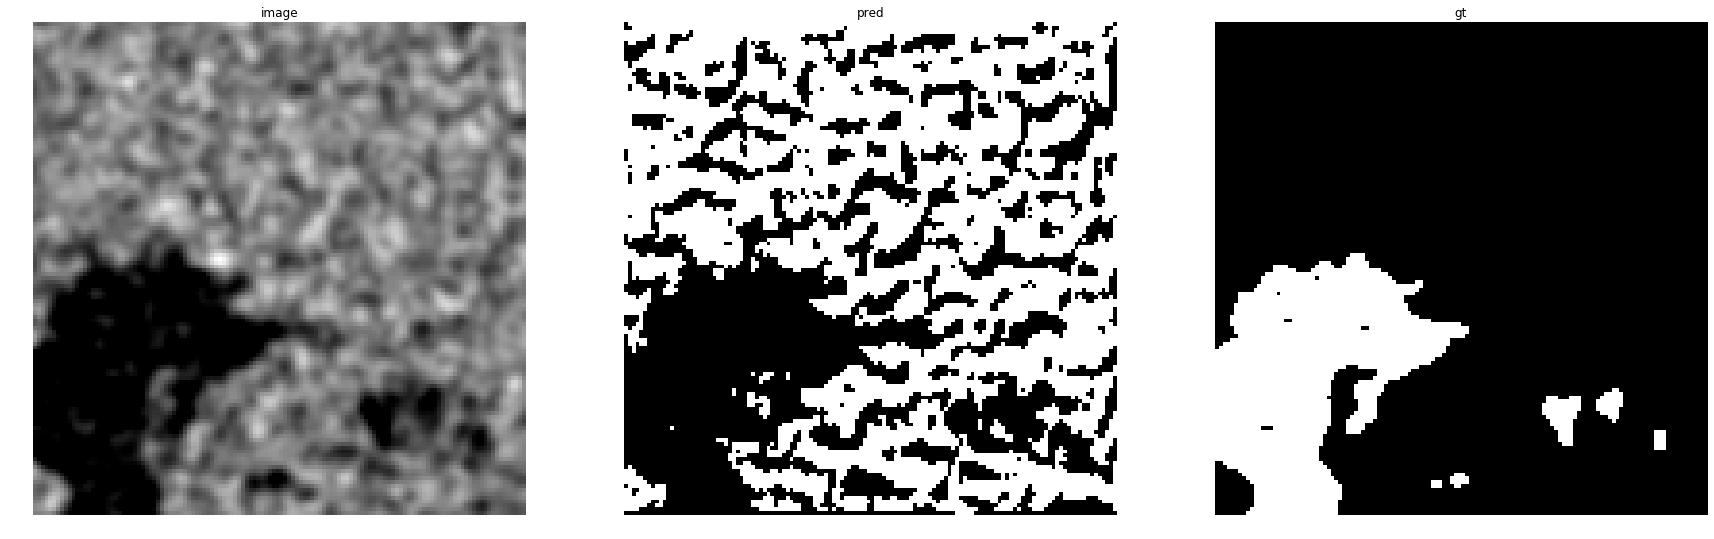

accuracy    : 0.29461669921875
precision   : 0.009858692080184028
recall      : 0.03450920245398773
f1          : 0.015336116554485813
pr_auc      : 0.0873267582295512
iou         : 0.0077273117540997685


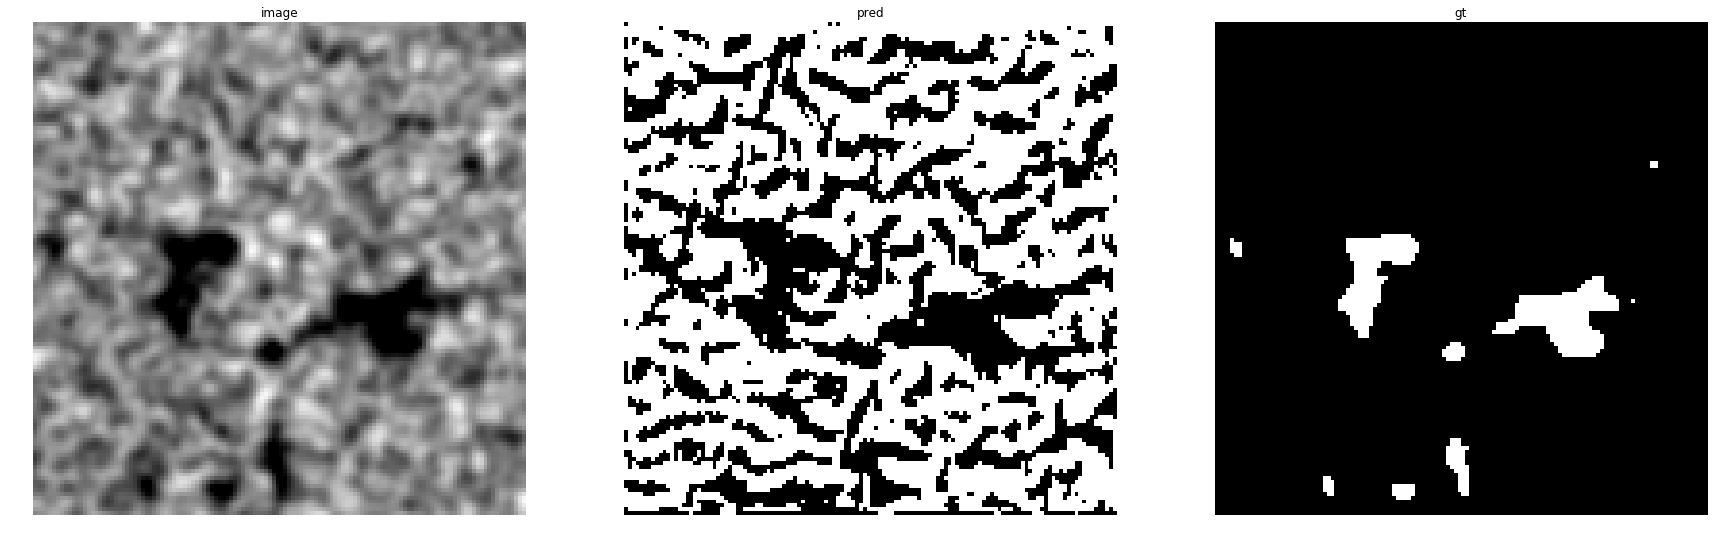

accuracy    : 0.3427734375
precision   : 0.005030578023278753
recall      : 0.06967213114754098
f1          : 0.009383624655013799
pr_auc      : 0.023838241127739346
iou         : 0.0047139291986320365


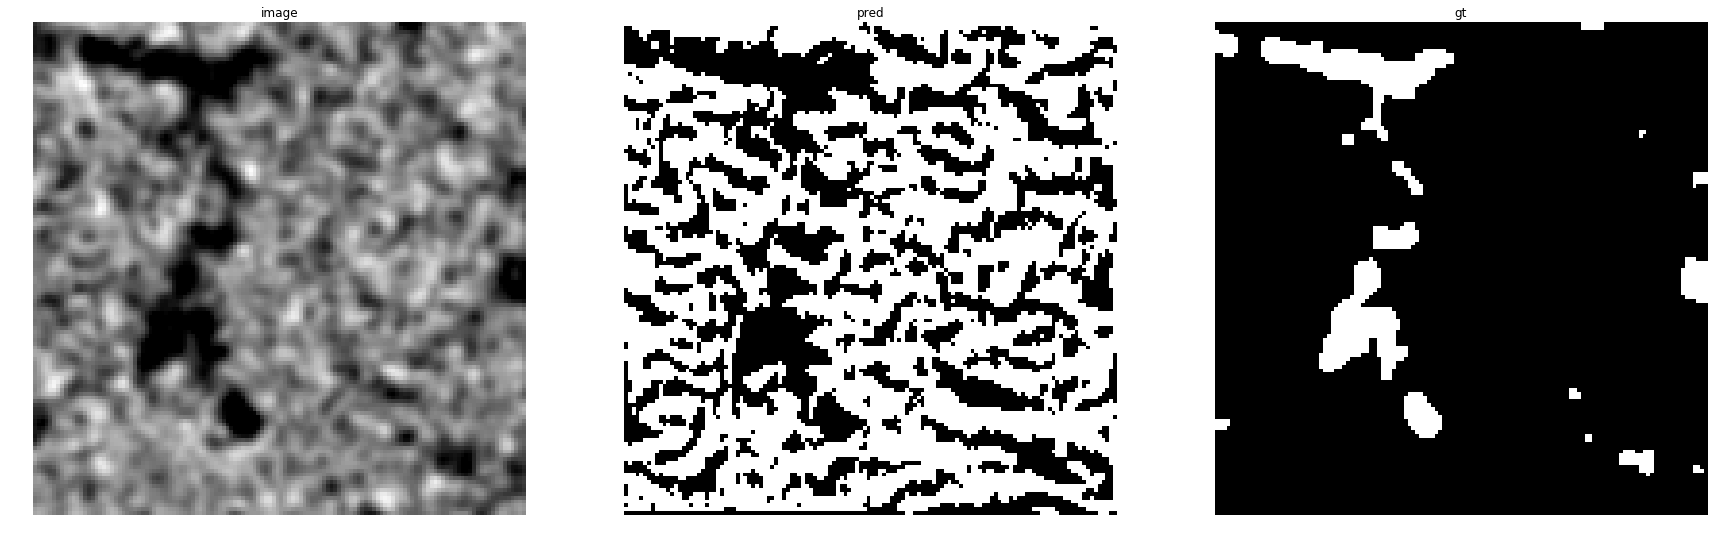

accuracy    : 0.34002685546875
precision   : 0.011443037974683544
recall      : 0.09707903780068729
f1          : 0.020472868919286166
pr_auc      : 0.038645536985180105
iou         : 0.010342302764049058


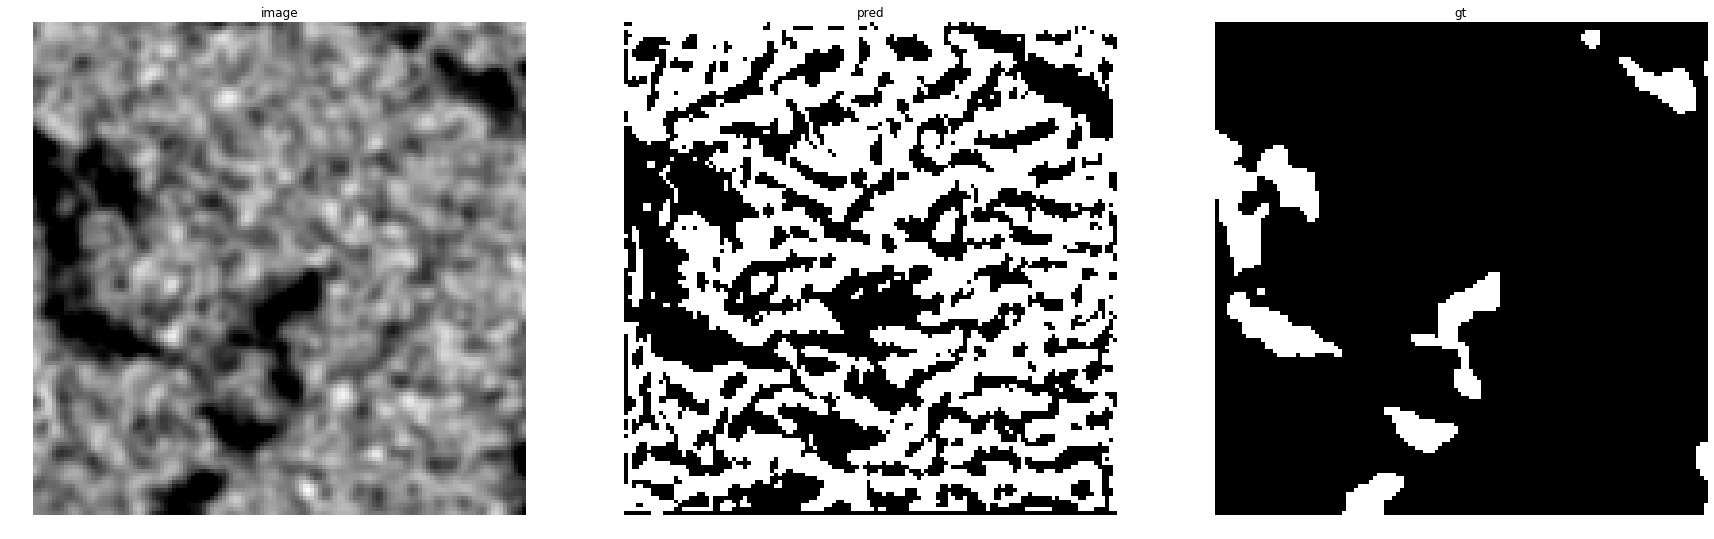

accuracy    : 0.3514404296875
precision   : 0.010127650596054437
recall      : 0.07169529499626587
f1          : 0.017748197448696615
pr_auc      : 0.04407571365463723
iou         : 0.008953553441522105


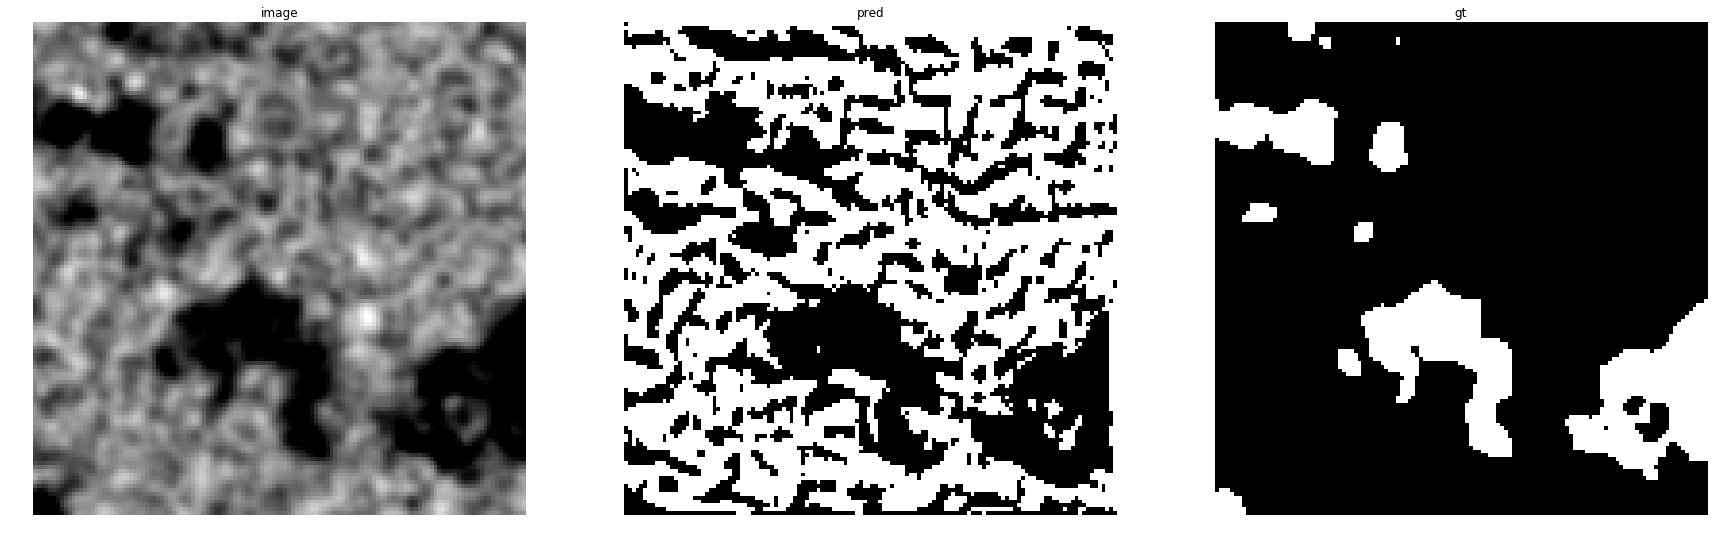

accuracy    : 0.32049560546875
precision   : 0.02238643773092806
recall      : 0.08792146820315834
f1          : 0.03568644434820268
pr_auc      : 0.0811942782775461
iou         : 0.0181673868947879


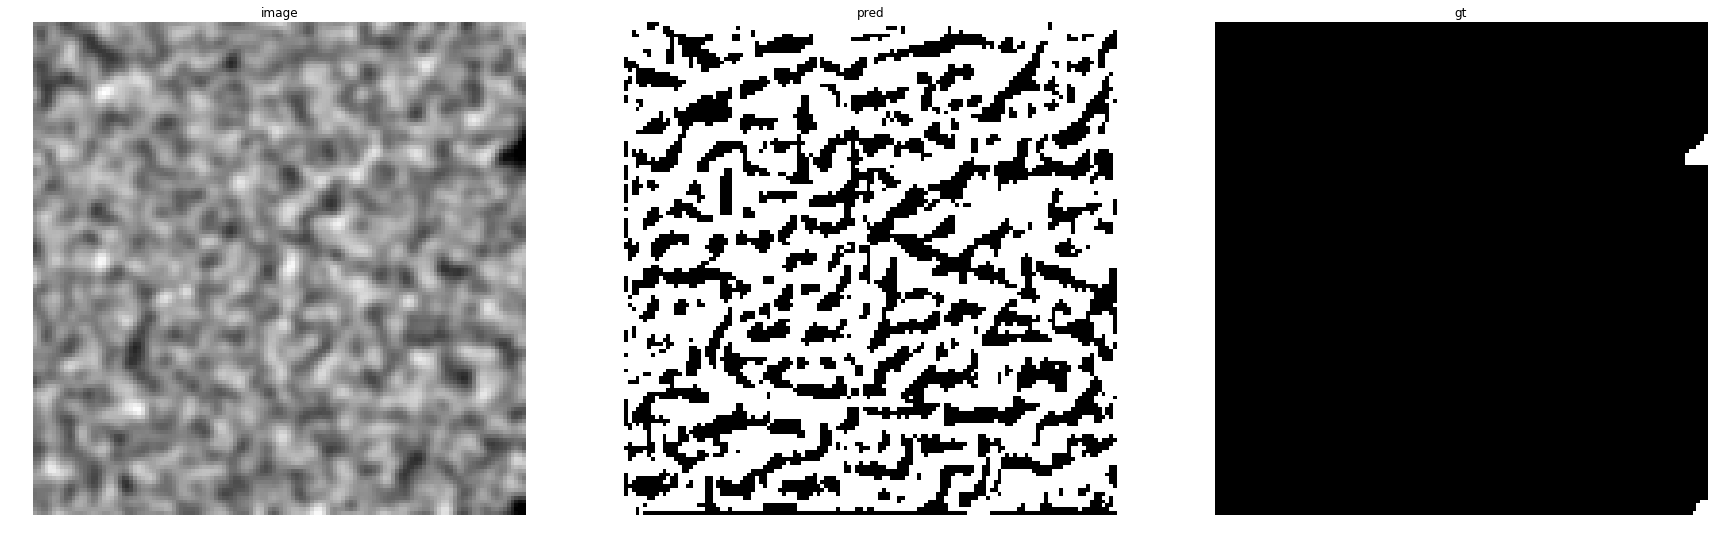

accuracy    : 0.33447265625
precision   : 0.0014686983660730677
recall      : 0.38095238095238093
f1          : 0.002926115581565472
pr_auc      : 0.004047340766328962
iou         : 0.0014652014652014652


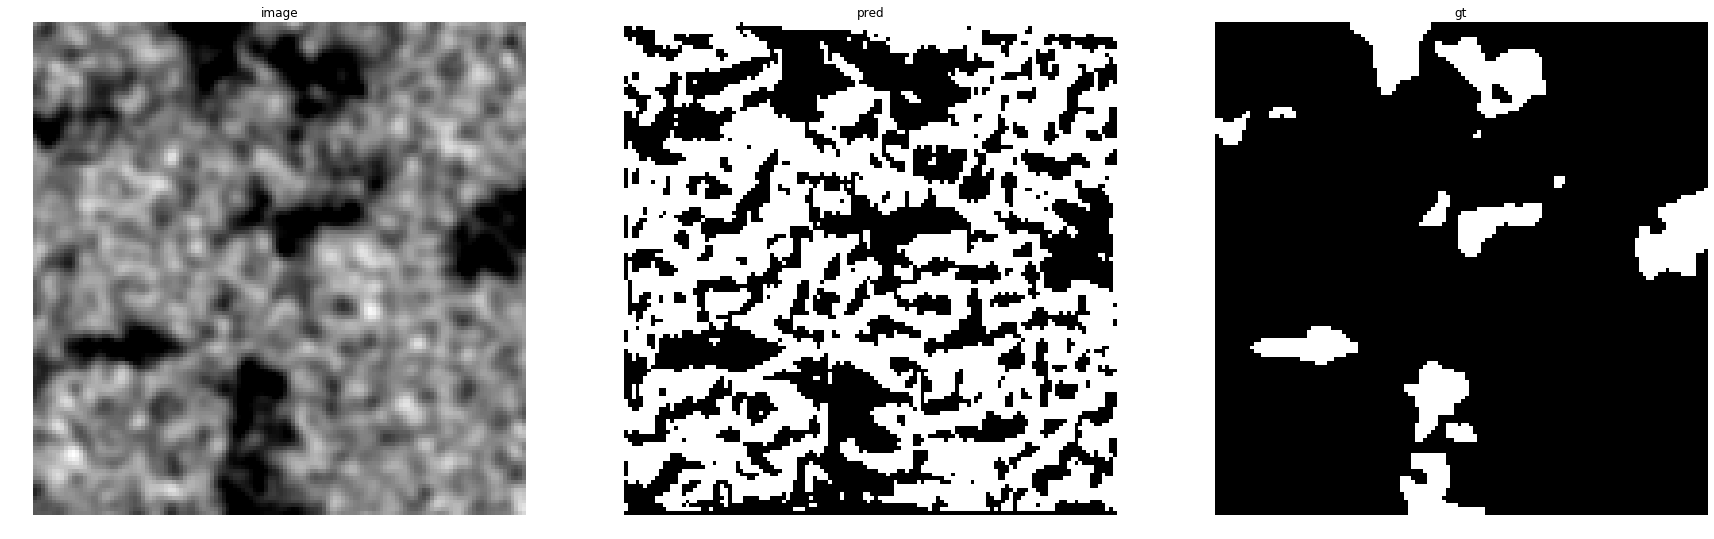

accuracy    : 0.337890625
precision   : 0.017058018321575233
recall      : 0.09671641791044776
f1          : 0.029001074113856065
pr_auc      : 0.0565274069872509
iou         : 0.014713896457765668


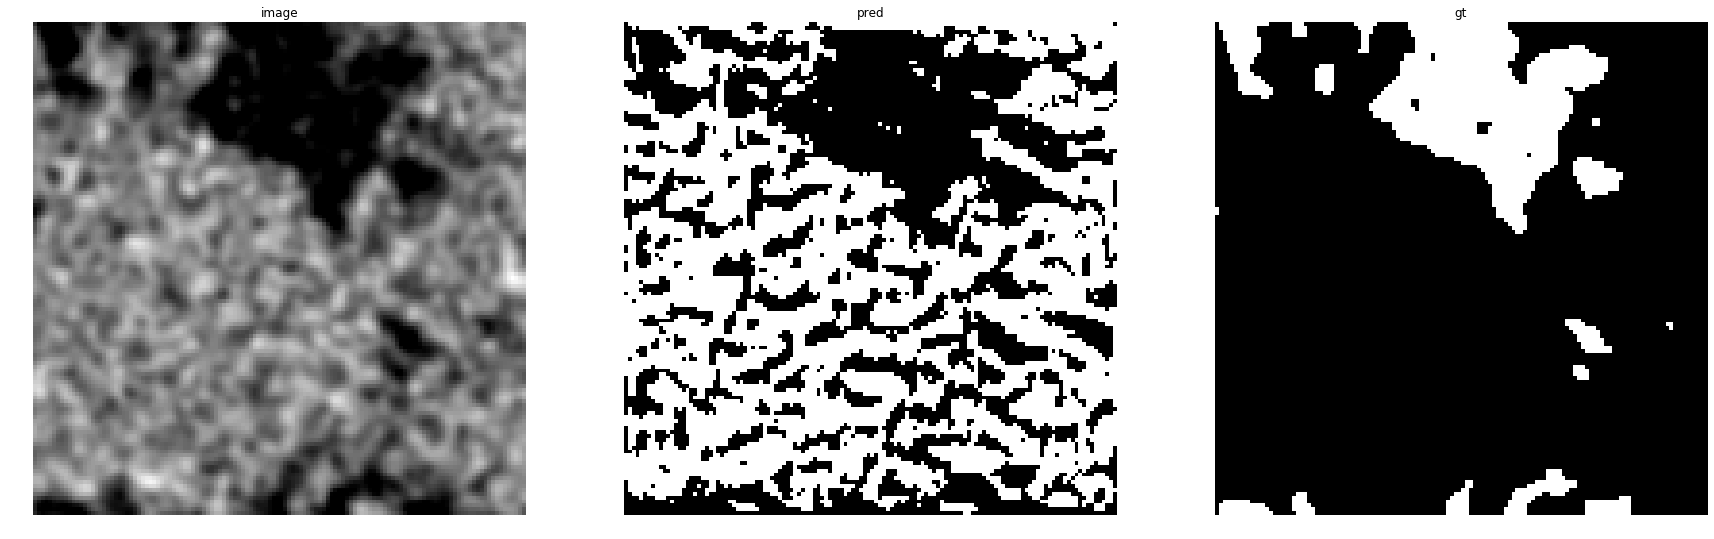

accuracy    : 0.32354736328125
precision   : 0.021574854889935383
recall      : 0.08397271952259165
f1          : 0.034329528622462316
pr_auc      : 0.07986887407679373
iou         : 0.0174645390070922
SoilAh-1


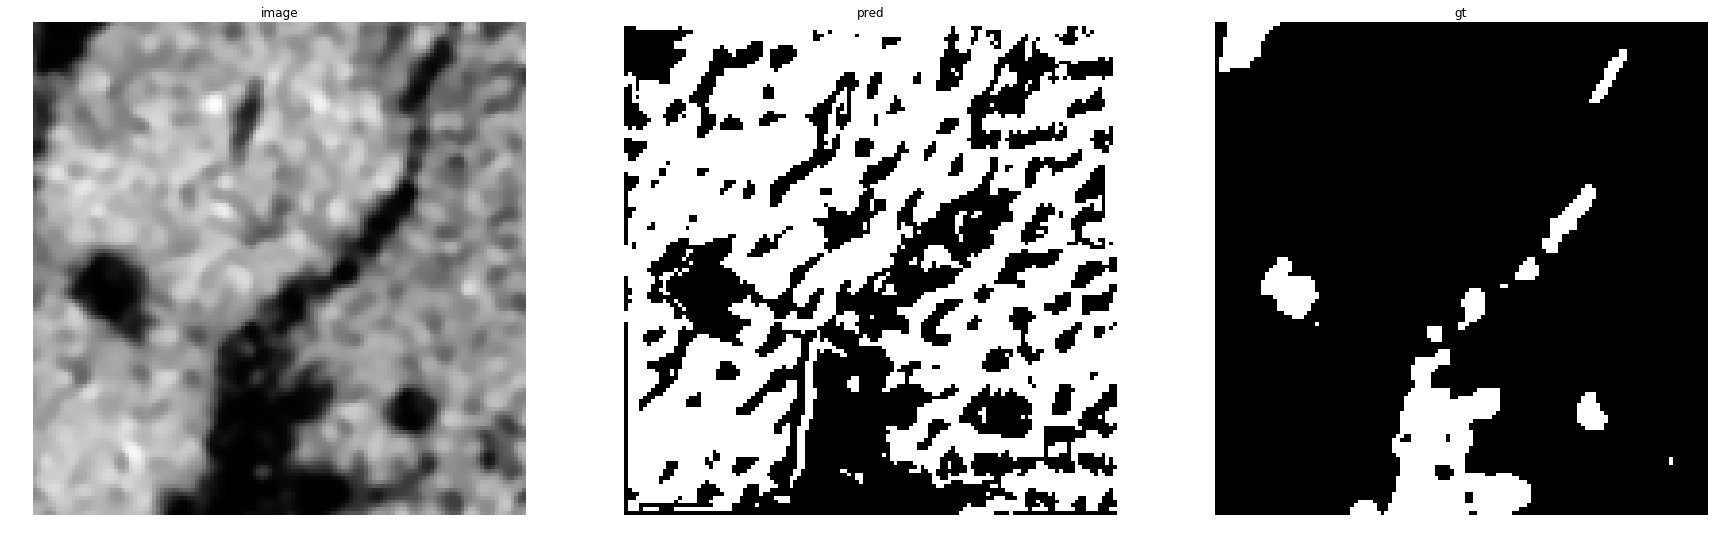

accuracy    : 0.302001953125
precision   : 0.007956777996070728
recall      : 0.057122708039492244
f1          : 0.01396792550439731
pr_auc      : 0.04699033419804293
iou         : 0.0070330815316488665


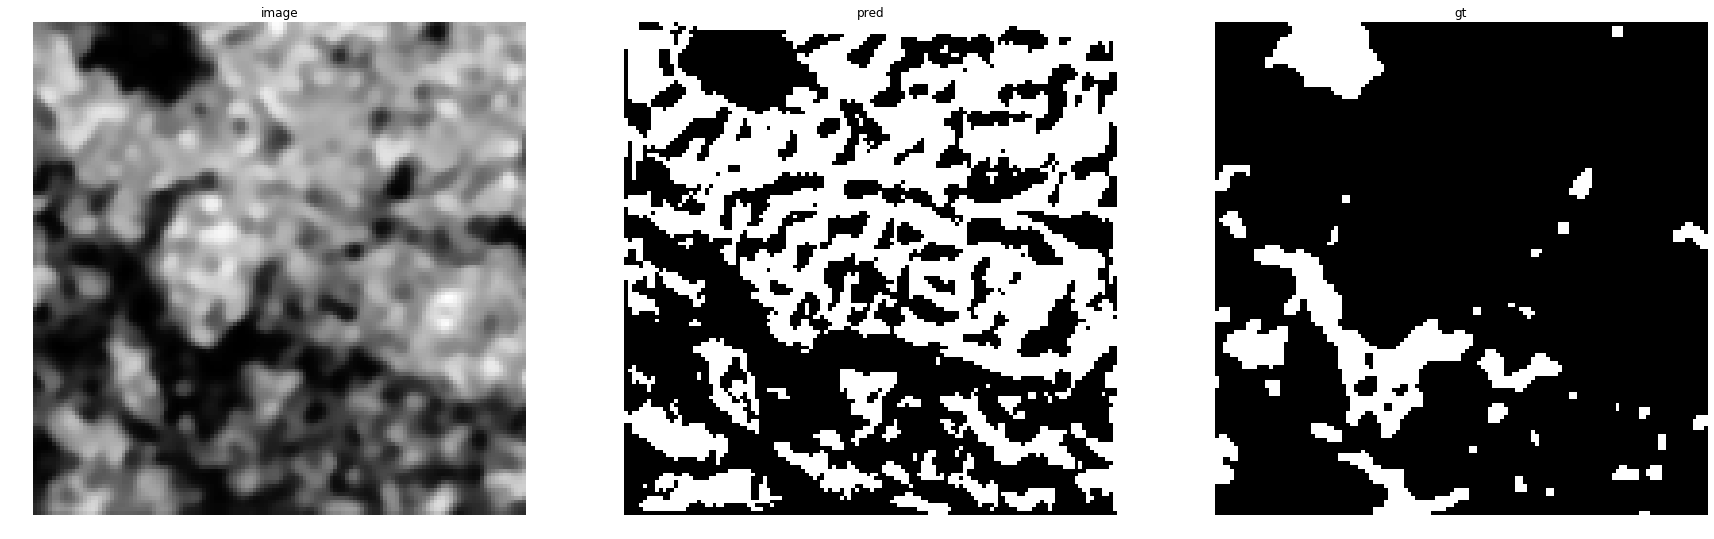

accuracy    : 0.39764404296875
precision   : 0.014894140817331364
recall      : 0.06089582284851535
f1          : 0.023934328948669766
pr_auc      : 0.06841805630558154
iou         : 0.012112112112112113


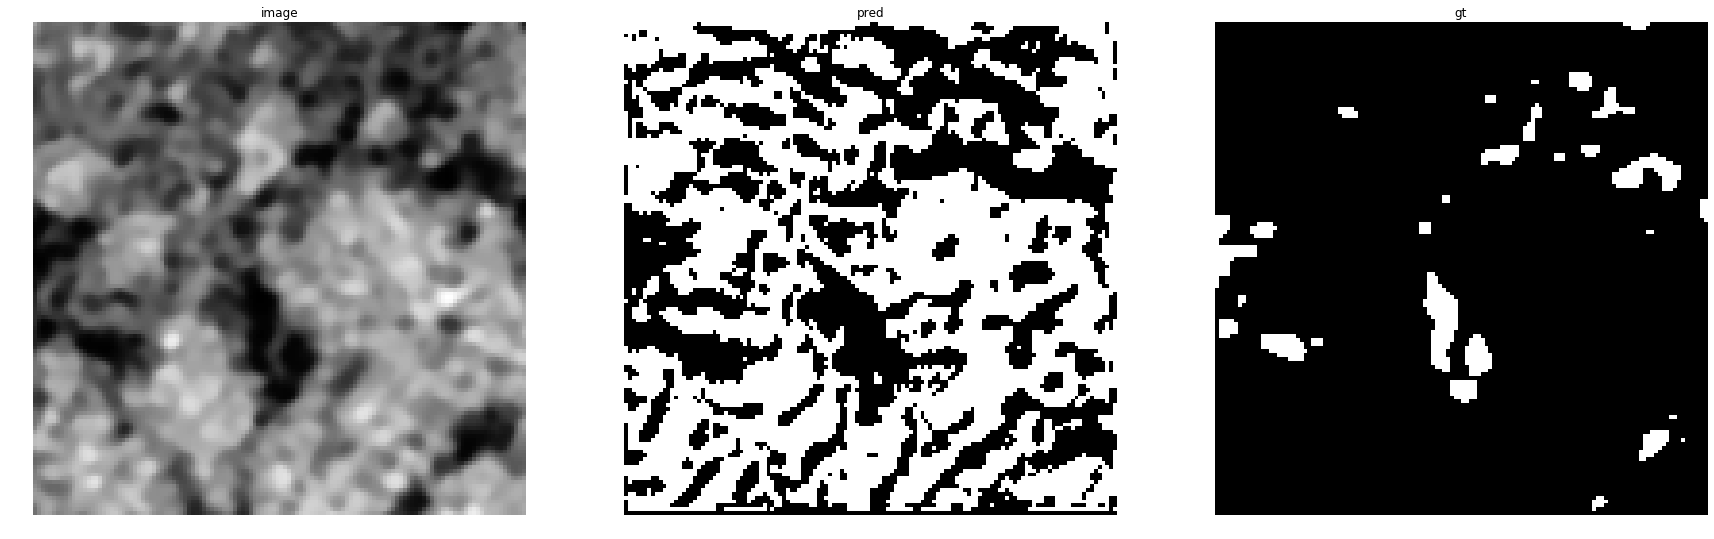

accuracy    : 0.385009765625
precision   : 0.006691449814126394
recall      : 0.08005082592121983
f1          : 0.012350519505979221
pr_auc      : 0.02635334592444197
iou         : 0.006213630535555775


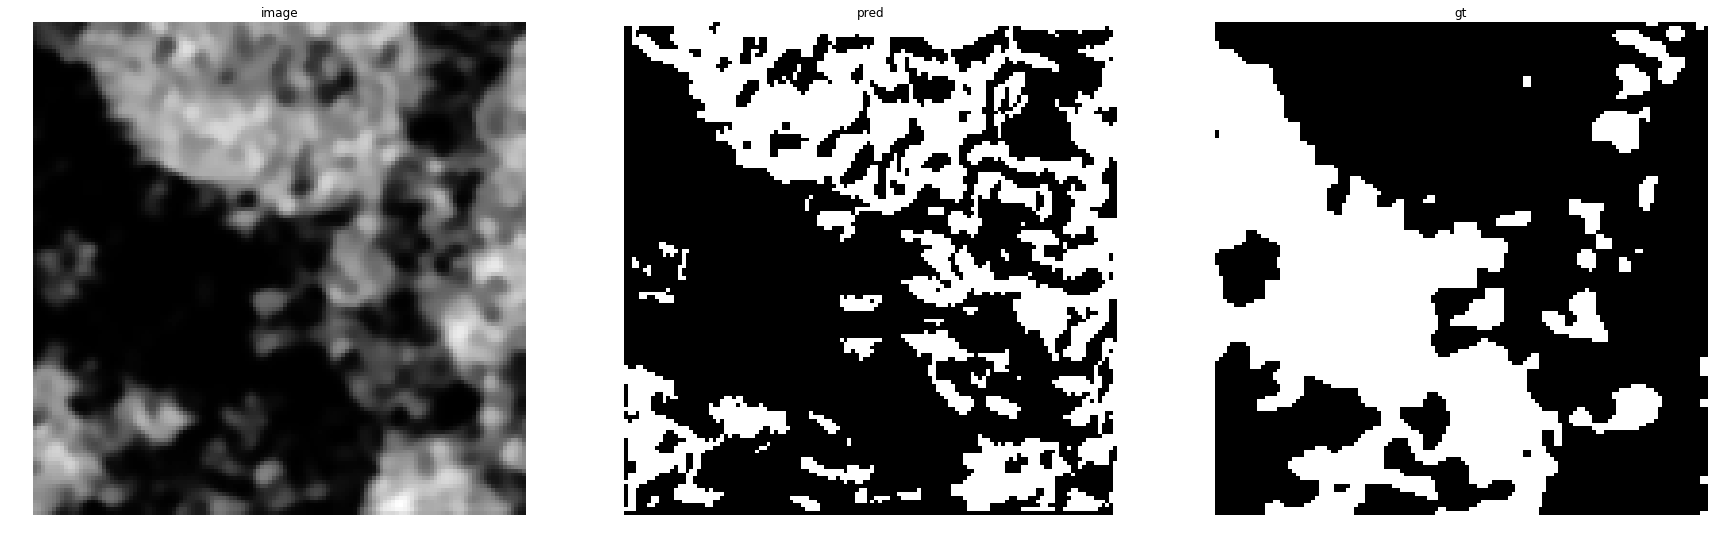

accuracy    : 0.29766845703125
precision   : 0.019059065934065936
recall      : 0.01879762912785775
f1          : 0.01892744479495268
pr_auc      : 0.22327406926527052
iou         : 0.009554140127388535


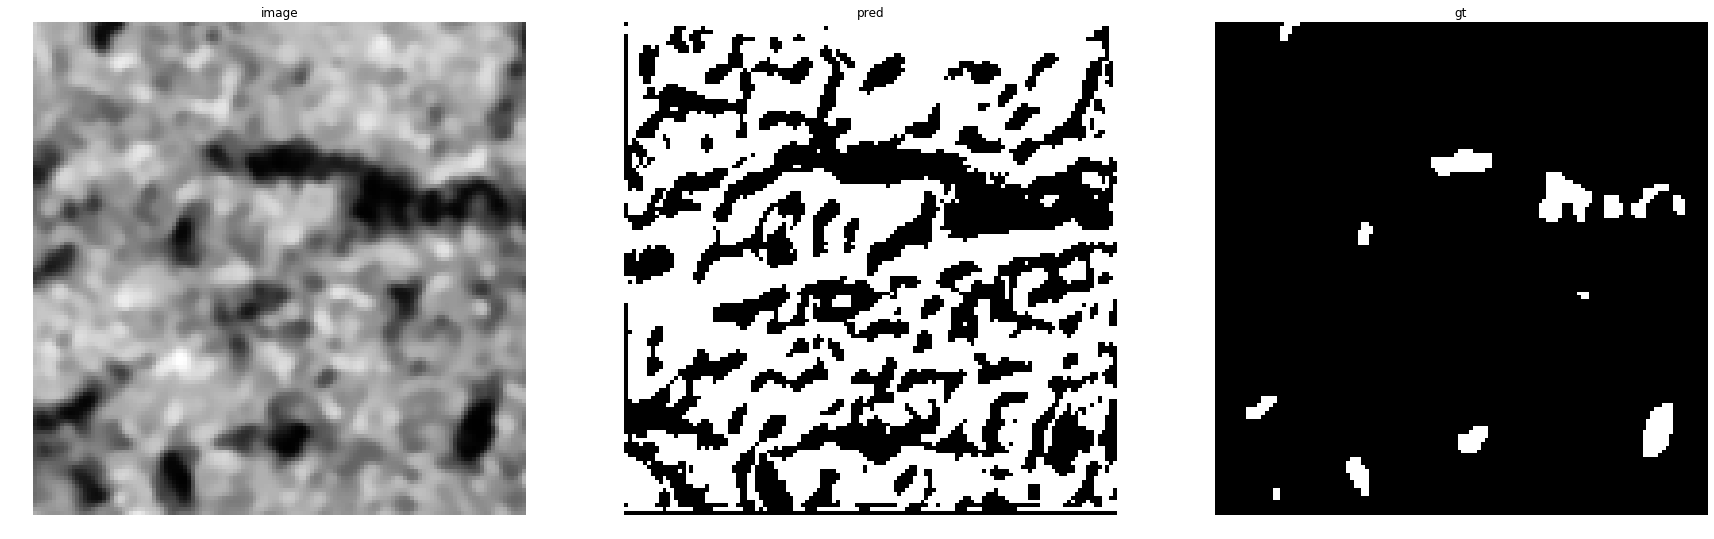

accuracy    : 0.34710693359375
precision   : 0.004375303840544483
recall      : 0.08964143426294821
f1          : 0.008343376286270512
pr_auc      : 0.01655775281460288
iou         : 0.00418916402904487


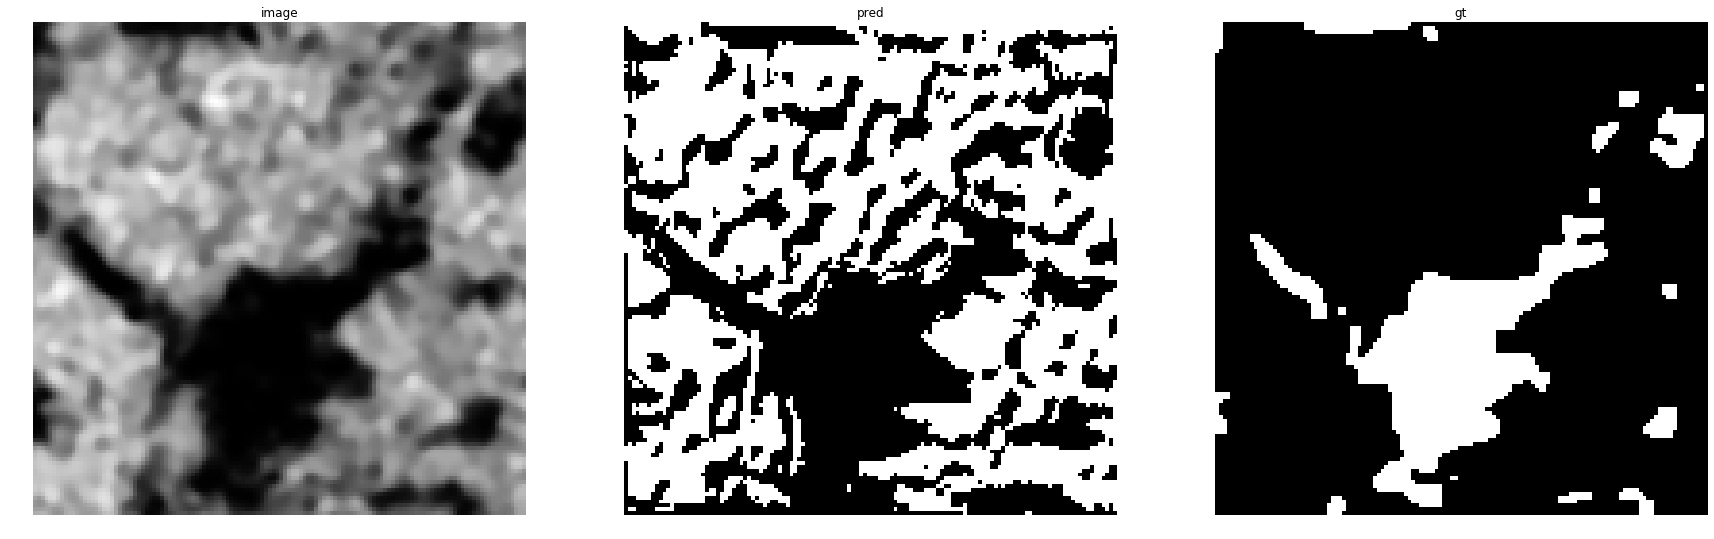

accuracy    : 0.32318115234375
precision   : 0.009224461906388794
recall      : 0.03279352226720648
f1          : 0.014398720113767664
pr_auc      : 0.084614766246199
iou         : 0.007251566696508505


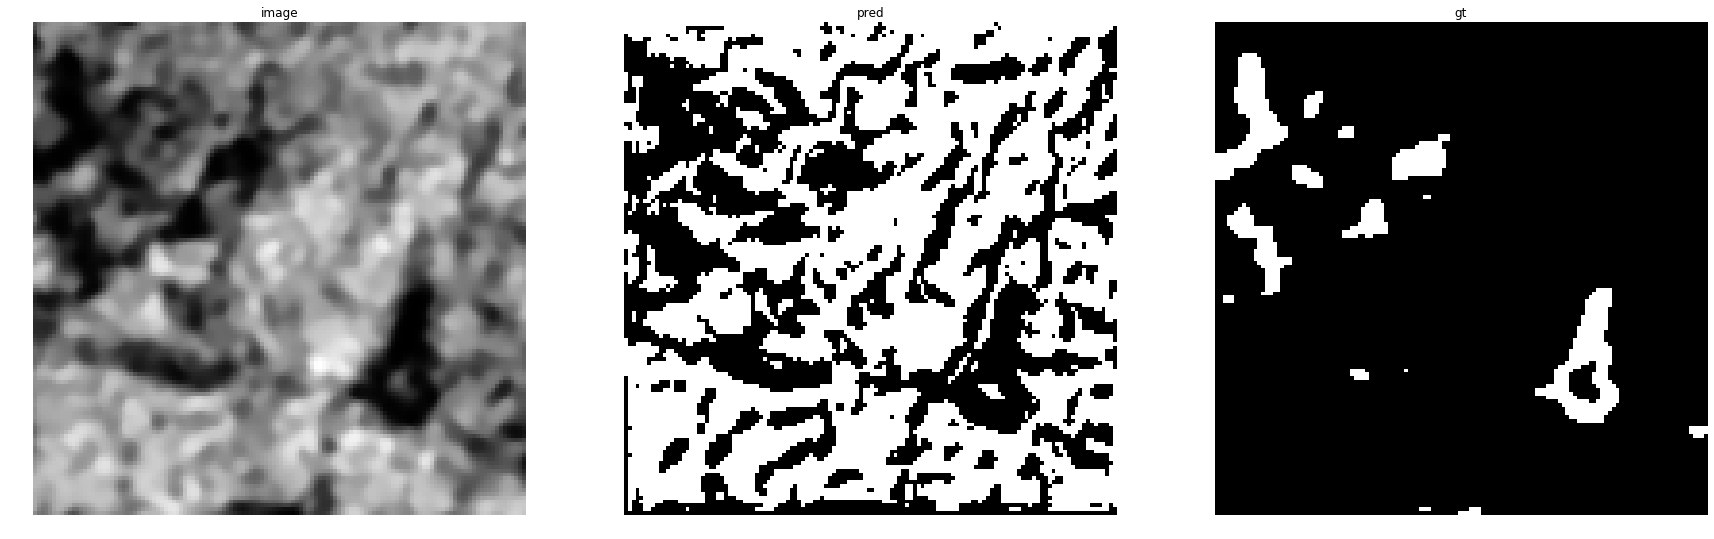

accuracy    : 0.3538818359375
precision   : 0.005682992353792105
recall      : 0.054027504911591355
f1          : 0.010284218399401645
pr_auc      : 0.03432248740745638
iou         : 0.00516868715346302


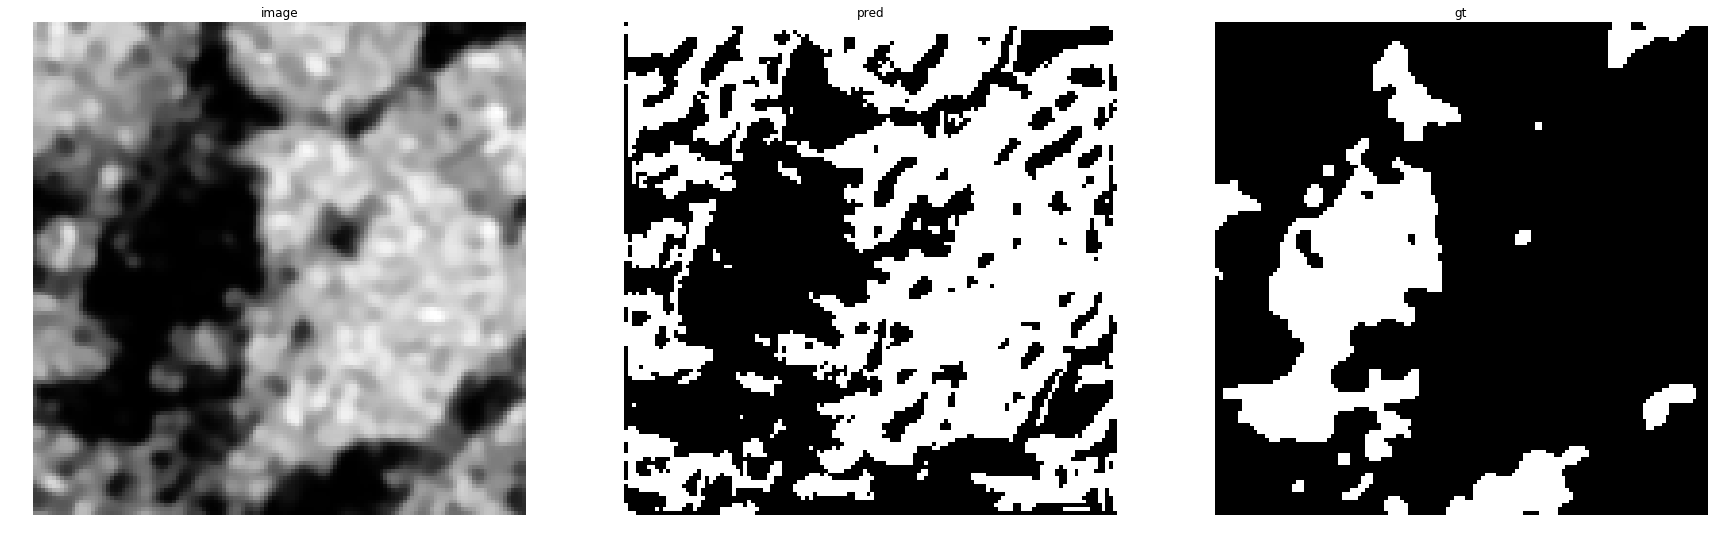

accuracy    : 0.29681396484375
precision   : 0.015450743494423791
recall      : 0.04183705567788613
f1          : 0.022567235089505387
pr_auc      : 0.11054114382051684
iou         : 0.01141239059550369


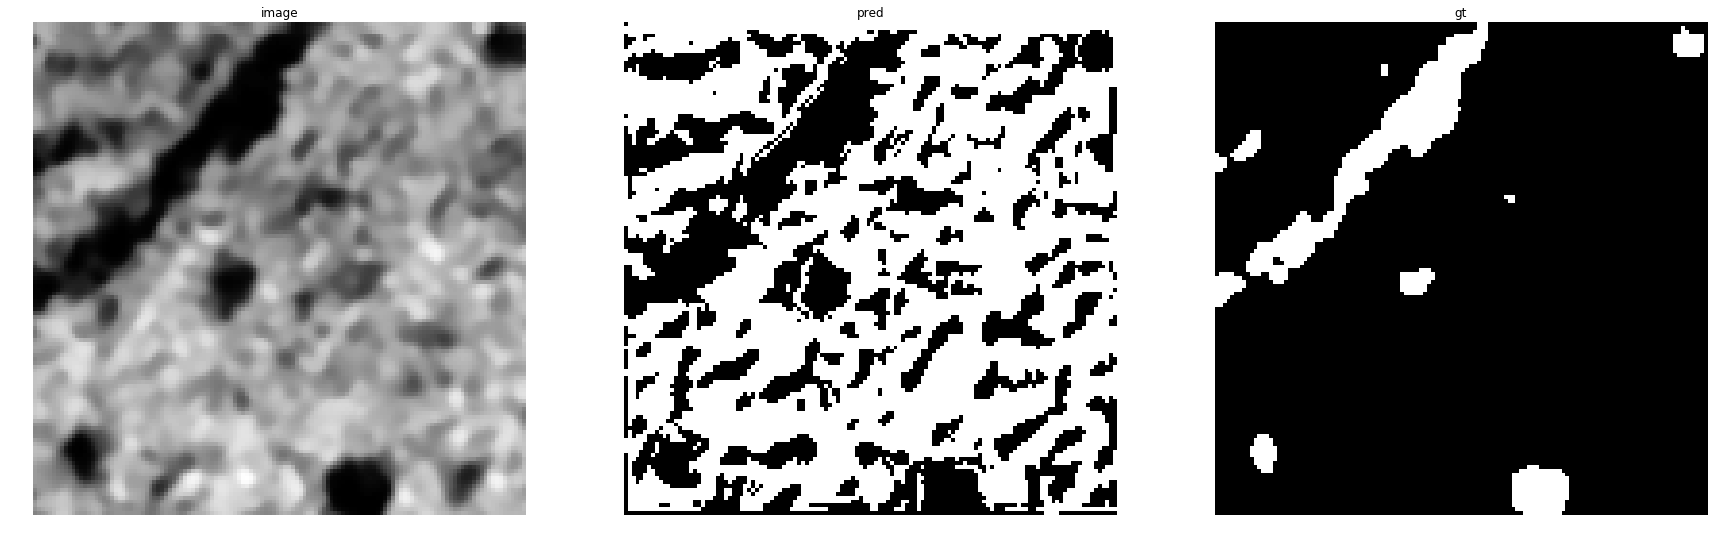

accuracy    : 0.29998779296875
precision   : 0.008169149447381067
recall      : 0.06888168557536467
f1          : 0.014606065813214194
pr_auc      : 0.0407314671391692
iou         : 0.007356759563787433


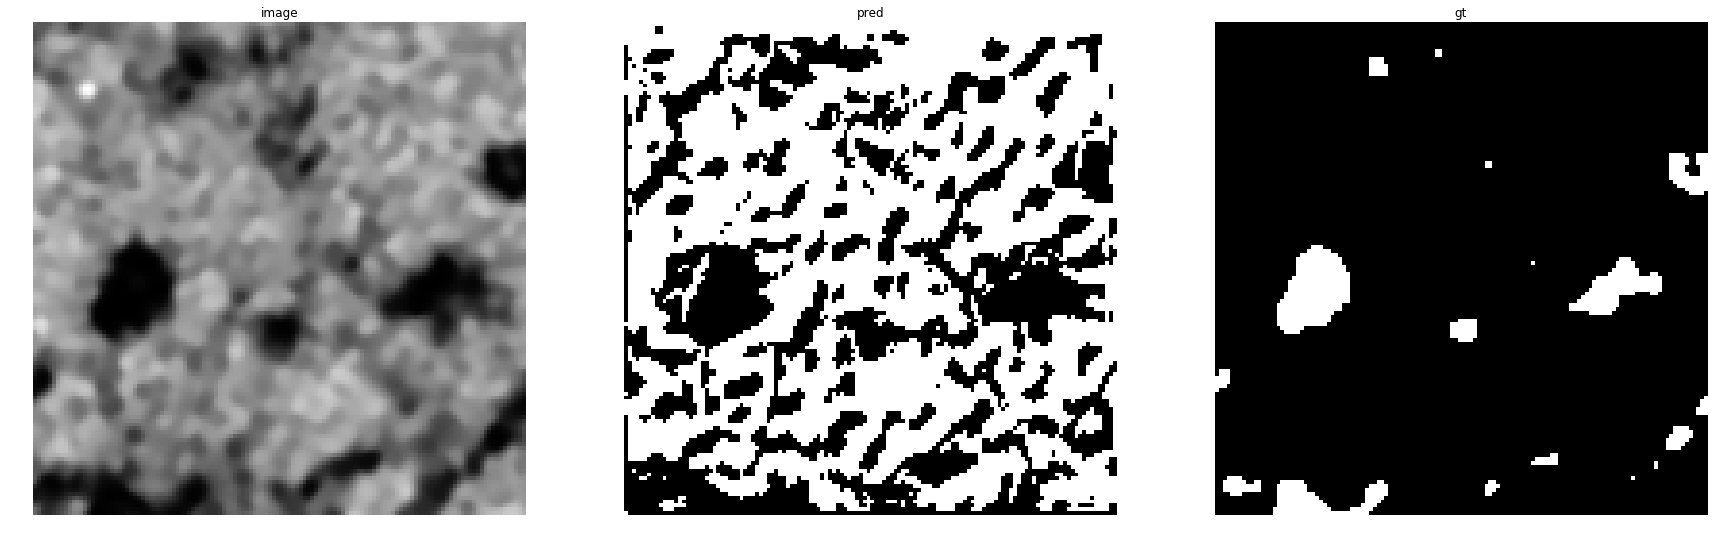

accuracy    : 0.33099365234375
precision   : 0.005980978527306599
recall      : 0.06900452488687783
f1          : 0.01100784986014617
pr_auc      : 0.02925218019020251
iou         : 0.005534385773906732
SoilB-2


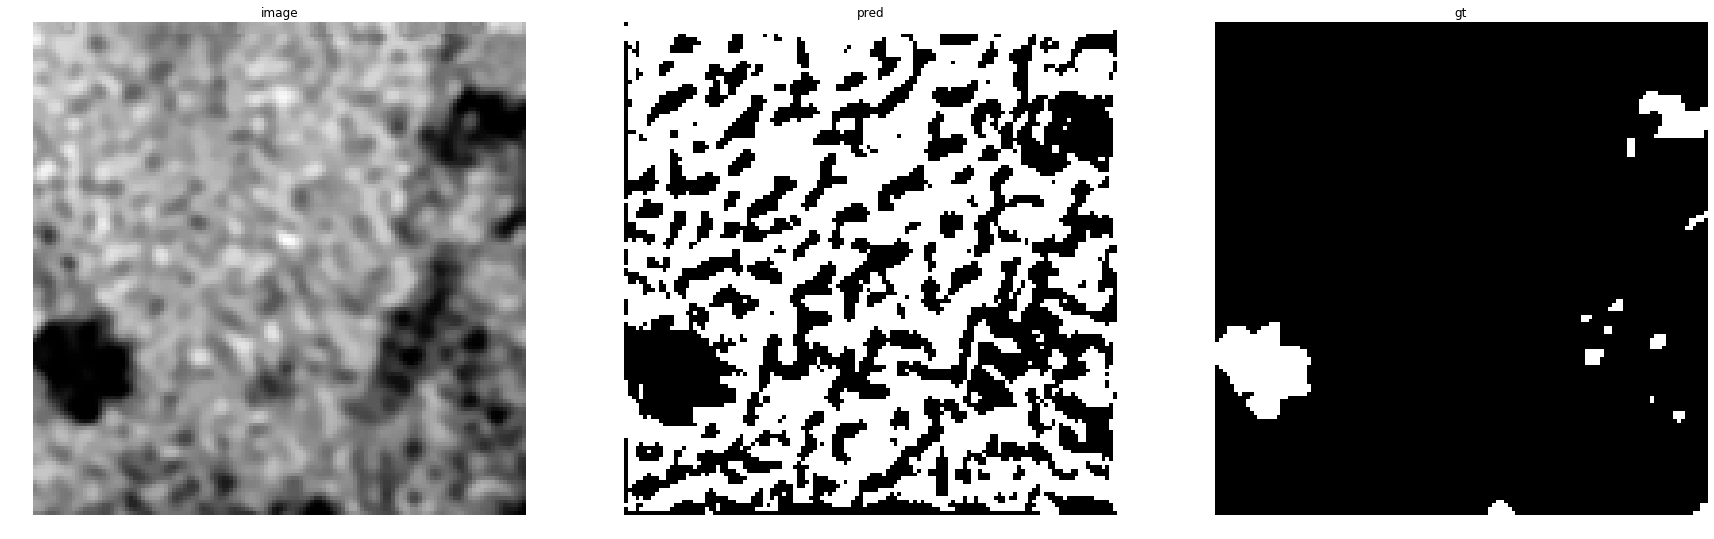

accuracy    : 0.3499755859375
precision   : 0.004263335316279992
recall      : 0.06615384615384616
f1          : 0.008010432190760058
pr_auc      : 0.02124078245922925
iou         : 0.004021322360422706


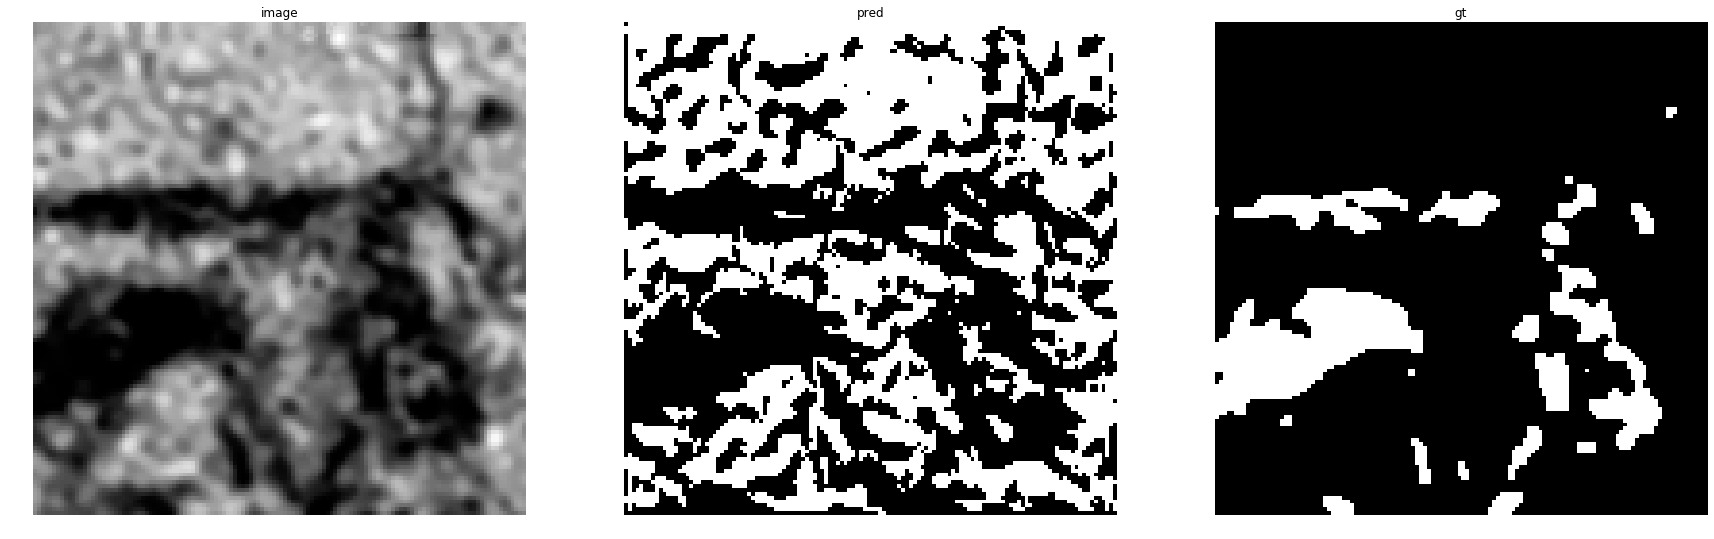

accuracy    : 0.3819580078125
precision   : 0.010430895318514839
recall      : 0.03748326639892905
f1          : 0.01632018651641733
pr_auc      : 0.07694198620735924
iou         : 0.008227228207639568


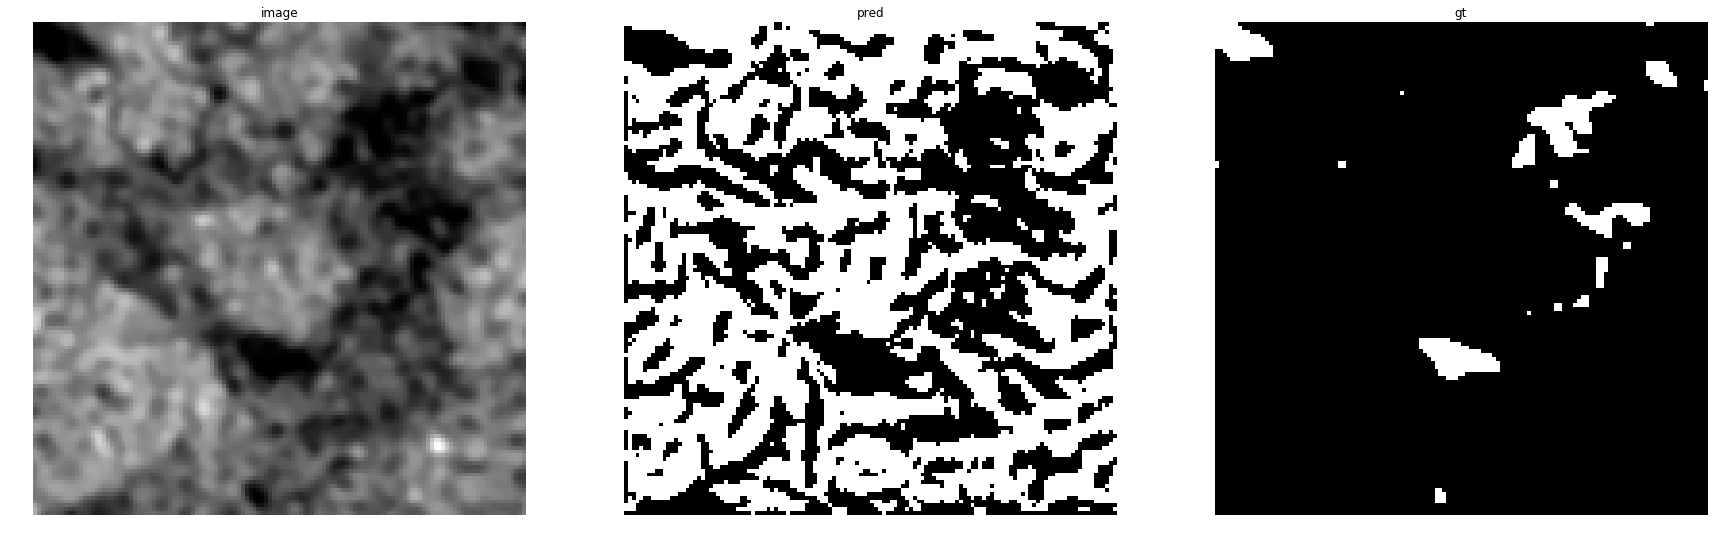

accuracy    : 0.401123046875
precision   : 0.005084929135562047
recall      : 0.07088989441930618
f1          : 0.009489198465576418
pr_auc      : 0.021723109764650046
iou         : 0.004767217770564966


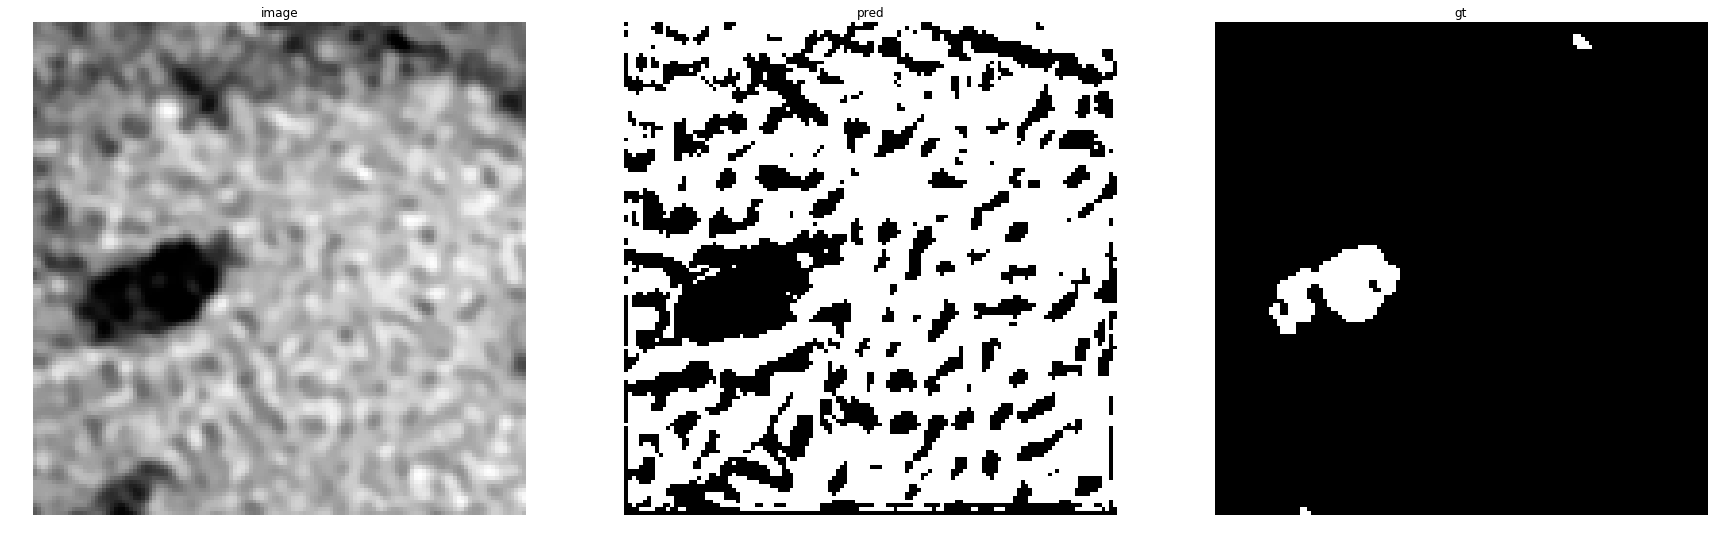

accuracy    : 0.27618408203125
precision   : 0.0010484927916120576
recall      : 0.0273972602739726
f1          : 0.002019691996970462
pr_auc      : 0.01405471952531102
iou         : 0.0010108668182966893


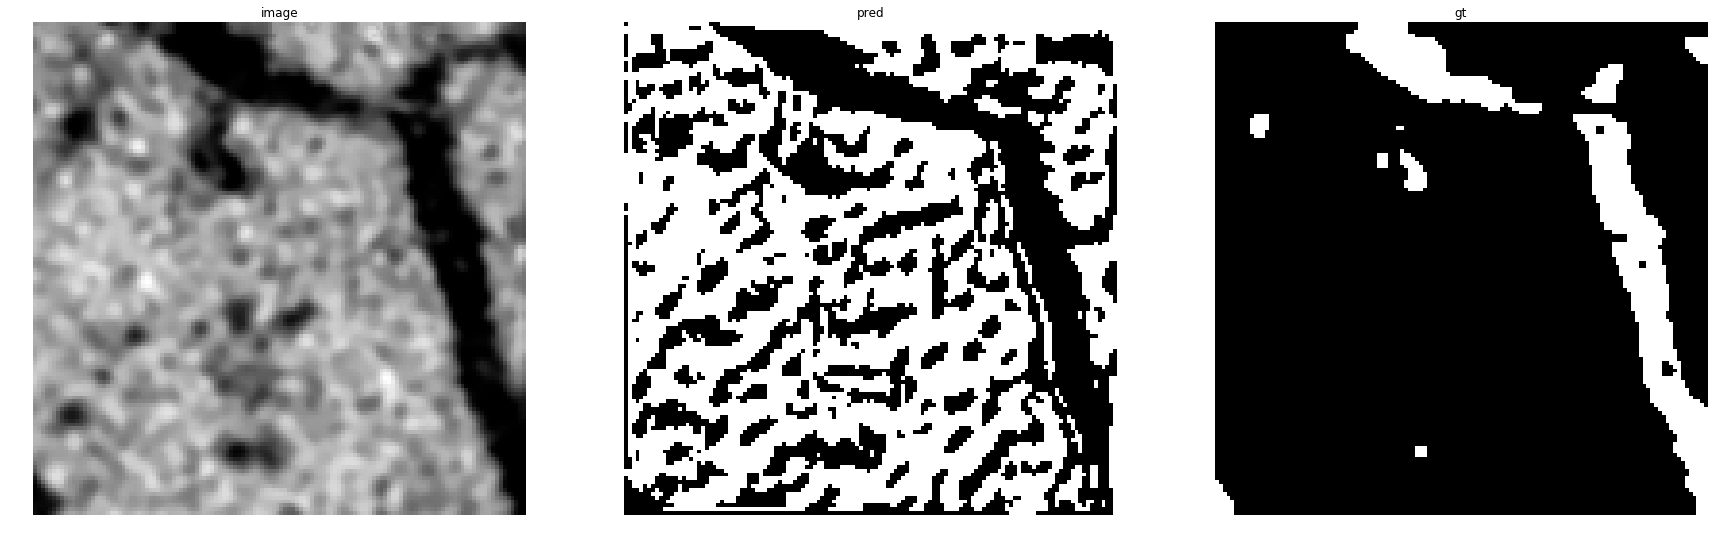

accuracy    : 0.33258056640625
precision   : 0.014939505523408732
recall      : 0.08284714119019837
f1          : 0.025314199126481862
pr_auc      : 0.05835267812638932
iou         : 0.012819355421142908


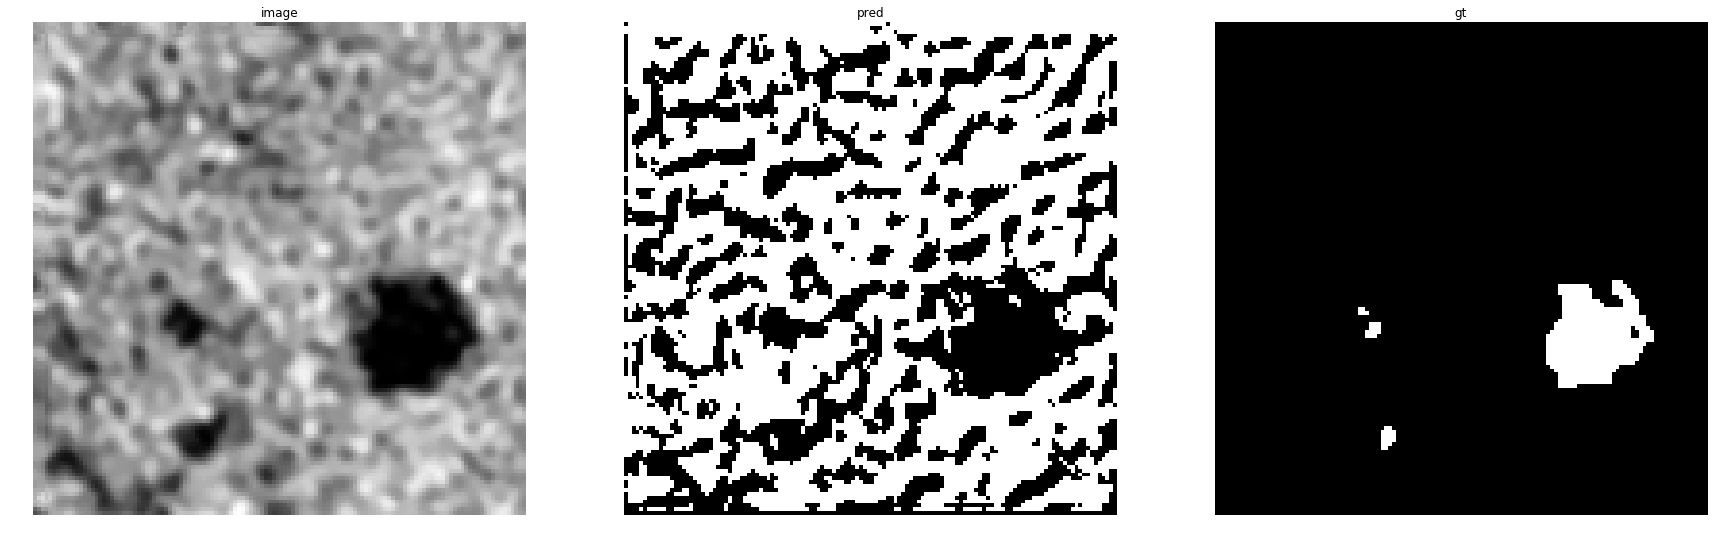

accuracy    : 0.343017578125
precision   : 0.0009781864423359092
recall      : 0.017825311942959002
f1          : 0.0018545994065281898
pr_auc      : 0.01822035324912547
iou         : 0.0009281603861147206


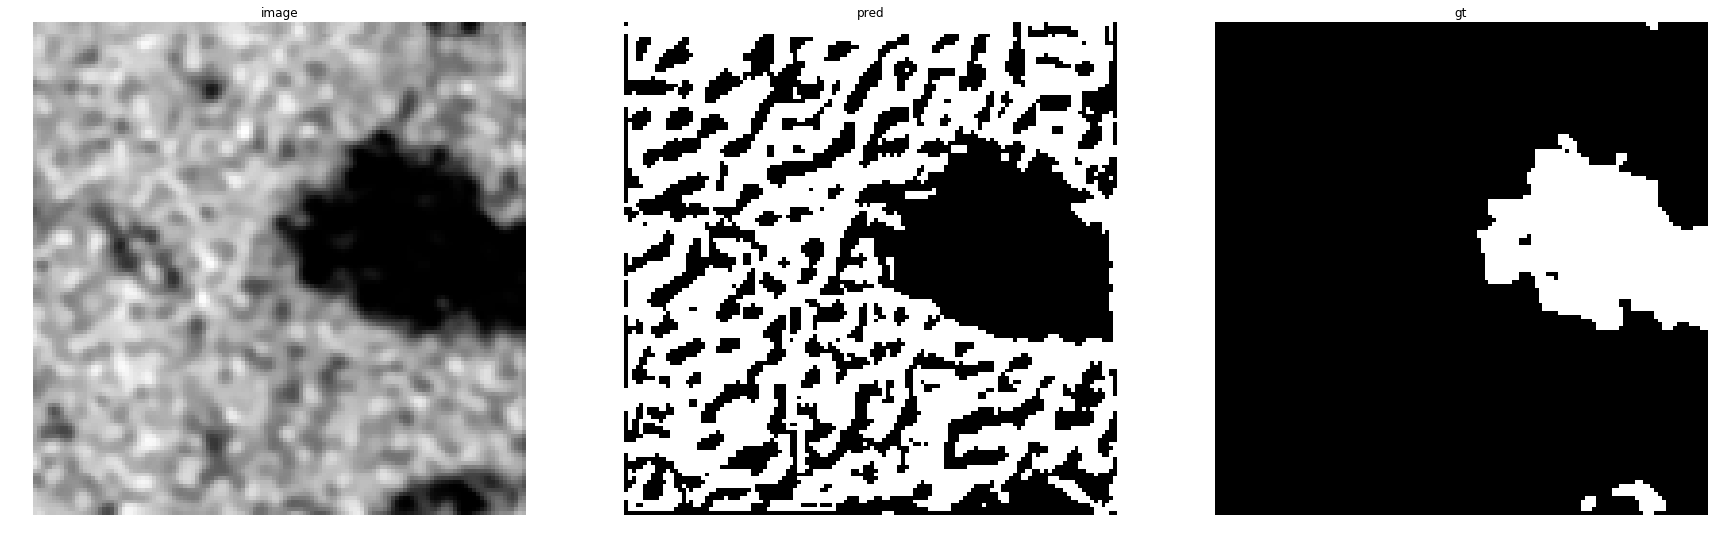

accuracy    : 0.31854248046875
precision   : 0.00815450643776824
recall      : 0.03805708562844266
f1          : 0.013431121321905097
pr_auc      : 0.0672204501310453
iou         : 0.006760964327017169


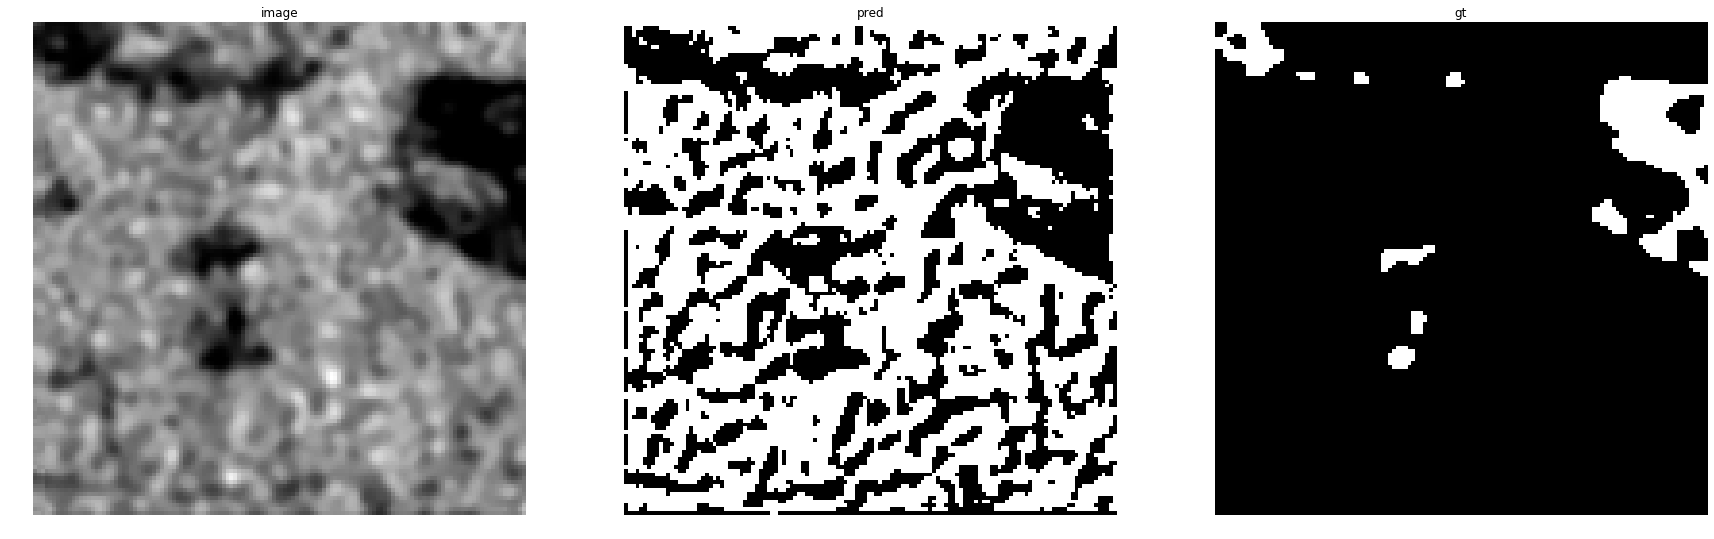

accuracy    : 0.3572998046875
precision   : 0.008069522036002483
recall      : 0.07647058823529412
f1          : 0.0145985401459854
pr_auc      : 0.035229840957926646
iou         : 0.007352941176470588


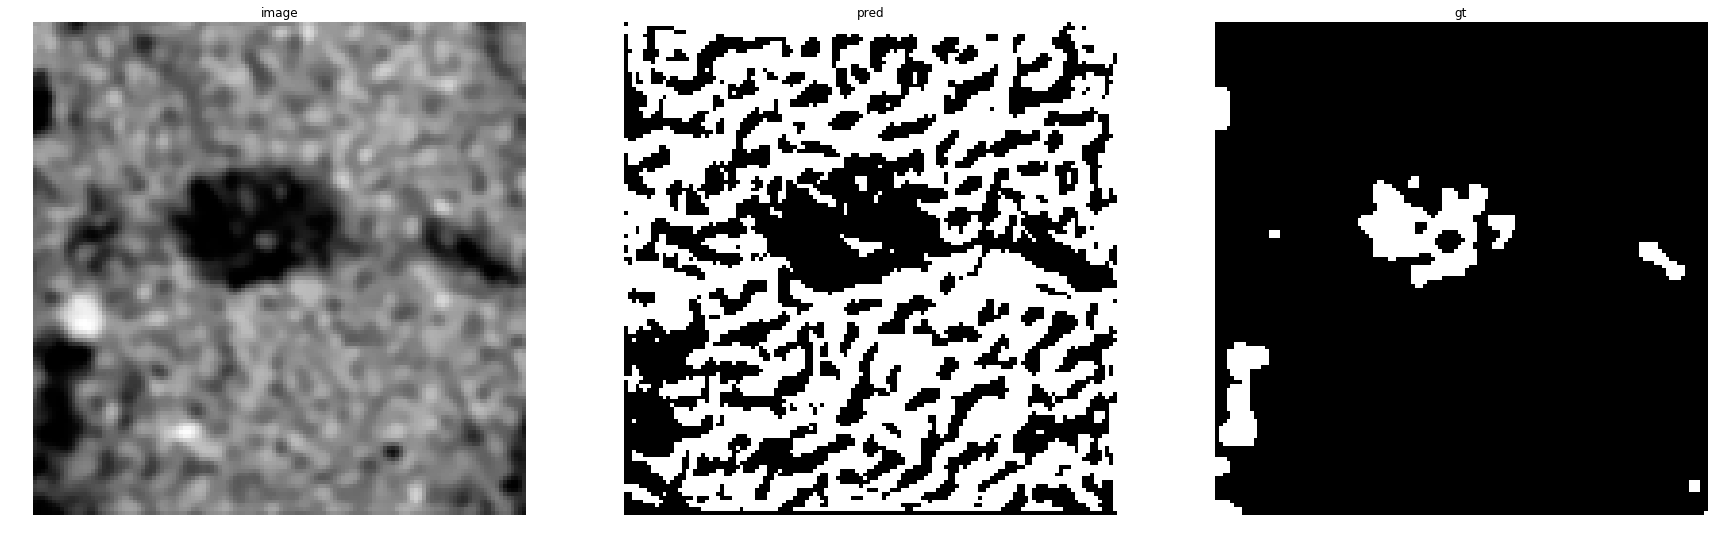

accuracy    : 0.3690185546875
precision   : 0.003468937243771681
recall      : 0.037037037037037035
f1          : 0.006343713956170703
pr_auc      : 0.029157994106268872
iou         : 0.003181949667341626


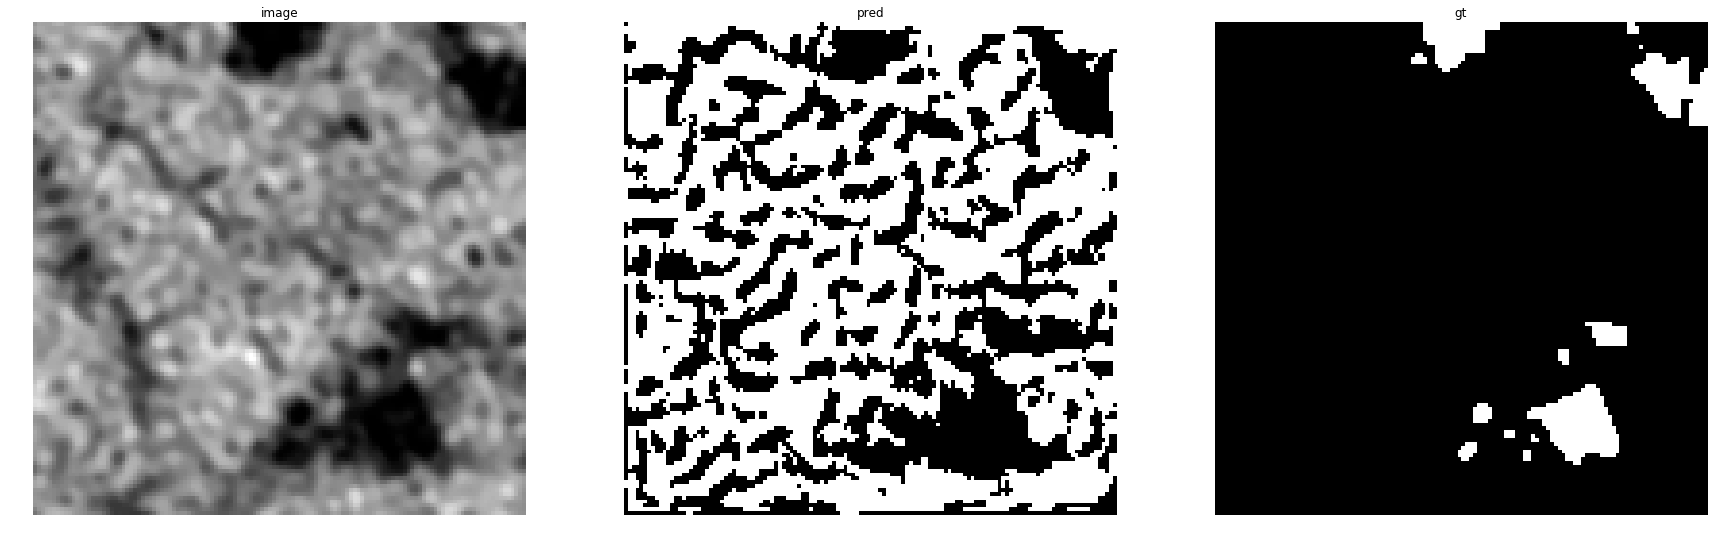

accuracy    : 0.36053466796875
precision   : 0.008533116619260463
recall      : 0.10486891385767791
f1          : 0.015782057303898544
pr_auc      : 0.027199173871048952
iou         : 0.007953792254521351
TeTree_subset1


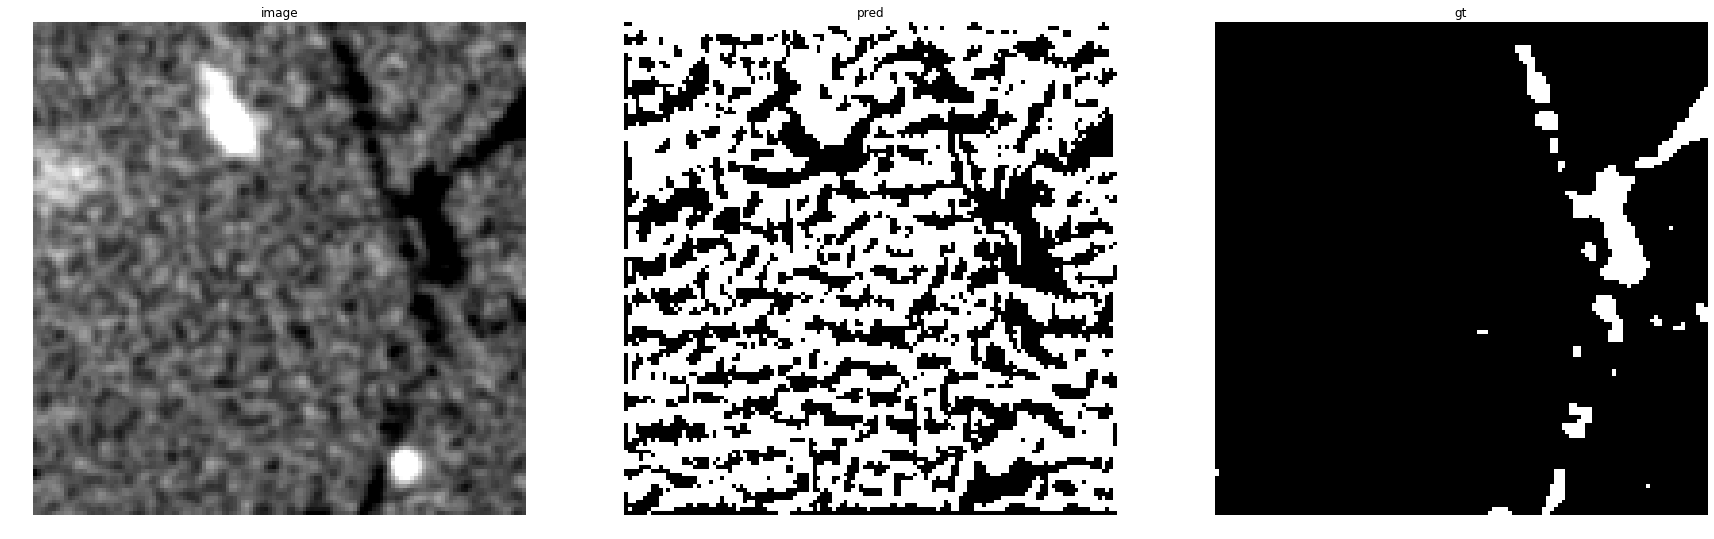

accuracy    : 0.35772705078125
precision   : 0.012519872813990461
recall      : 0.17721518987341772
f1          : 0.023387470997679814
pr_auc      : 0.024990000844676875
iou         : 0.011832096910508029


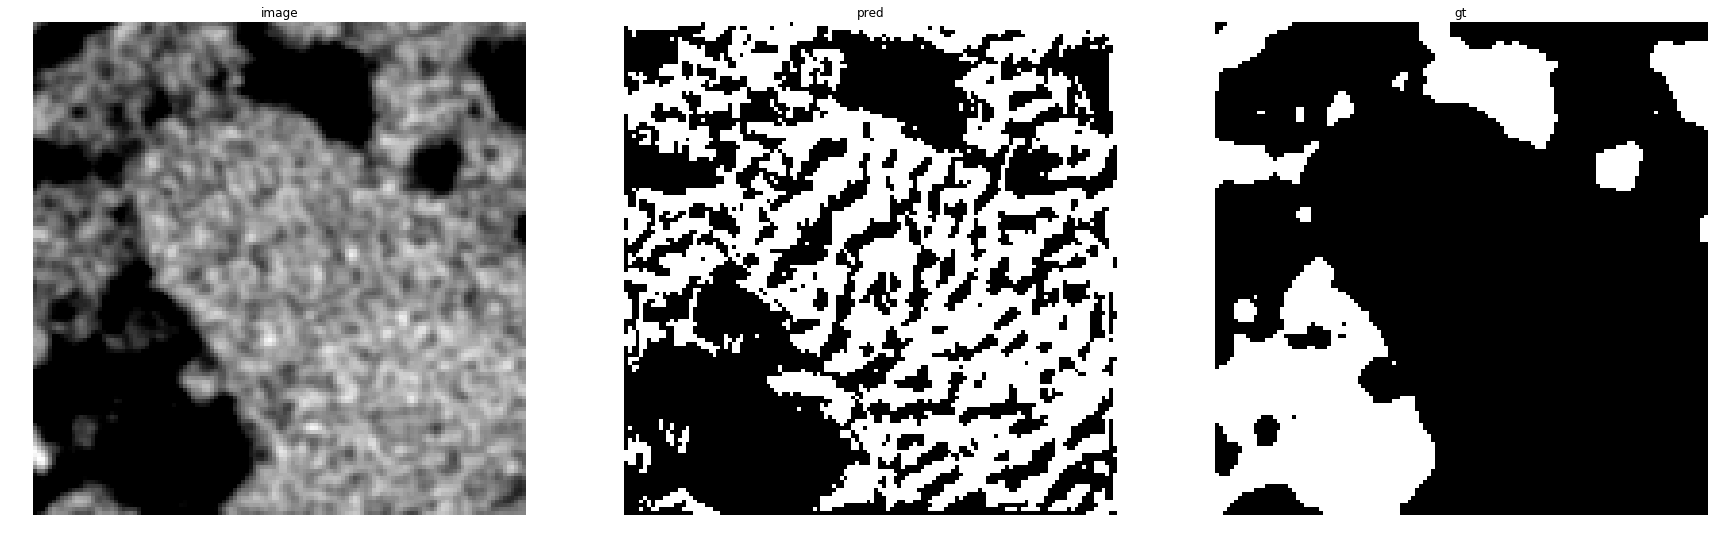

accuracy    : 0.3087158203125
precision   : 0.03469992590763151
recall      : 0.07414248021108179
f1          : 0.04727456258411844
pr_auc      : 0.13530717523215754
iou         : 0.024209528732661325


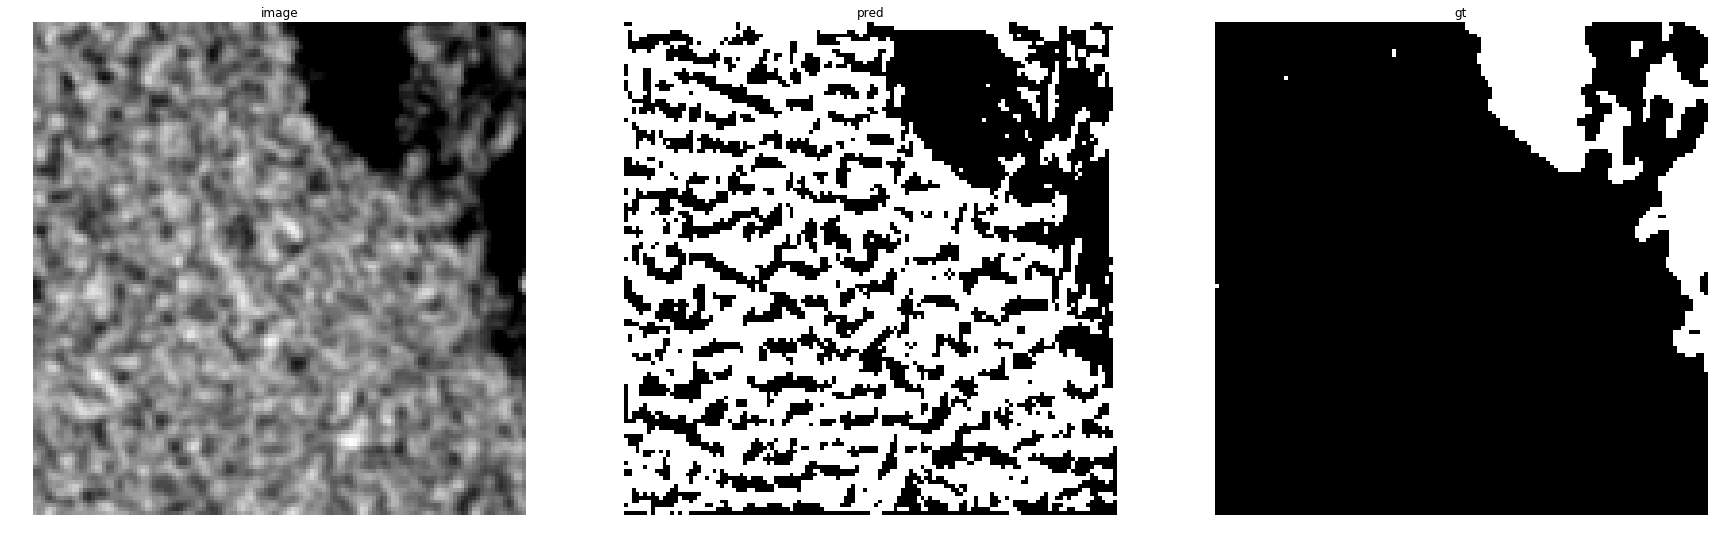

accuracy    : 0.332763671875
precision   : 0.02939664919313393
recall      : 0.1611267605633803
f1          : 0.04972183588317107
pr_auc      : 0.06547461045815595
iou         : 0.025494740595471563


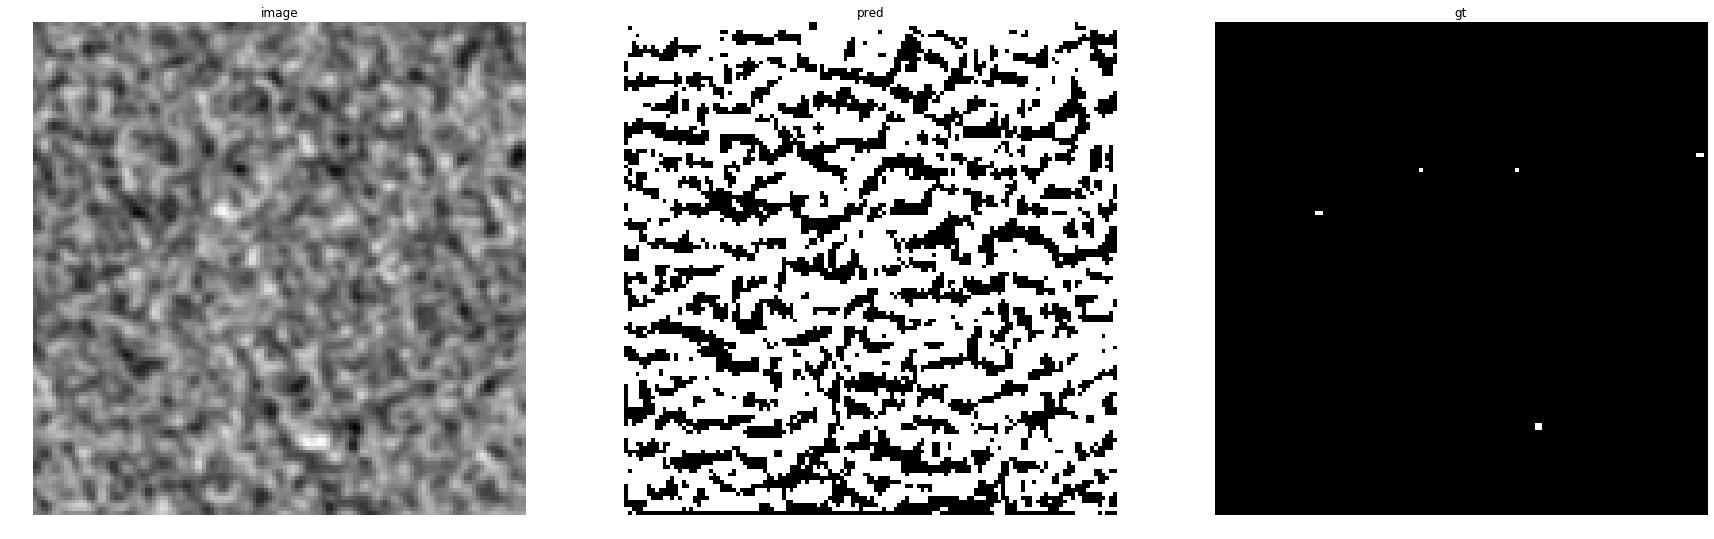

accuracy    : 0.33770751953125
precision   : 0.0
recall      : 0.0
f1          : 0.0
pr_auc      : 0.00035206720845618576
iou         : 0.0


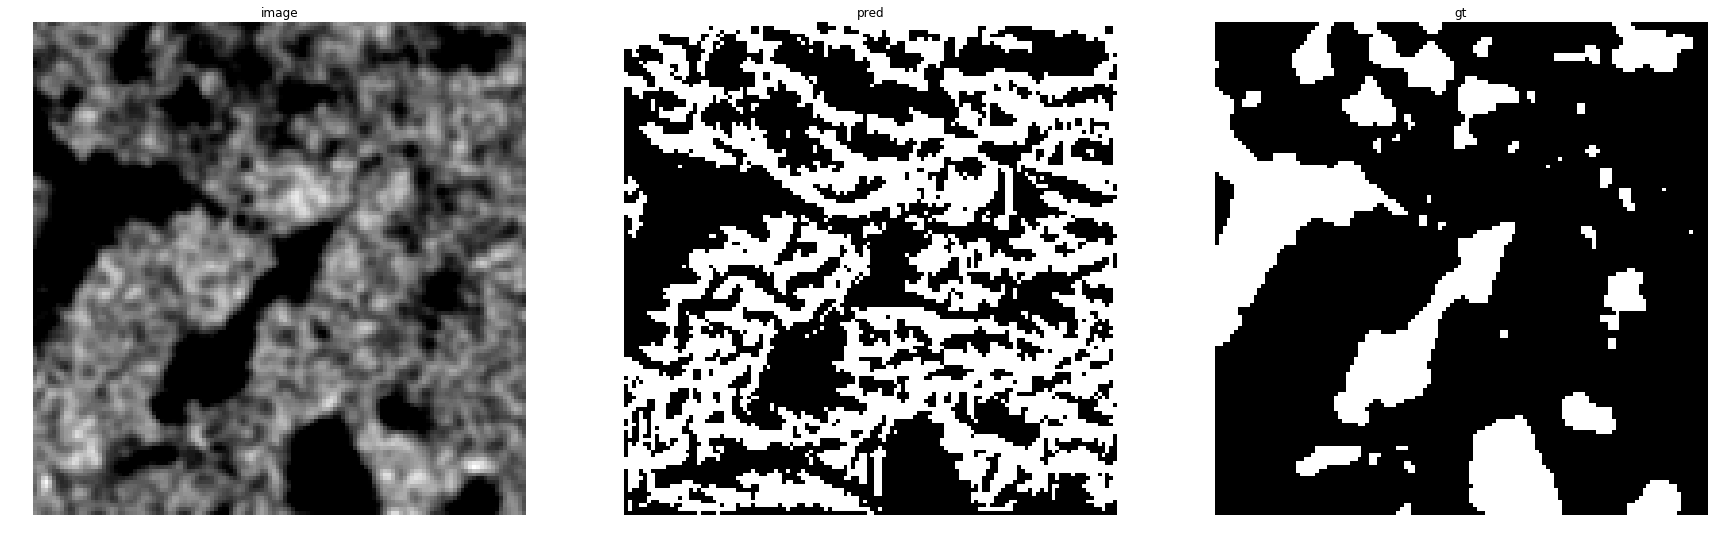

accuracy    : 0.333251953125
precision   : 0.03690976199567265
recall      : 0.07951741157115437
f1          : 0.05041724617524339
pr_auc      : 0.13079473374338116
iou         : 0.025860531478509006


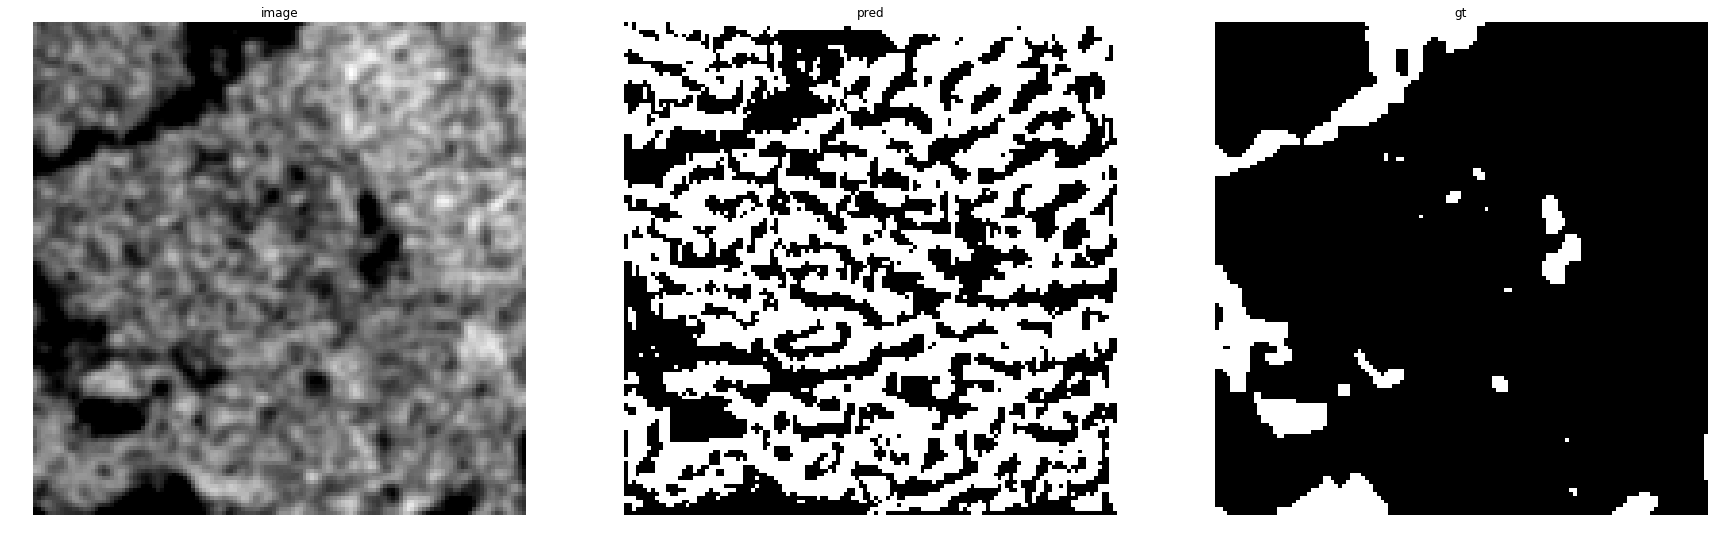

accuracy    : 0.3575439453125
precision   : 0.019643236355914206
recall      : 0.12516914749661706
f1          : 0.03395741556534508
pr_auc      : 0.05047835410289874
iou         : 0.017271963402109982


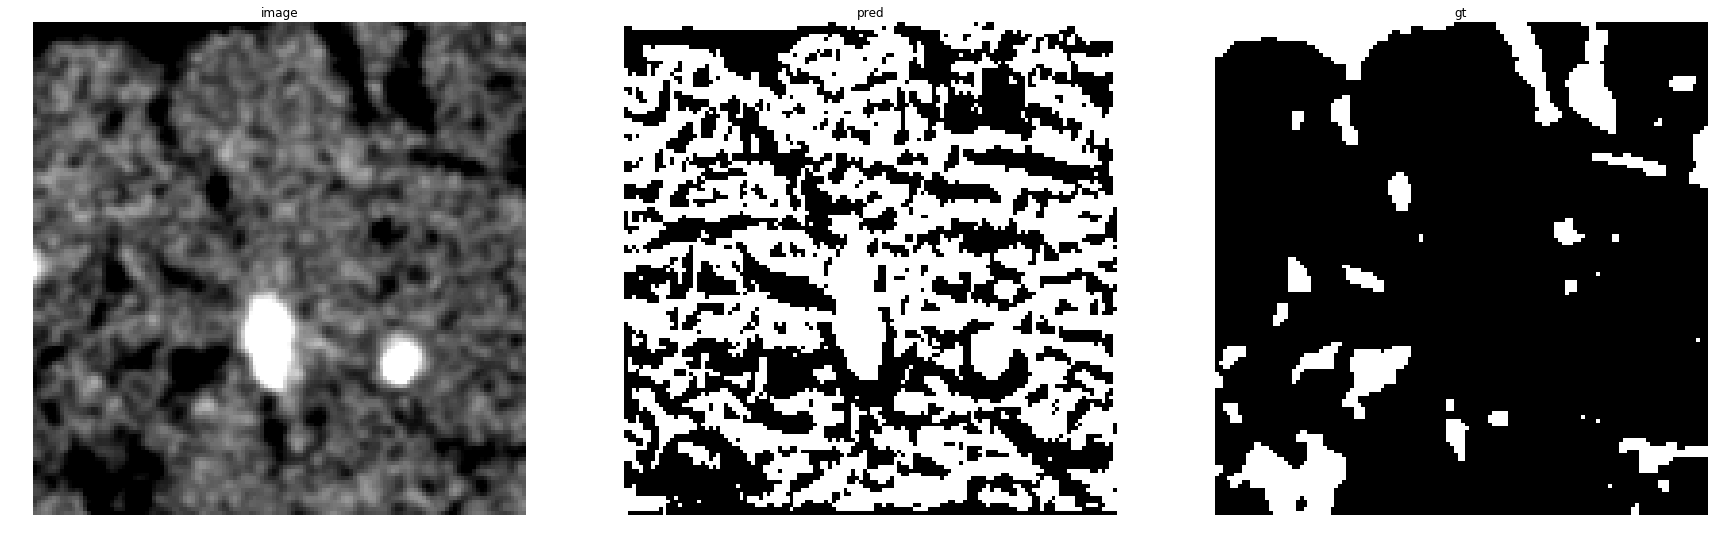

accuracy    : 0.3626708984375
precision   : 0.037684325505188423
recall      : 0.17450682852807284
f1          : 0.06198347107438017
pr_auc      : 0.07164727309059823
iou         : 0.031982942430703626


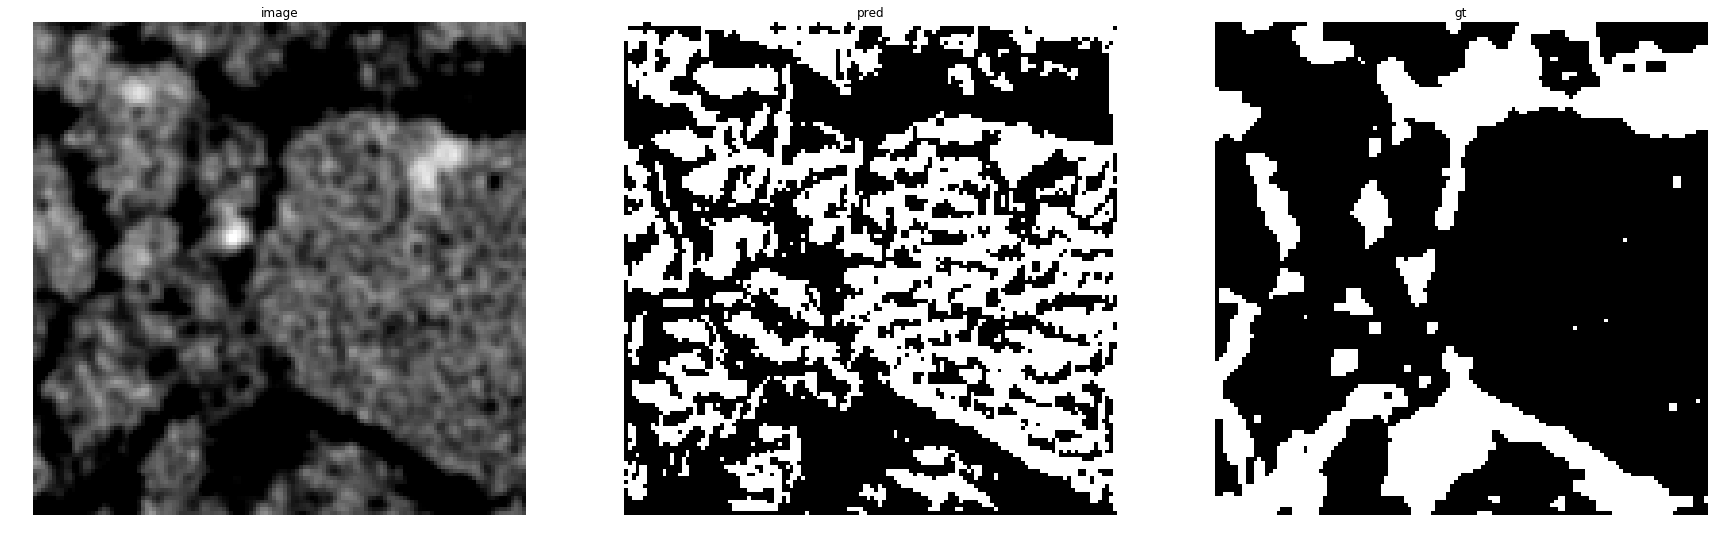

accuracy    : 0.3292236328125
precision   : 0.05818133404340301
recall      : 0.10039053526303698
f1          : 0.0736682400539447
pr_auc      : 0.15969385501088804
iou         : 0.03824275837927715


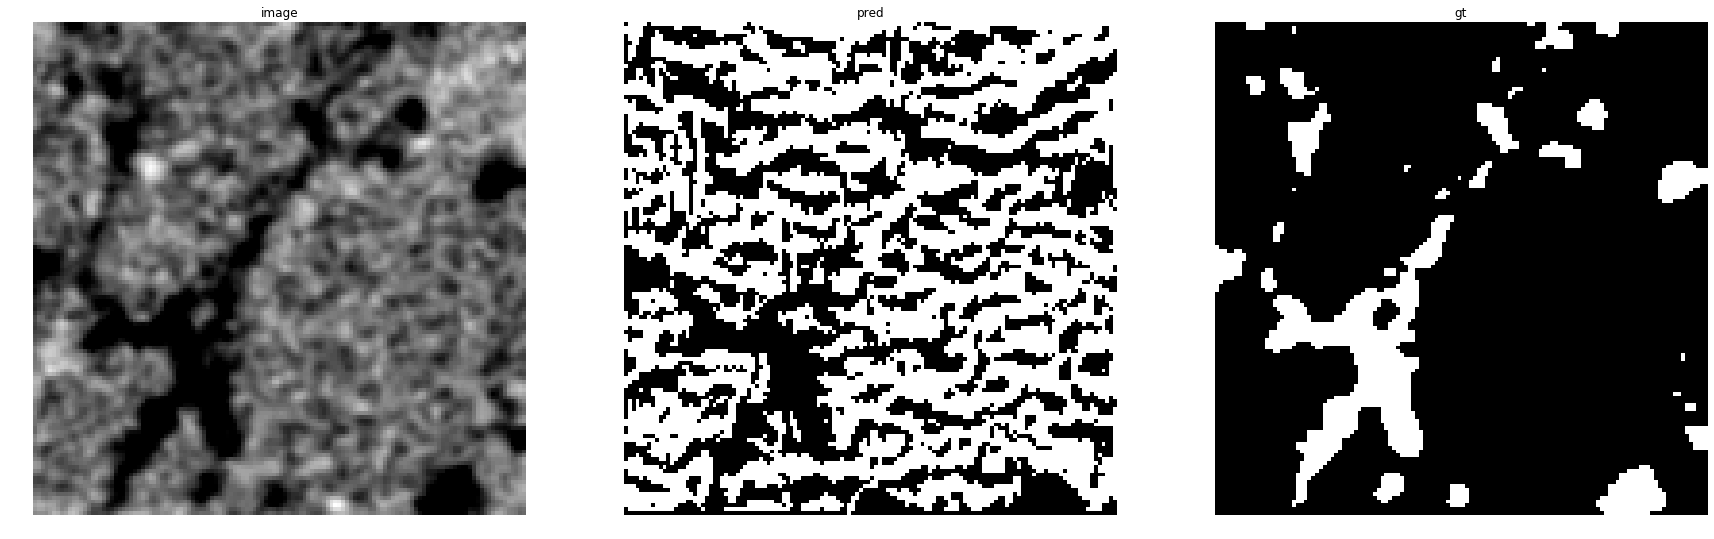

accuracy    : 0.3631591796875
precision   : 0.0353418944133465
recall      : 0.16370106761565836
f1          : 0.05813323704639826
pr_auc      : 0.06970984106434693
iou         : 0.029936779471922647


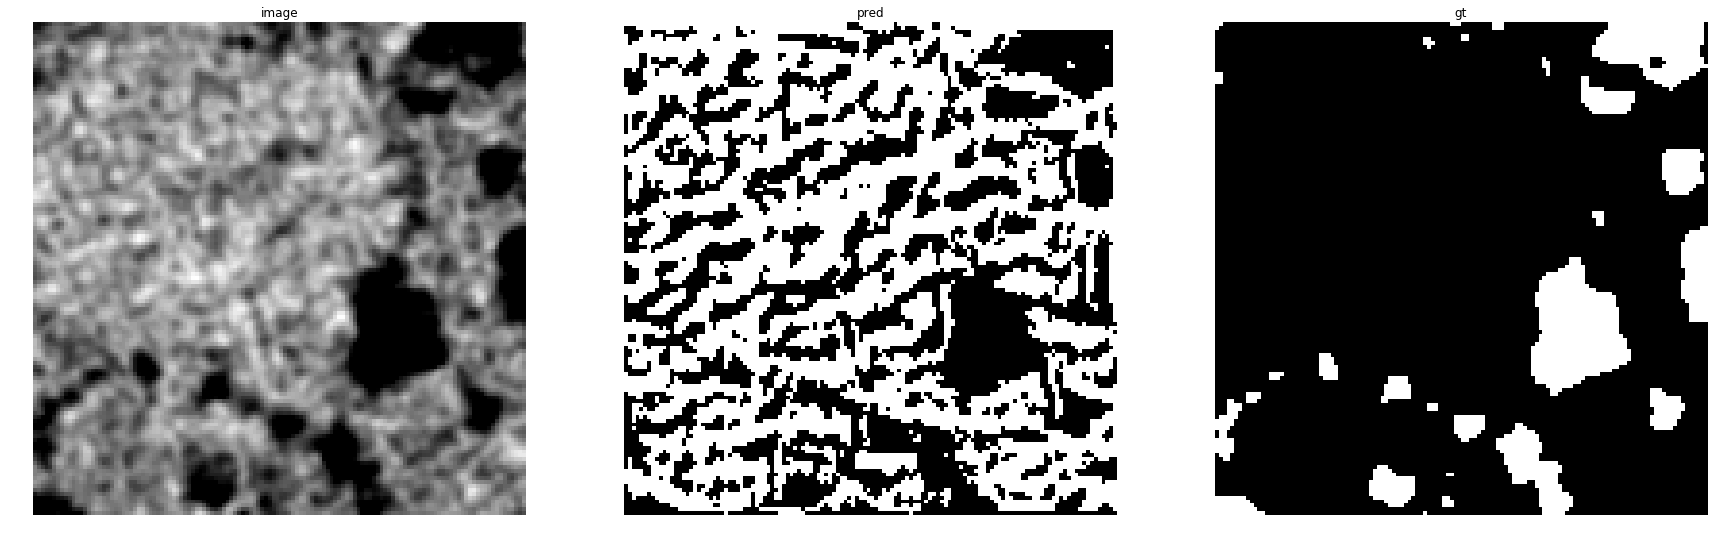

accuracy    : 0.3526611328125
precision   : 0.029440735471161213
recall      : 0.1340308918784255
f1          : 0.04827709978463748
pr_auc      : 0.07011332478737196
iou         : 0.024735632183908045
TiTree_subset2


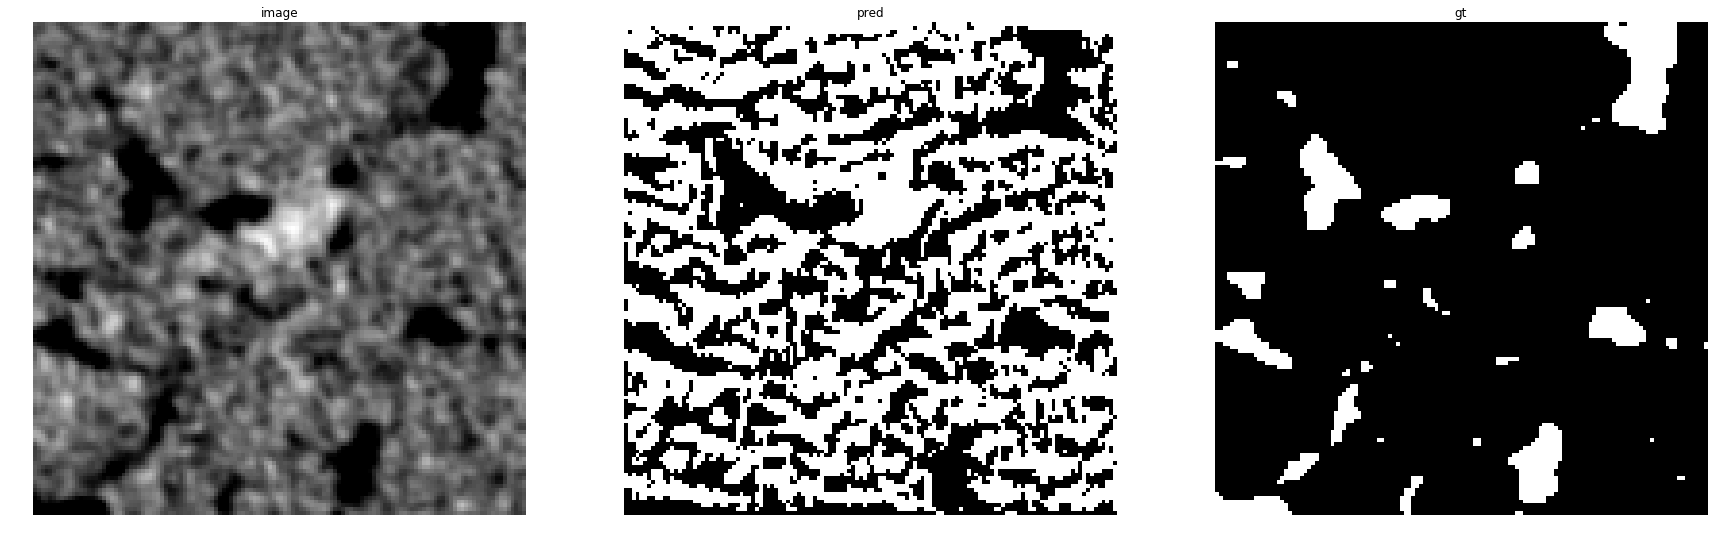

accuracy    : 0.3646240234375
precision   : 0.02082883660695014
recall      : 0.1261437908496732
f1          : 0.0357539829566506
pr_auc      : 0.05271010909108204
iou         : 0.01820239554842969


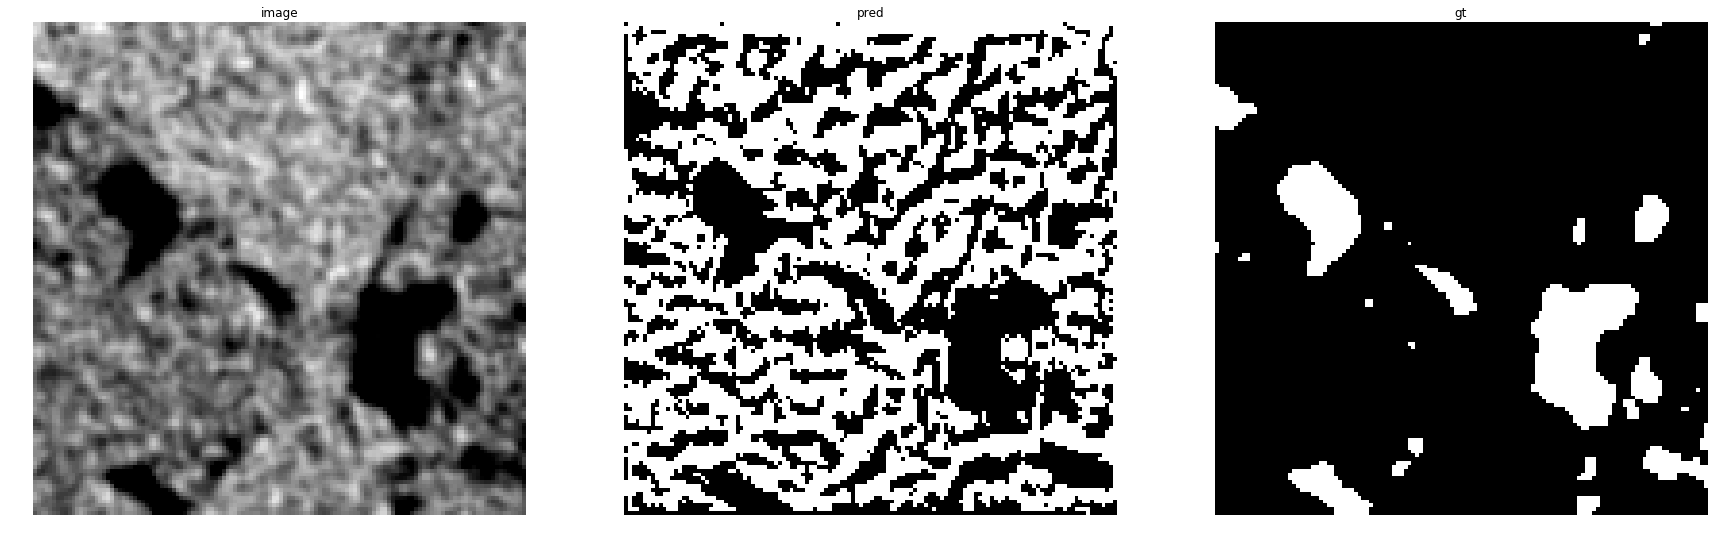

accuracy    : 0.3603515625
precision   : 0.018565587357719085
recall      : 0.09507640067911714
f1          : 0.031065088757396452
pr_auc      : 0.06042753478087232
iou         : 0.015777610818933134


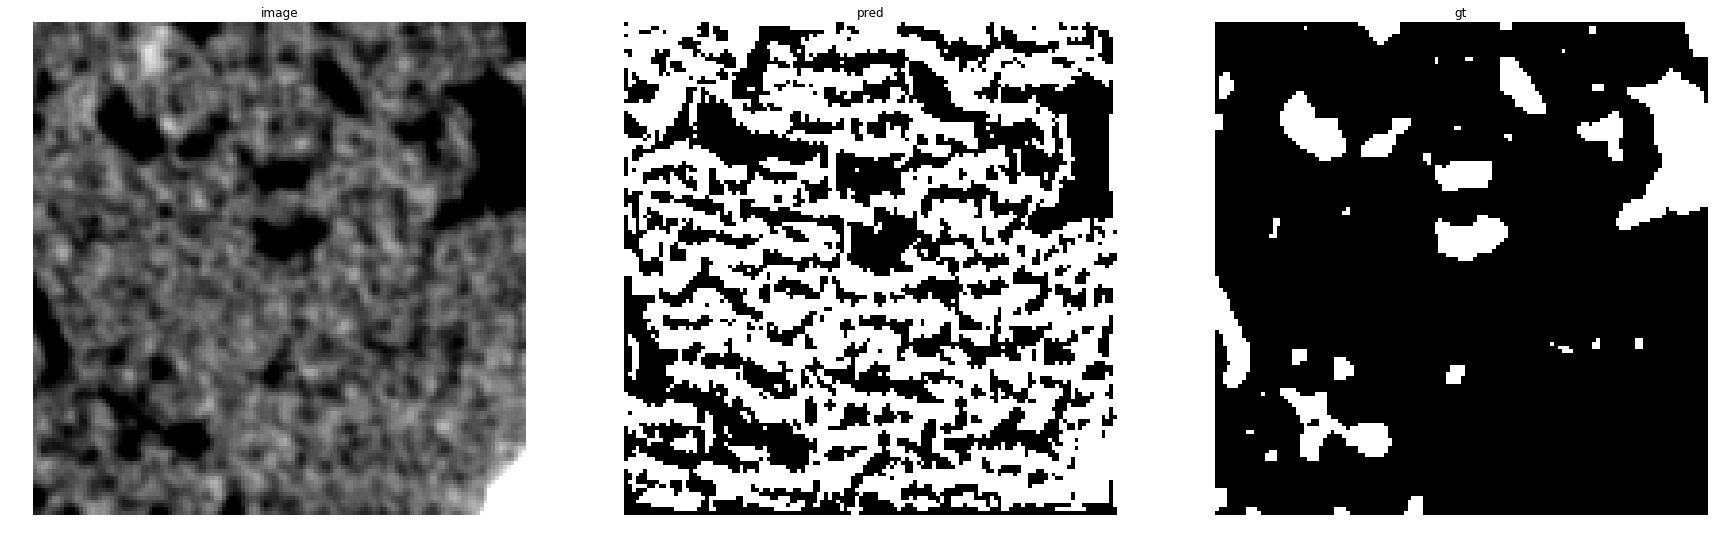

accuracy    : 0.35064697265625
precision   : 0.030608957147459995
recall      : 0.15015806111696522
f1          : 0.050851993933446346
pr_auc      : 0.06687626446197517
iou         : 0.026089344562431345


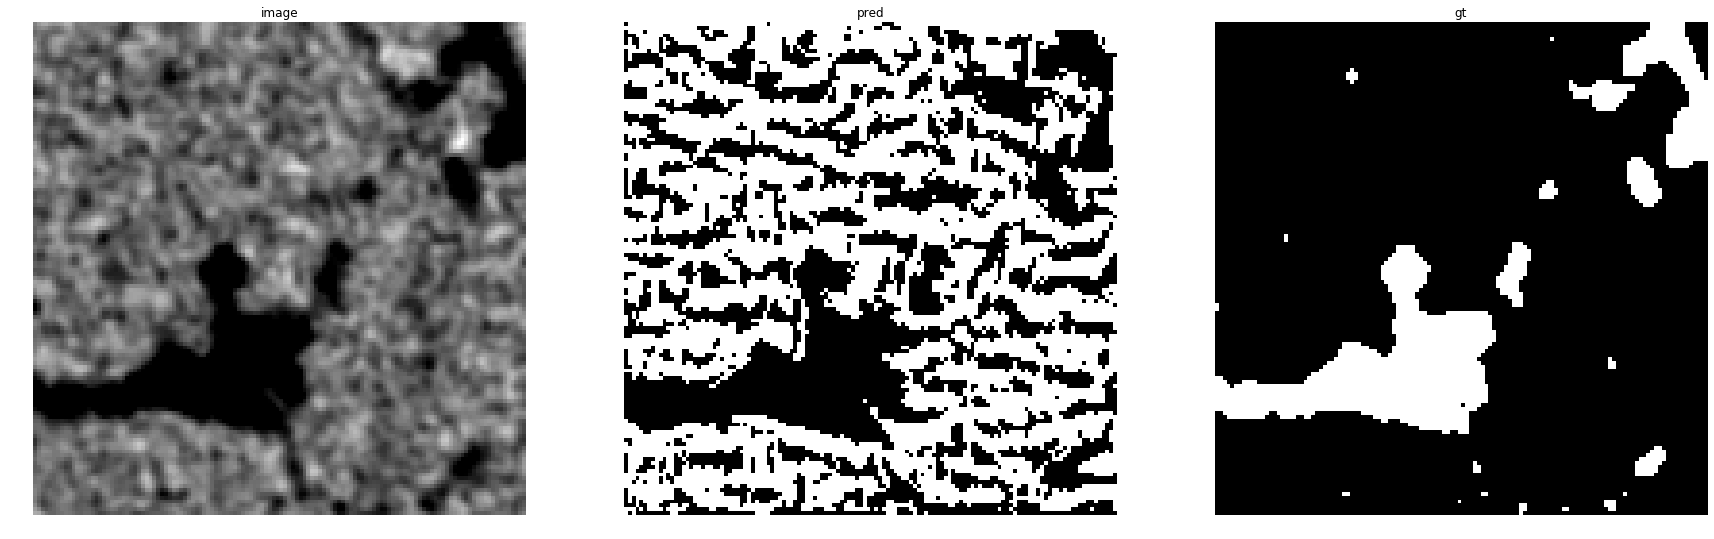

accuracy    : 0.32647705078125
precision   : 0.021373056994818652
recall      : 0.09137055837563451
f1          : 0.034642638439331644
pr_auc      : 0.0738369609831147
iou         : 0.017626635805216773


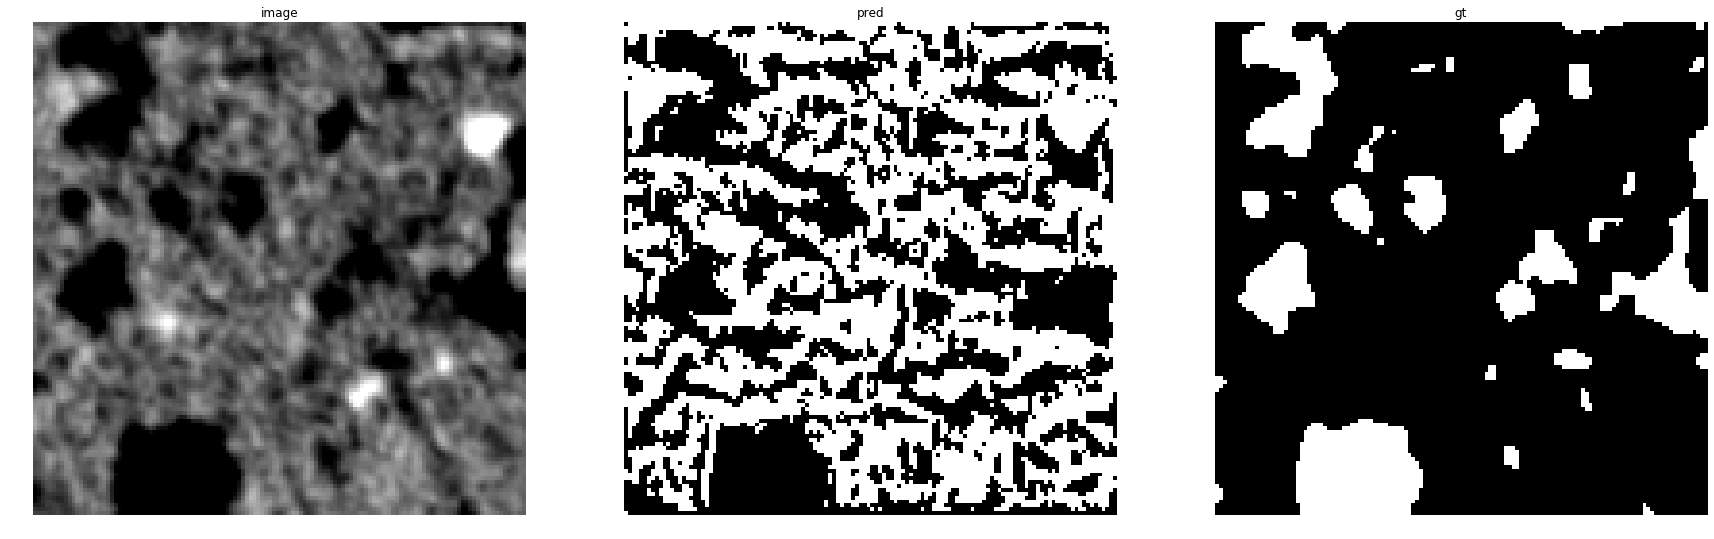

accuracy    : 0.35614013671875
precision   : 0.04907547389231306
recall      : 0.15103793843951324
f1          : 0.07408057579215307
pr_auc      : 0.10227185427450808
iou         : 0.03846504420745602


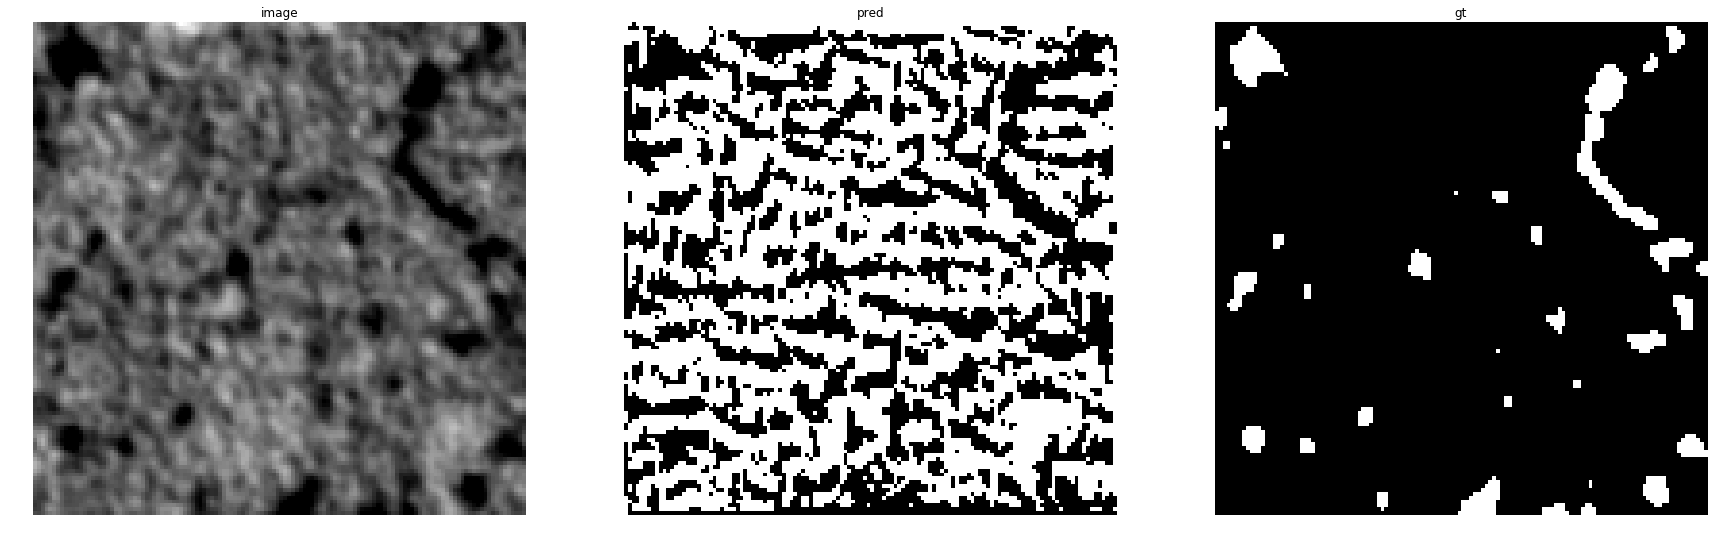

accuracy    : 0.3809814453125
precision   : 0.018691588785046728
recall      : 0.18256410256410258
f1          : 0.033911221184987614
pr_auc      : 0.03432080645097717
iou         : 0.017248062015503877


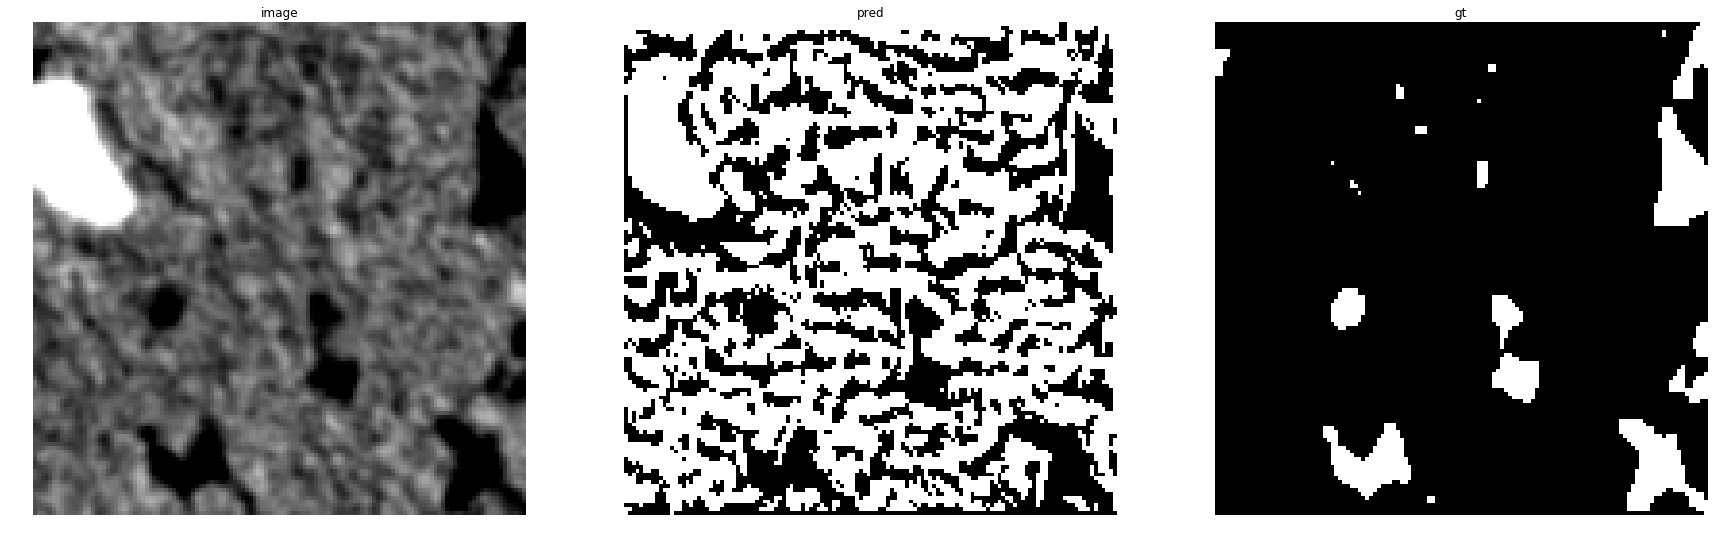

accuracy    : 0.3590087890625
precision   : 0.025833676410045286
recall      : 0.19487577639751552
f1          : 0.04561977462740822
pr_auc      : 0.04681305927754503
iou         : 0.023342323072630893


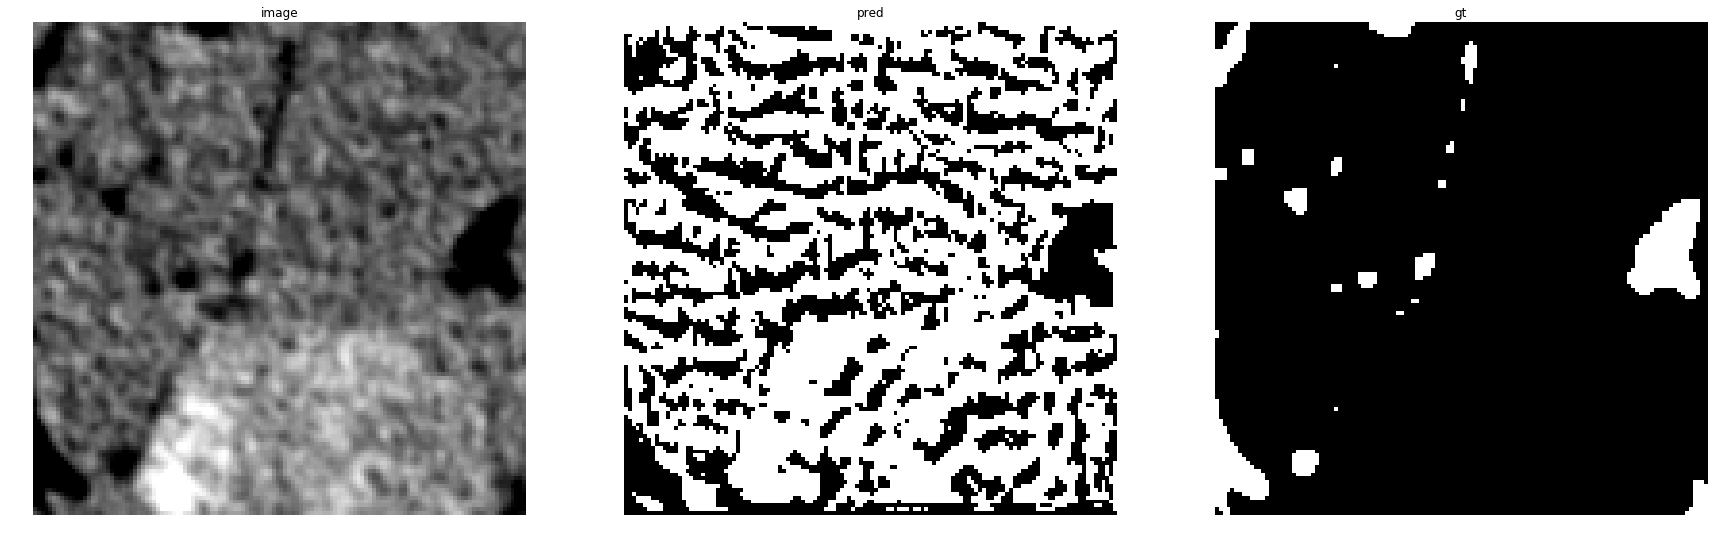

accuracy    : 0.33709716796875
precision   : 0.01220703125
recall      : 0.14351320321469574
f1          : 0.022500225002250022
pr_auc      : 0.02976195228259086
iou         : 0.011378117604223557


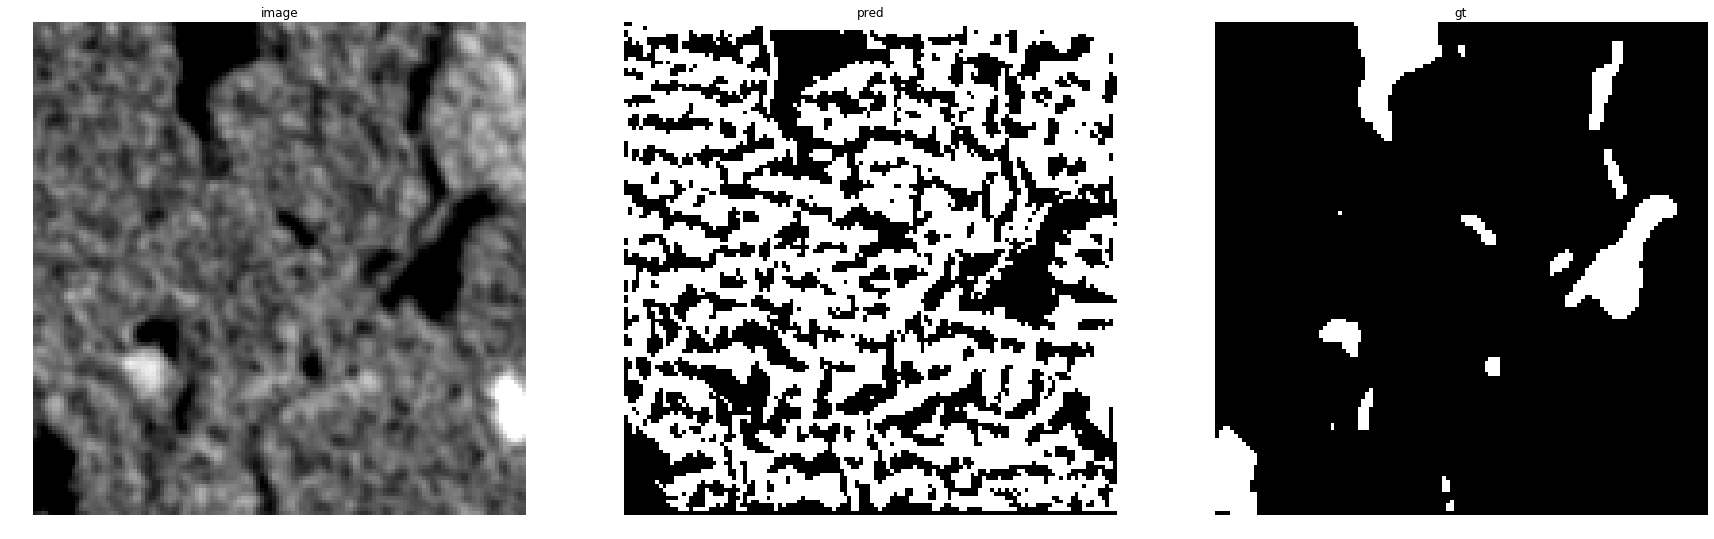

accuracy    : 0.36572265625
precision   : 0.022377914880267698
recall      : 0.17024661893396978
f1          : 0.03955637707948244
pr_auc      : 0.044424736846442194
iou         : 0.02017725815576089


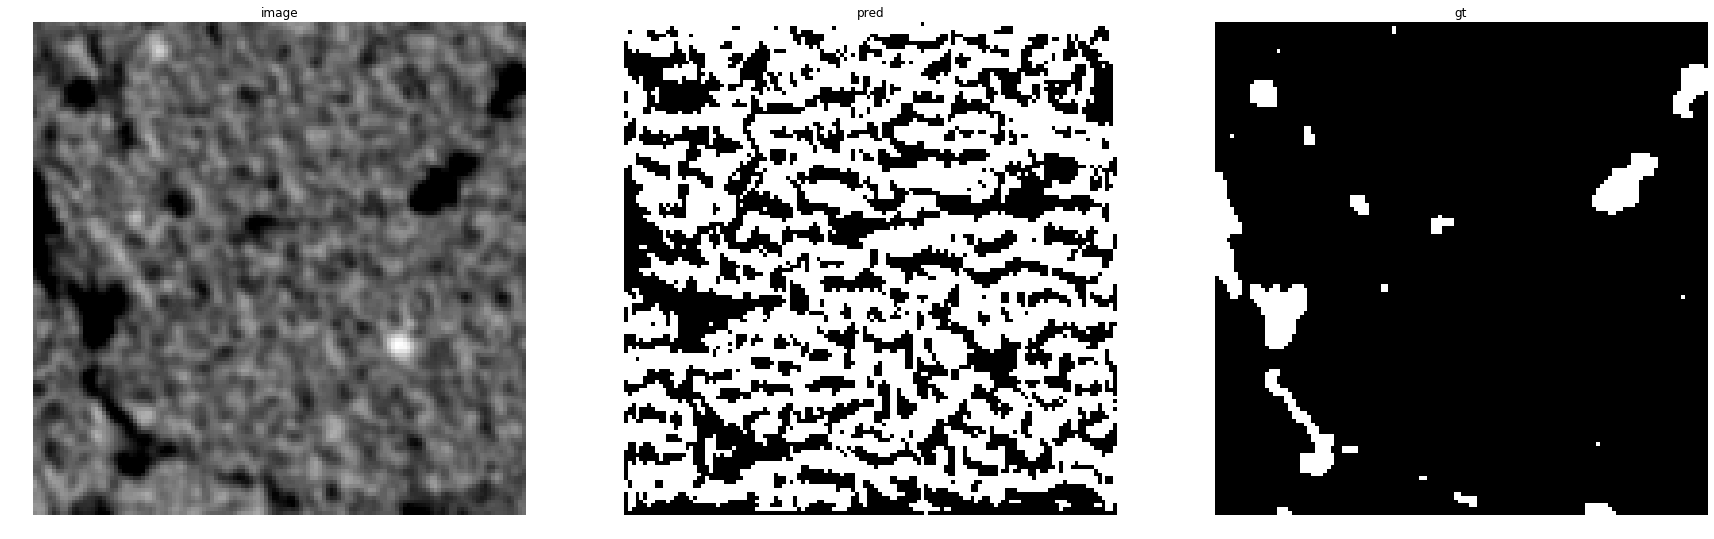

accuracy    : 0.3577880859375
precision   : 0.010098969905069683
recall      : 0.12195121951219512
f1          : 0.018653236336504387
pr_auc      : 0.027511361926321143
iou         : 0.009414422895876483
Urna_22


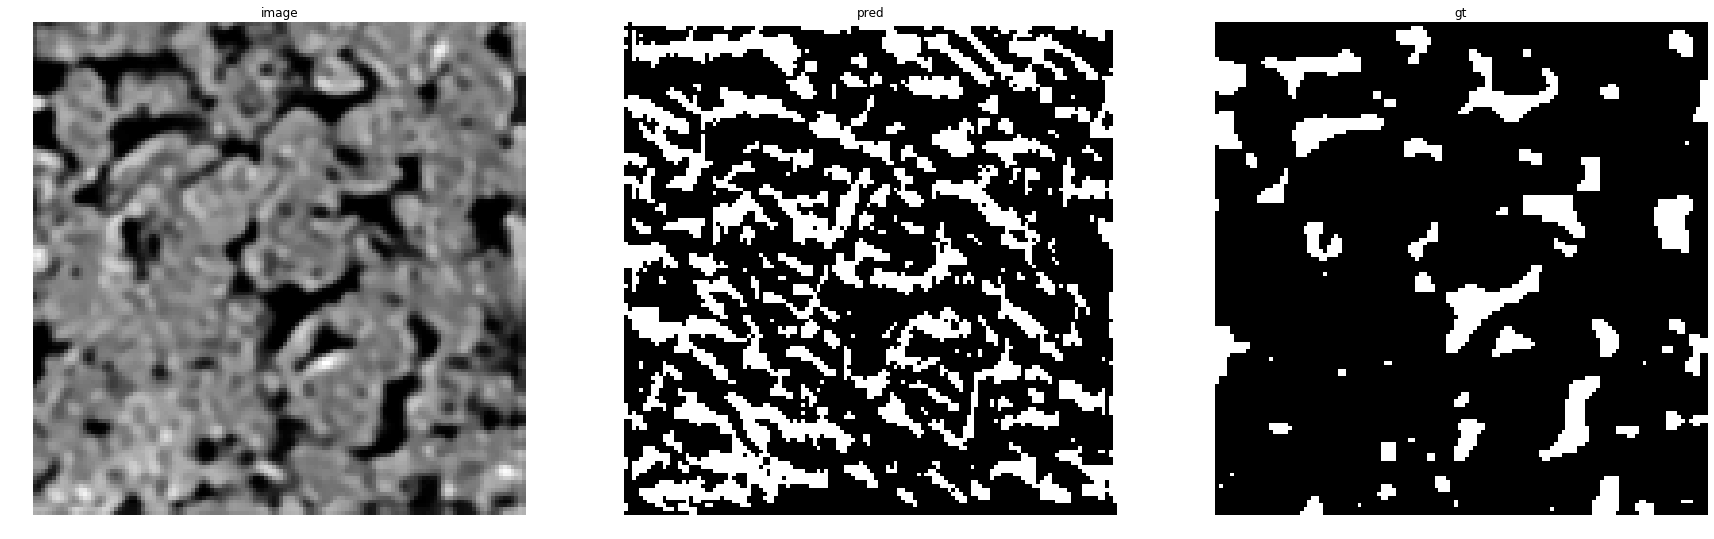

accuracy    : 0.58221435546875
precision   : 0.038965976050180574
recall      : 0.10280842527582748
f1          : 0.05651274982770503
pr_auc      : 0.07720321557688228
iou         : 0.029078014184397163


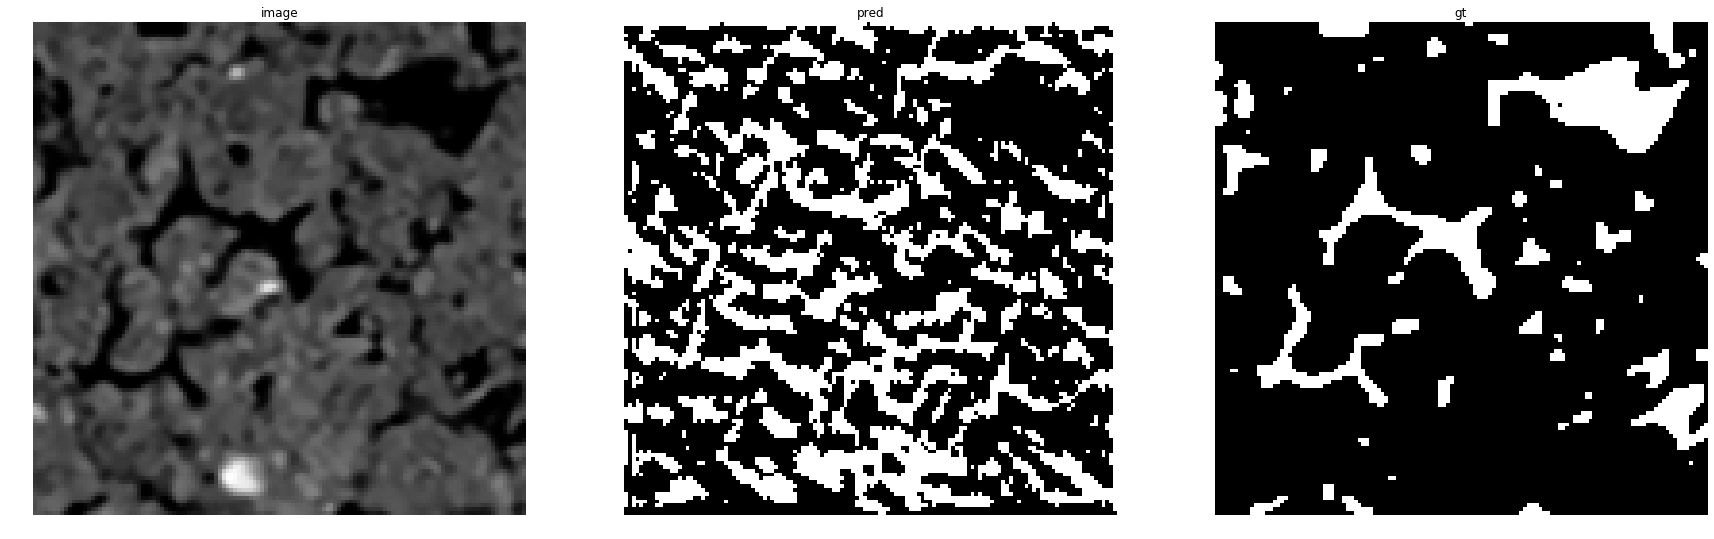

accuracy    : 0.567138671875
precision   : 0.055475243946512466
recall      : 0.14134438305709024
f1          : 0.07967817285232287
pr_auc      : 0.08482566498907318
iou         : 0.041492093526152185


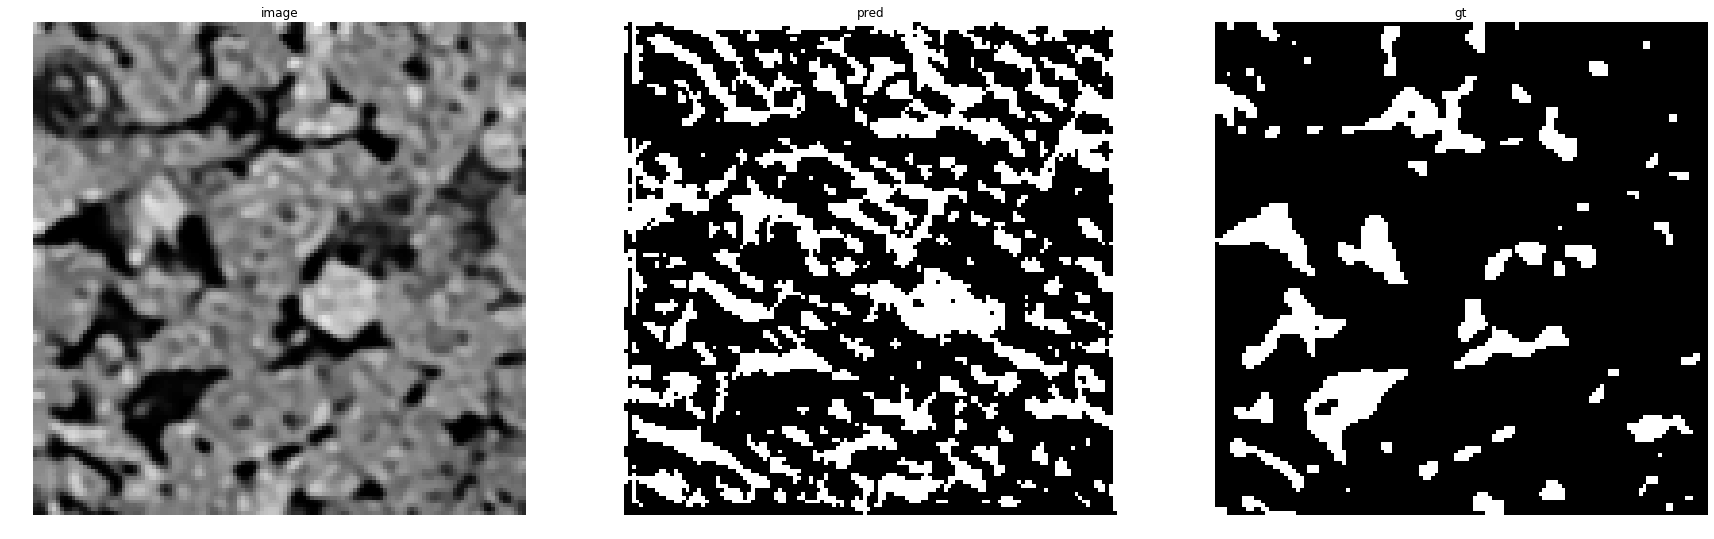

accuracy    : 0.5657958984375
precision   : 0.041007723427730784
recall      : 0.10508953817153628
f1          : 0.058994708994709
pr_auc      : 0.07778897124936612
iou         : 0.030393893962109855


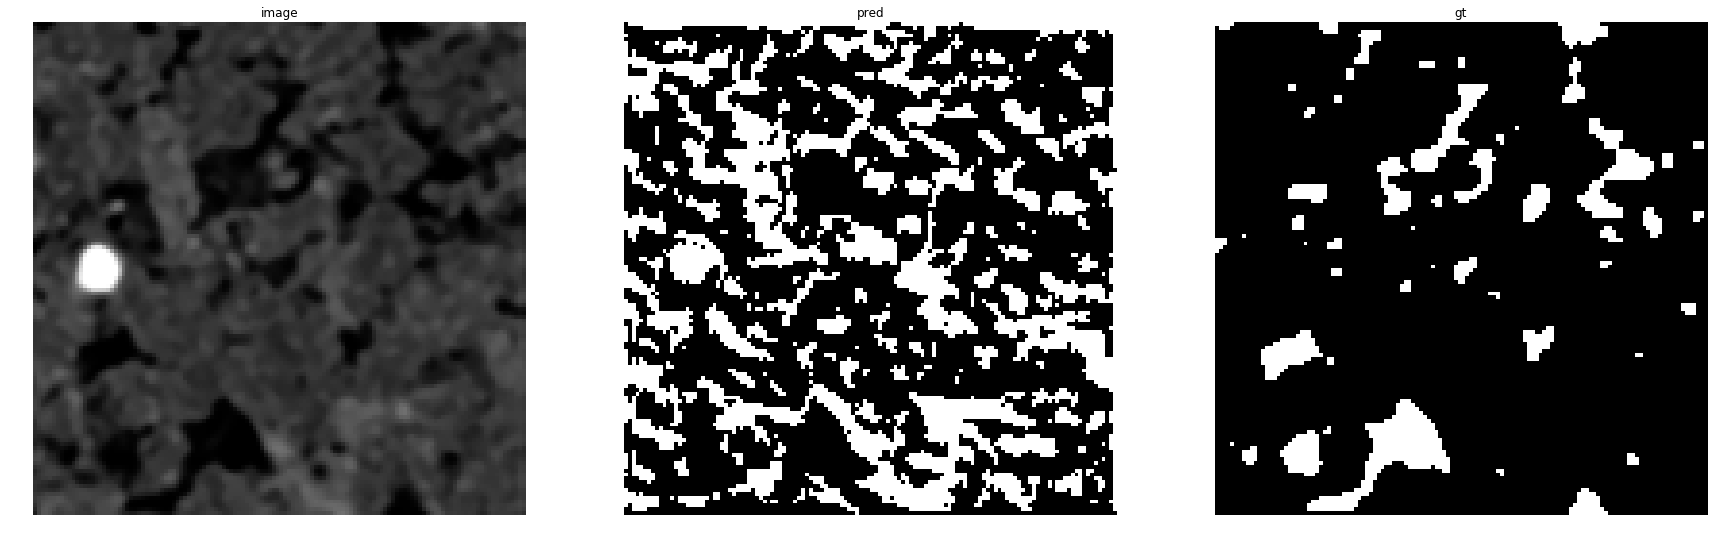

accuracy    : 0.58837890625
precision   : 0.036458333333333336
recall      : 0.12831858407079647
f1          : 0.05678321678321679
pr_auc      : 0.05946114840968096
iou         : 0.029221246581258097


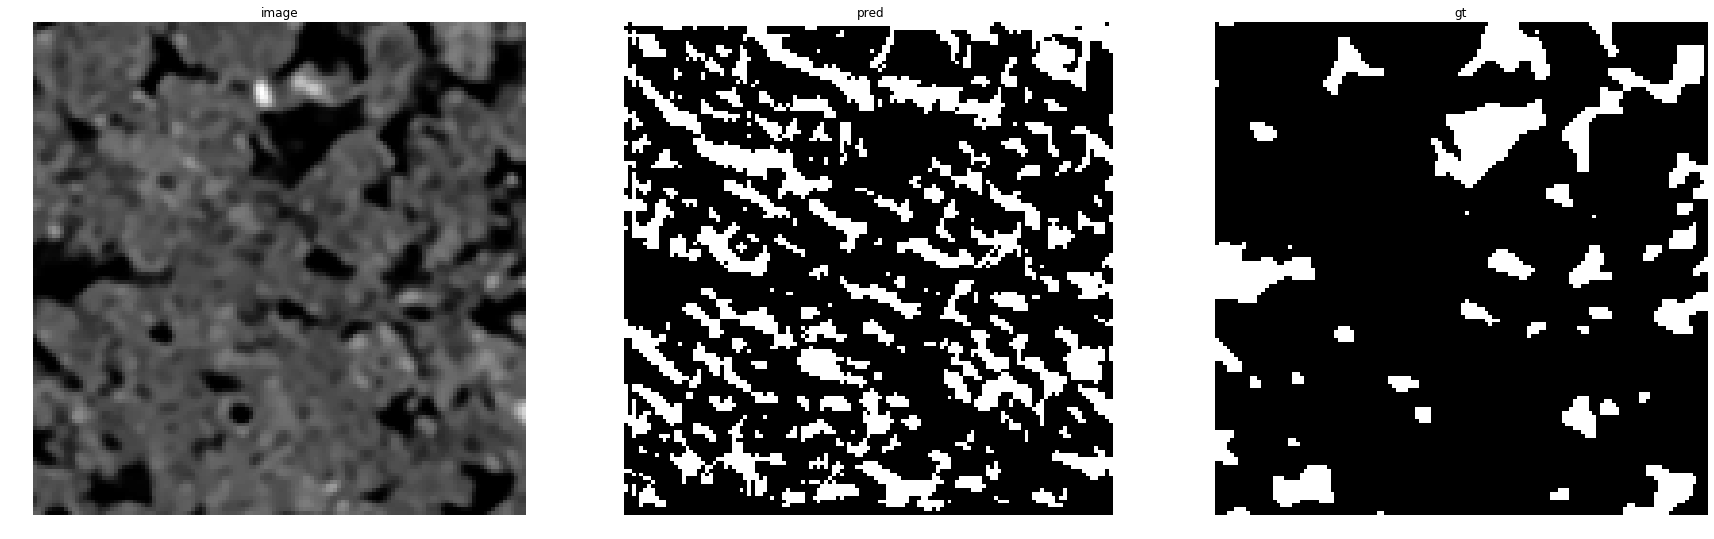

accuracy    : 0.61224365234375
precision   : 0.04945407835581246
recall      : 0.10774253731343283
f1          : 0.06779163609684519
pr_auc      : 0.08433797765962714
iou         : 0.035085054678007294


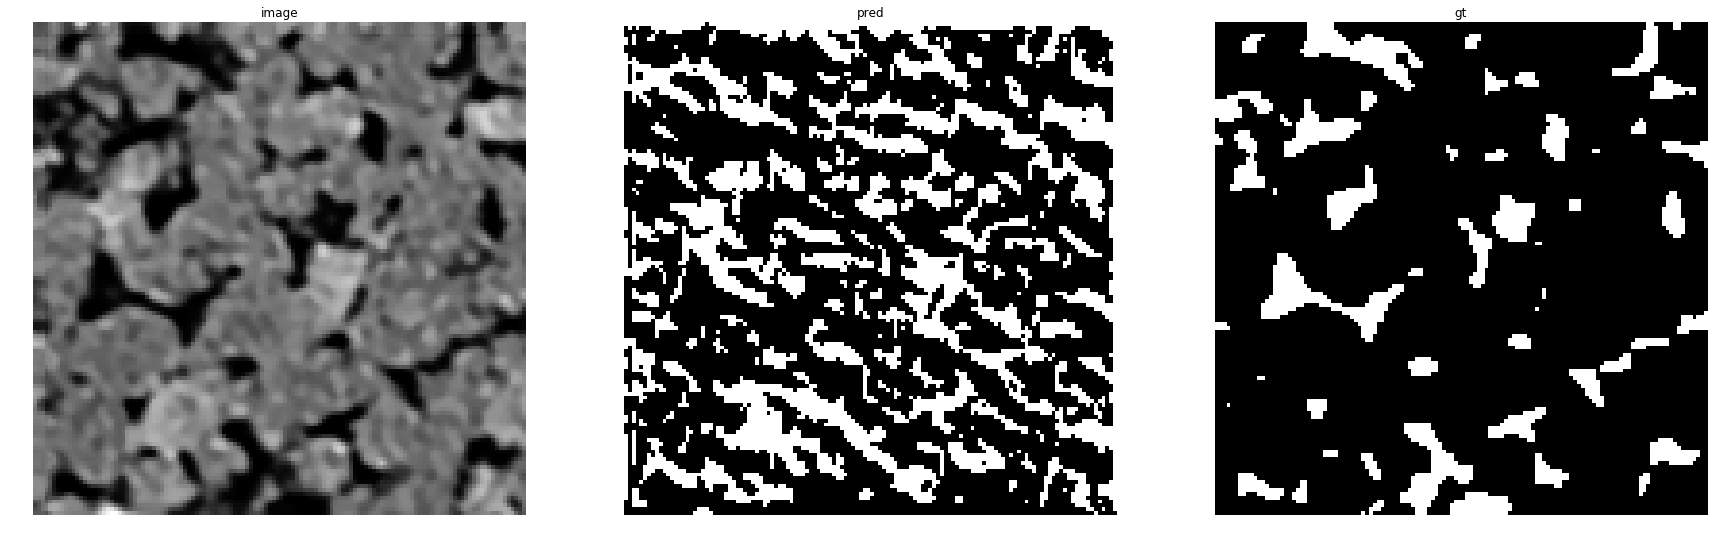

accuracy    : 0.561767578125
precision   : 0.041146216017634095
recall      : 0.10256410256410256
f1          : 0.05873099108547456
pr_auc      : 0.08478555237804553
iou         : 0.030253916801728797


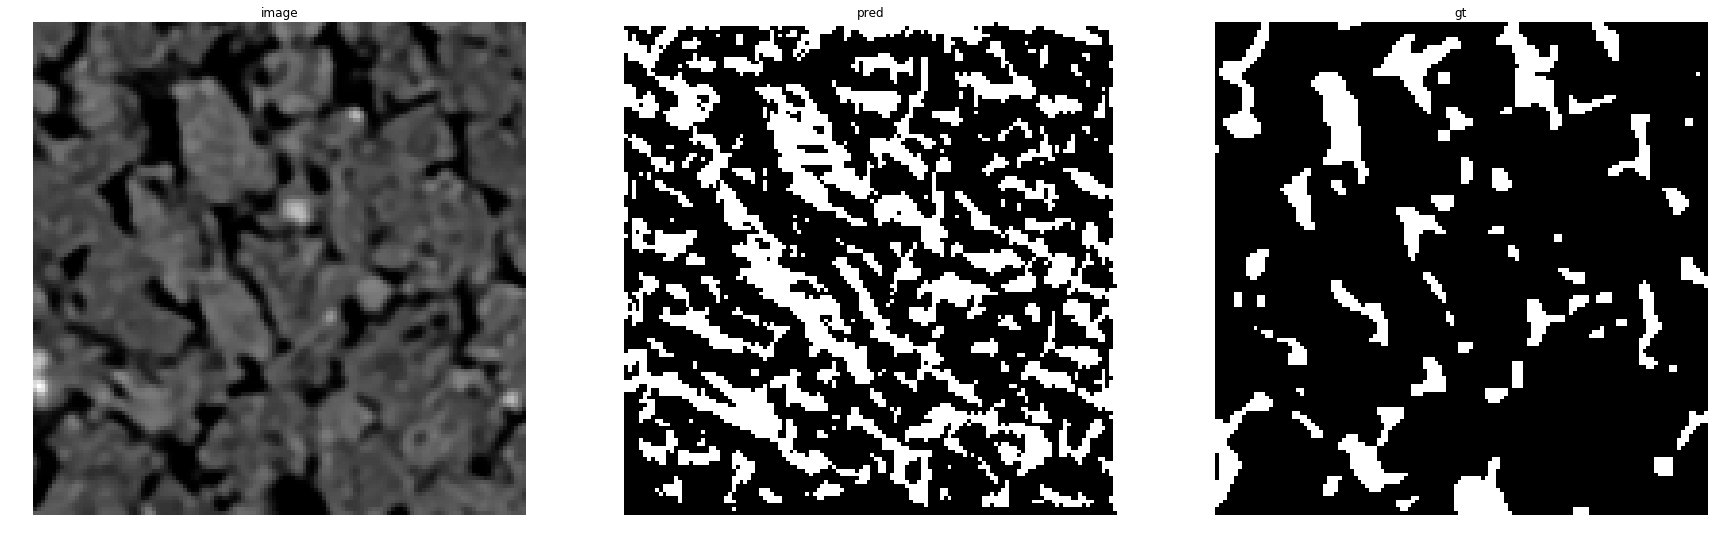

accuracy    : 0.56097412109375
precision   : 0.05312612938200217
recall      : 0.1308411214953271
f1          : 0.07556869297005525
pr_auc      : 0.08617050178019599
iou         : 0.039268064645385334


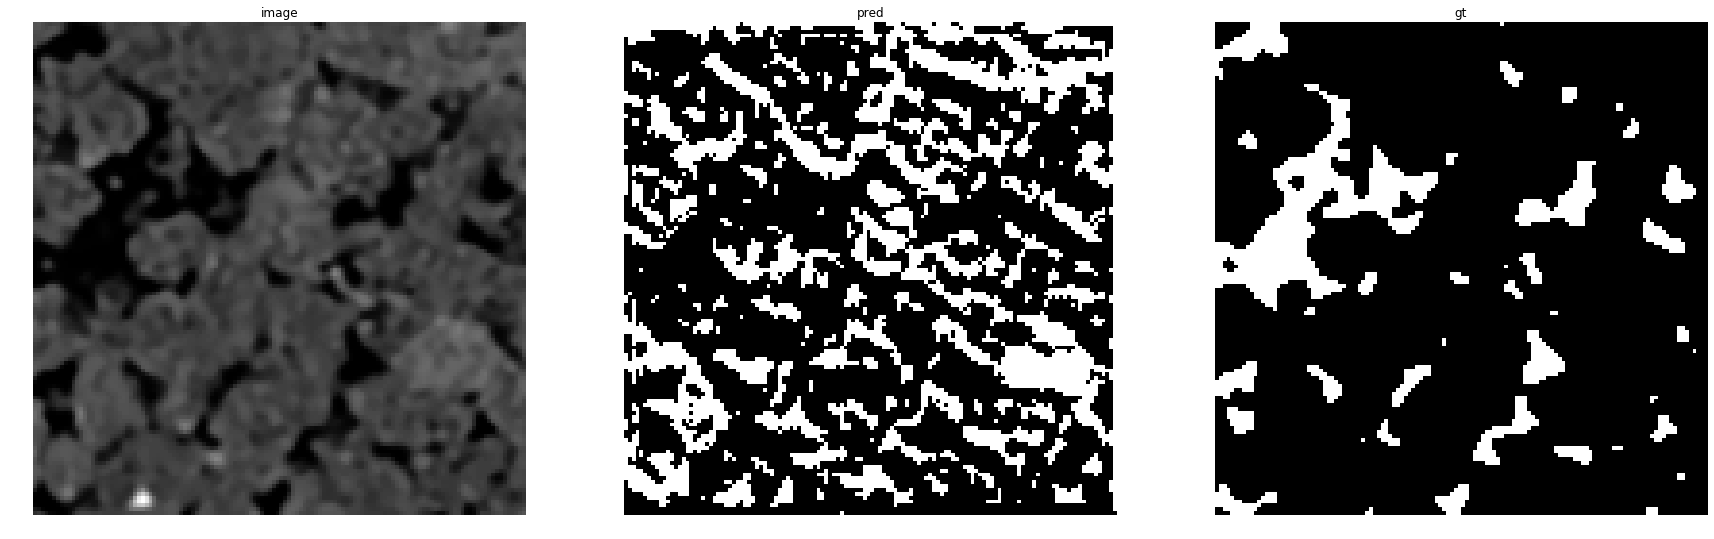

accuracy    : 0.5740966796875
precision   : 0.04036212749905696
recall      : 0.10171102661596958
f1          : 0.0577909802862544
pr_auc      : 0.07742842396831881
iou         : 0.029755283648498332


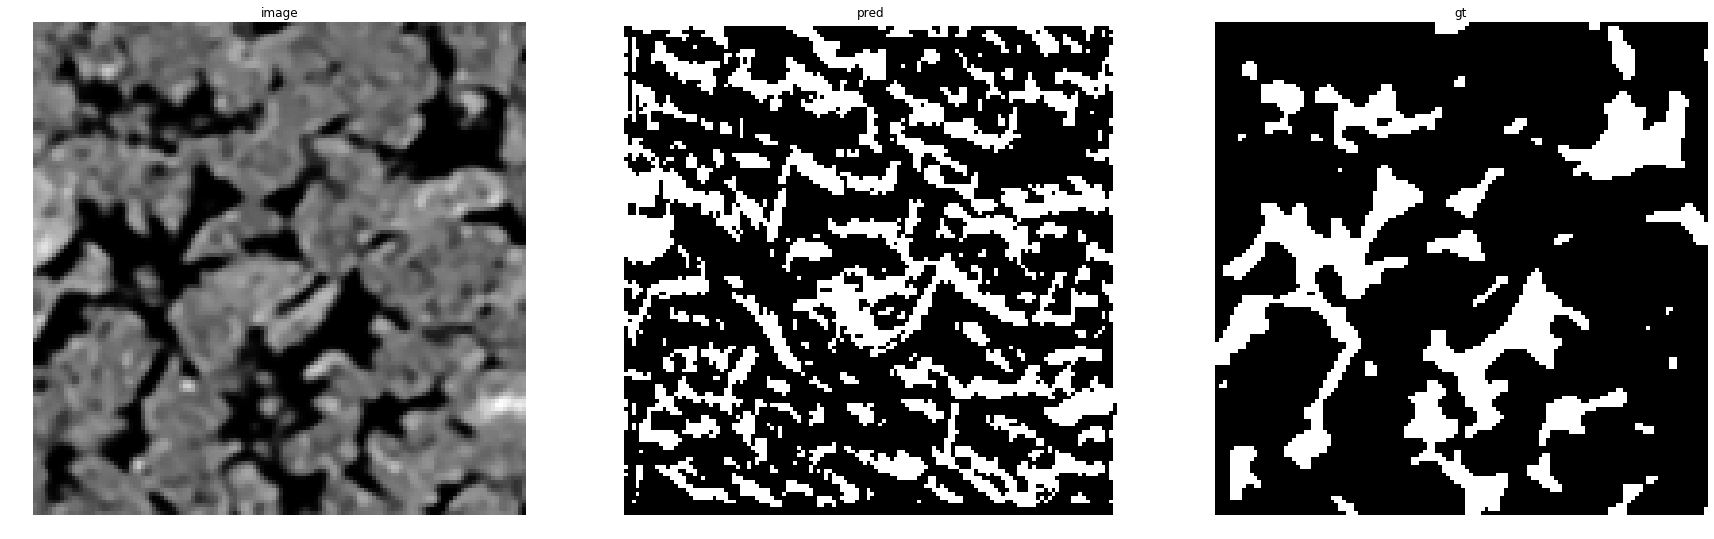

accuracy    : 0.51409912109375
precision   : 0.07063814090741424
recall      : 0.11588502269288956
f1          : 0.08777357625759138
pr_auc      : 0.12565261952777115
iou         : 0.04590124640460211


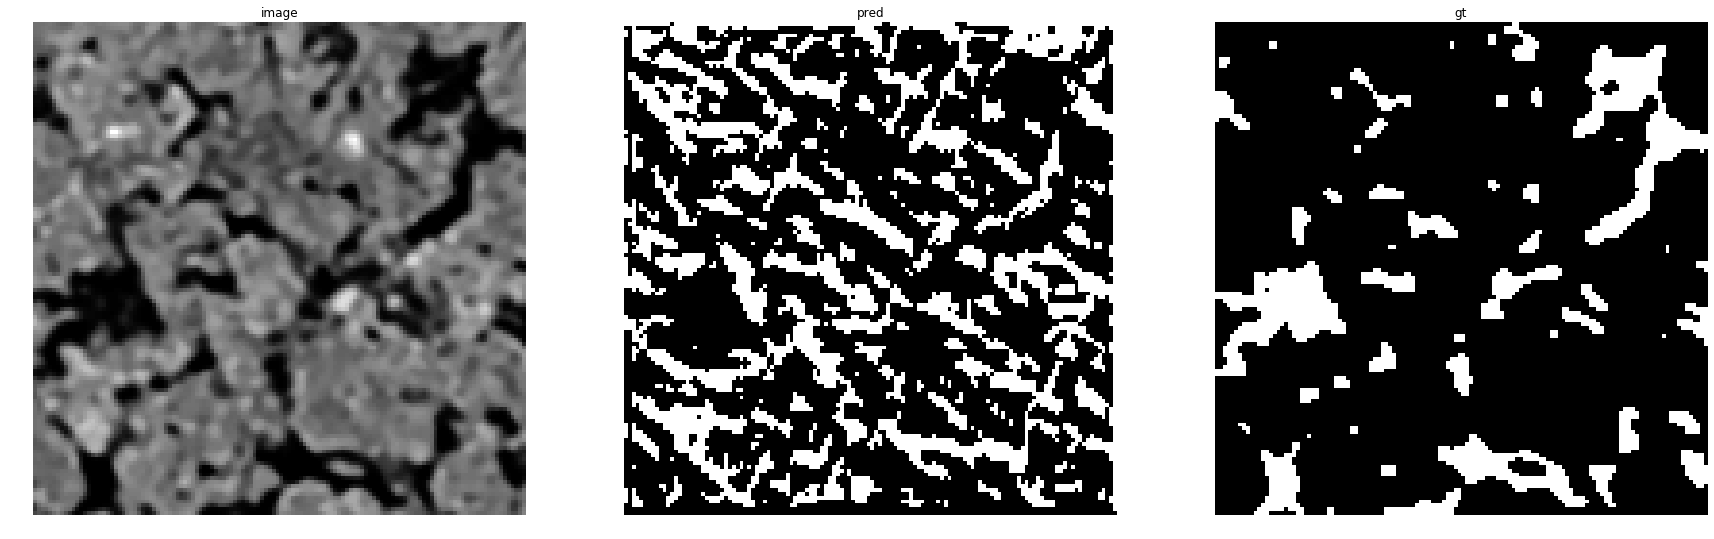

accuracy    : 0.5638427734375
precision   : 0.04980842911877394
recall      : 0.10629599345870809
f1          : 0.0678319853900339
pr_auc      : 0.0954357832798697
iou         : 0.035106670267350794
Urna_30


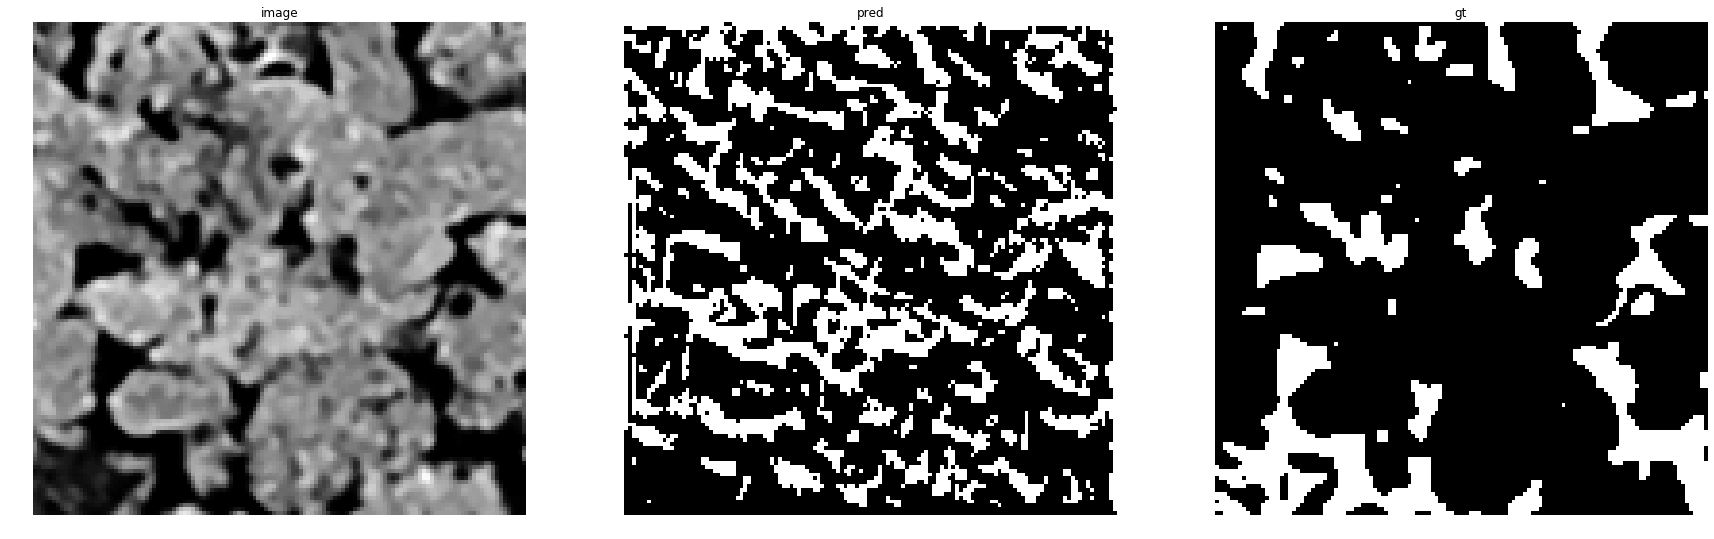

accuracy    : 0.5478515625
precision   : 0.07010785824345146
recall      : 0.12364130434782608
f1          : 0.0894788593903638
pr_auc      : 0.12340017184731662
iou         : 0.04683479155944416


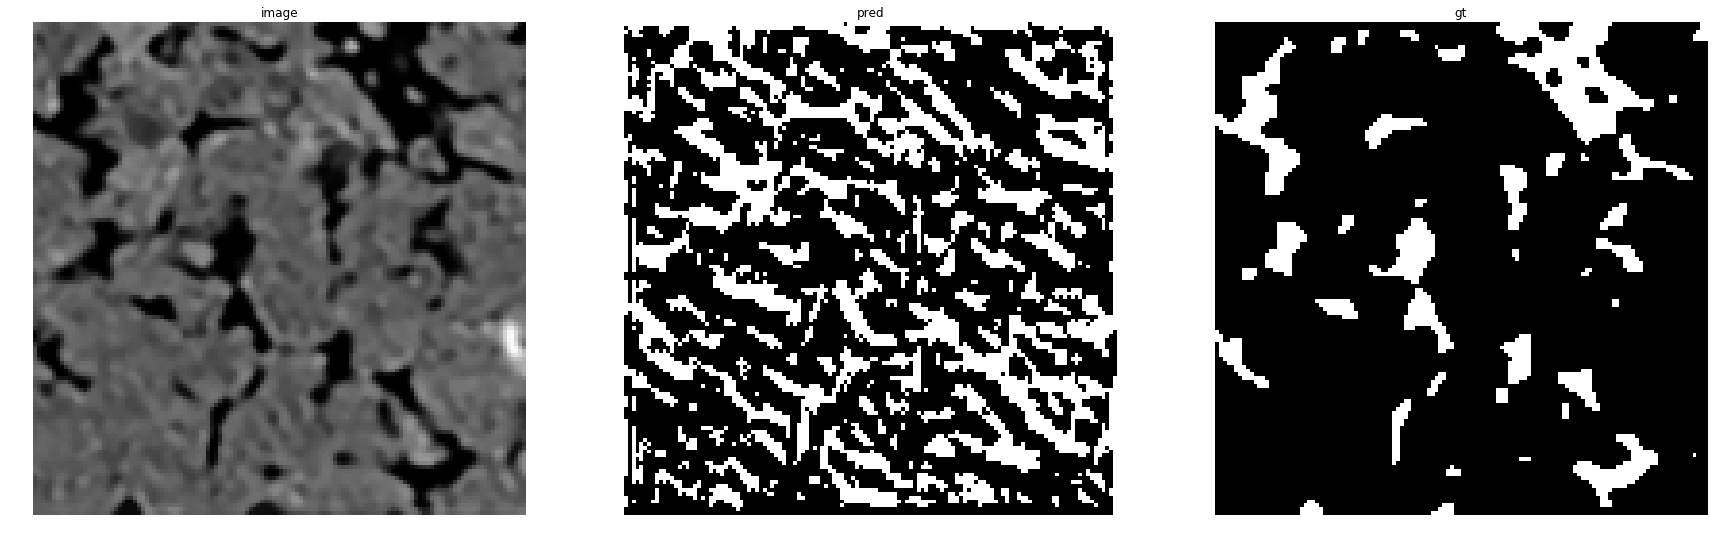

accuracy    : 0.57427978515625
precision   : 0.05586693183872717
recall      : 0.1498545101842871
f1          : 0.08139075464243382
pr_auc      : 0.08277935504032358
iou         : 0.04242174629324547


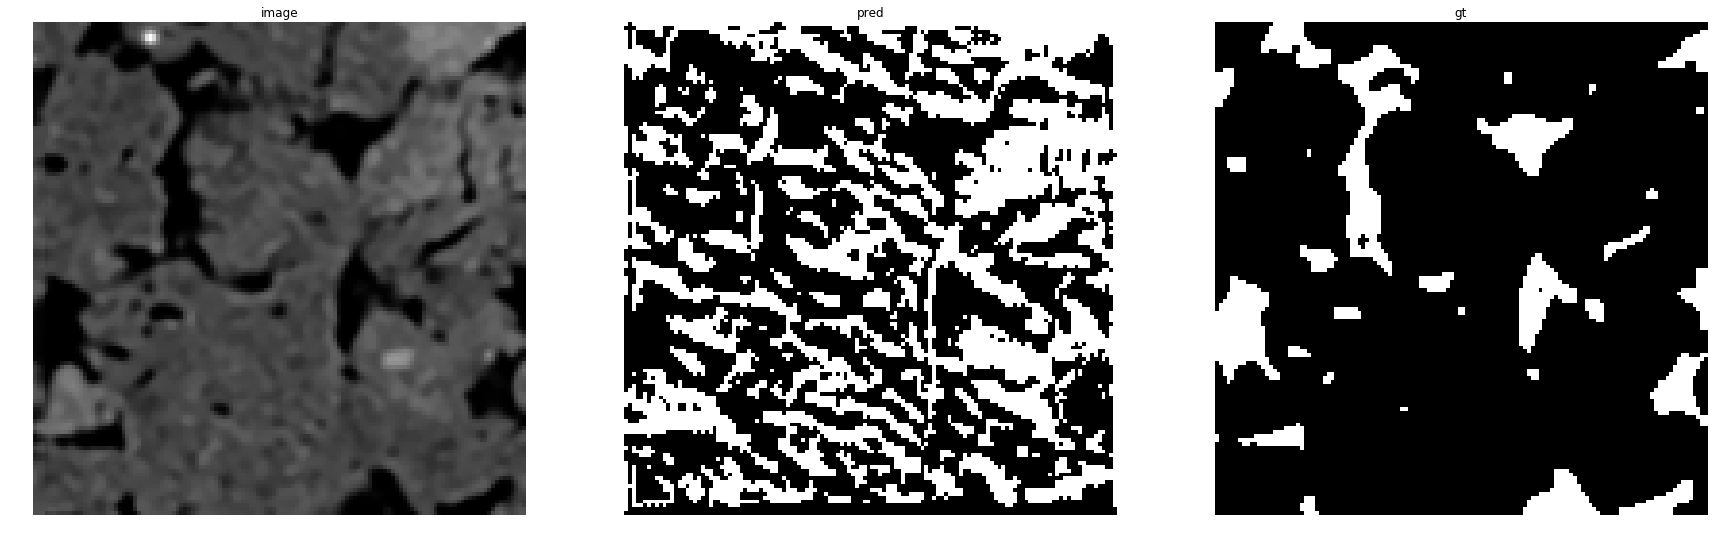

accuracy    : 0.4921875
precision   : 0.04389034703995334
recall      : 0.14583333333333334
f1          : 0.06747366061421206
pr_auc      : 0.08125864162428324
iou         : 0.03491474306924951


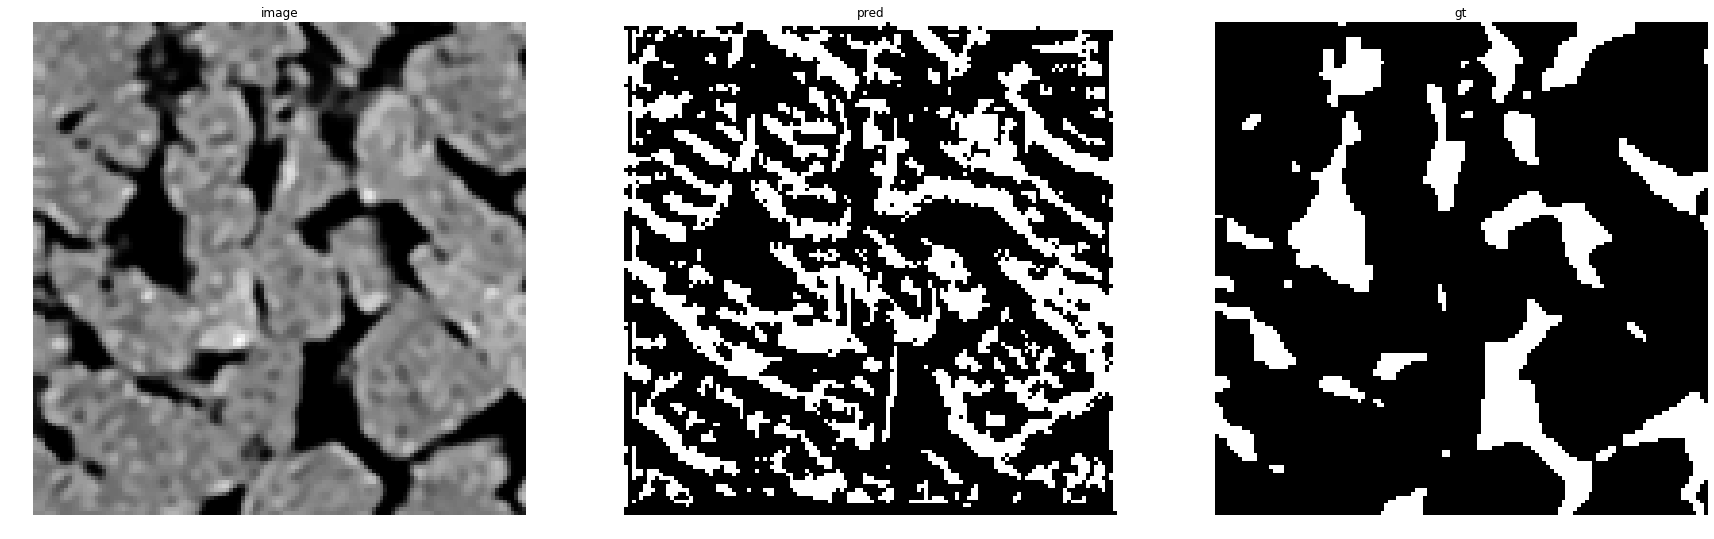

accuracy    : 0.511962890625
precision   : 0.0634112067451256
recall      : 0.11933884297520661
f1          : 0.08281715989905943
pr_auc      : 0.12128066767120654
iou         : 0.04319731961230106


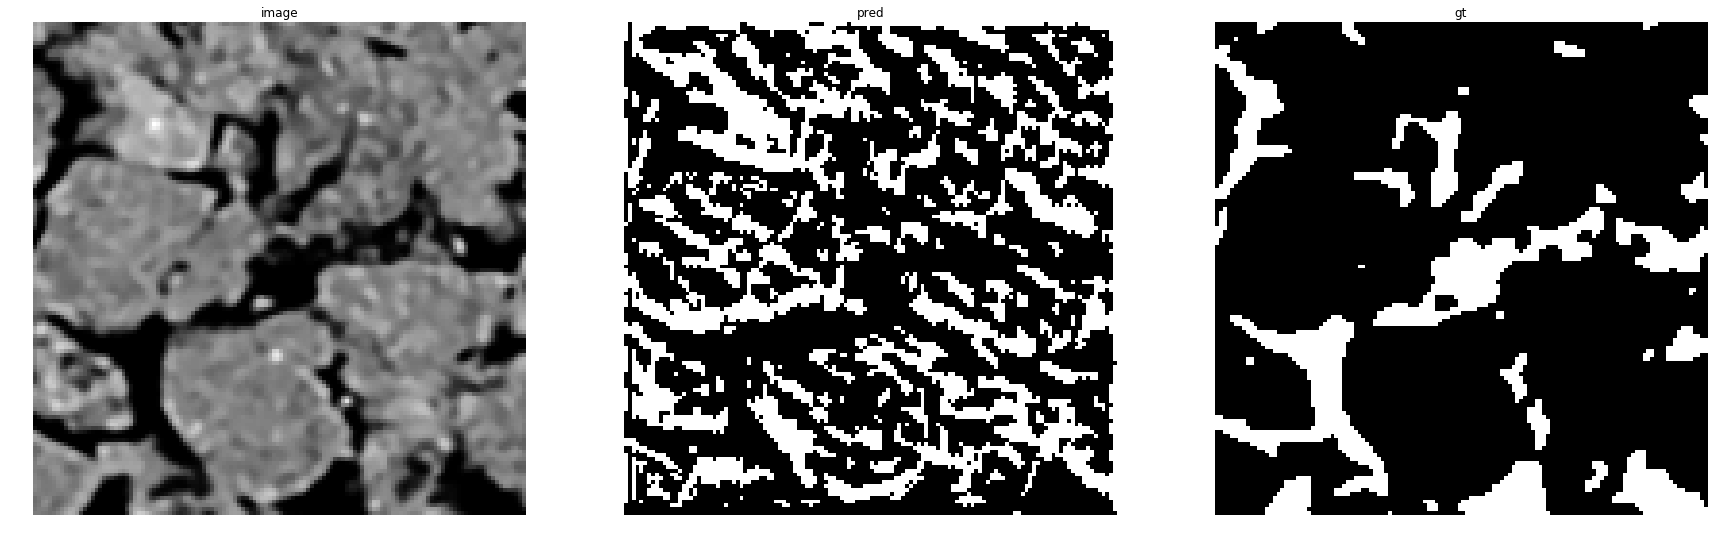

accuracy    : 0.5242919921875
precision   : 0.06051464063886424
recall      : 0.12002815909890883
f1          : 0.0804624823029731
pr_auc      : 0.11113149146050756
iou         : 0.04191763982790412


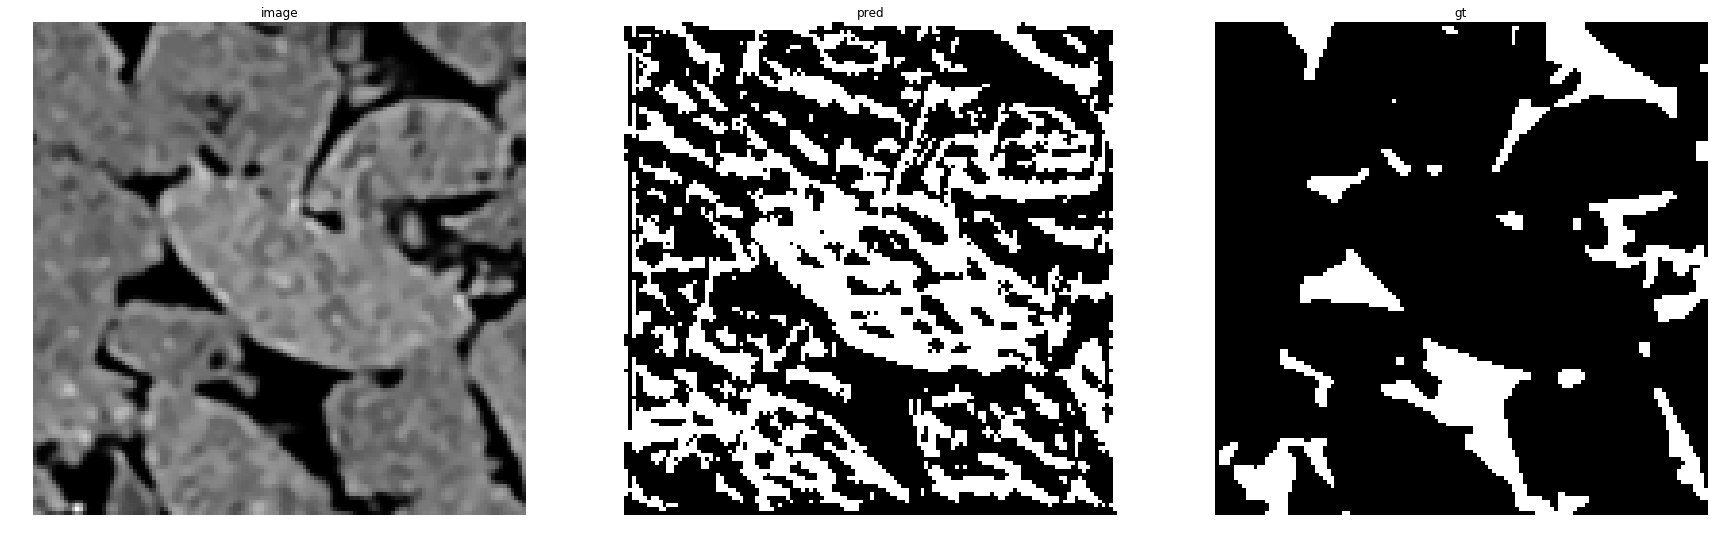

accuracy    : 0.4652099609375
precision   : 0.041962089422659526
recall      : 0.11929247223364871
f1          : 0.06208520659387711
pr_auc      : 0.09193486854805857
iou         : 0.032037118868758284


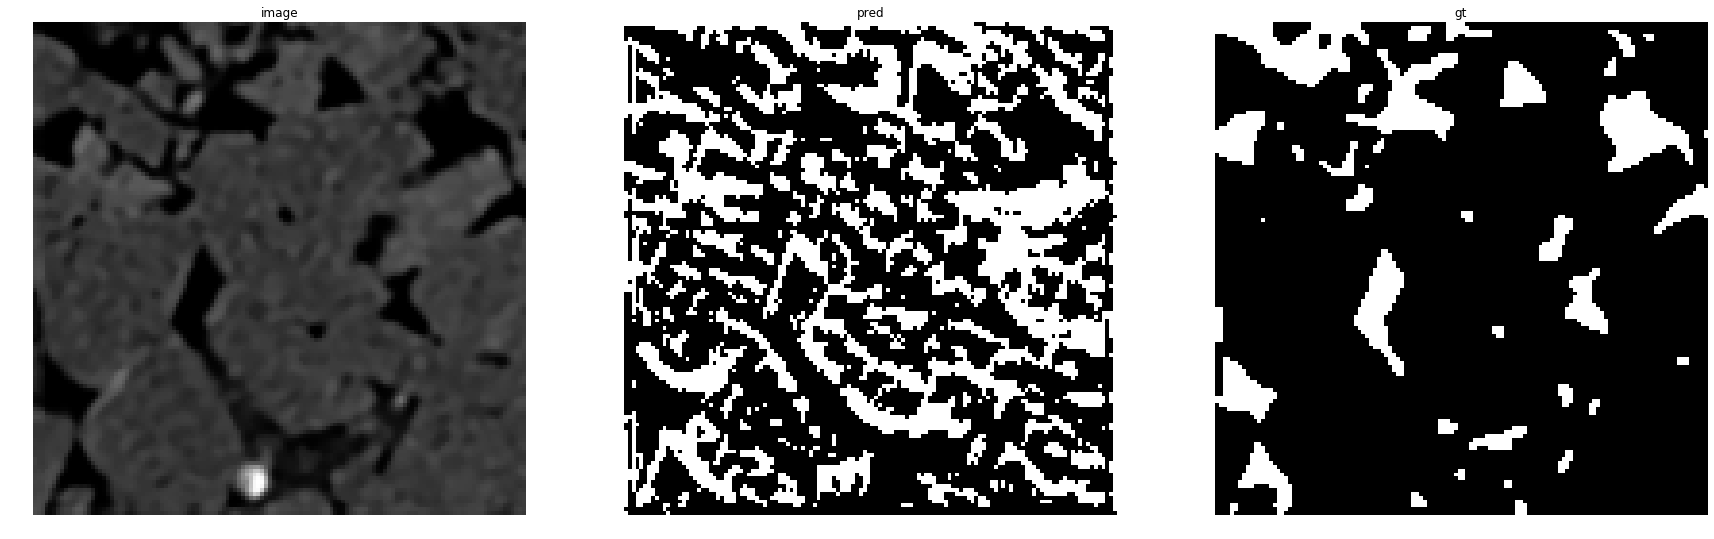

accuracy    : 0.5335693359375
precision   : 0.05056827540767583
recall      : 0.14050343249427918
f1          : 0.07437015503875968
pr_auc      : 0.08451453094840944
iou         : 0.038621210215121396


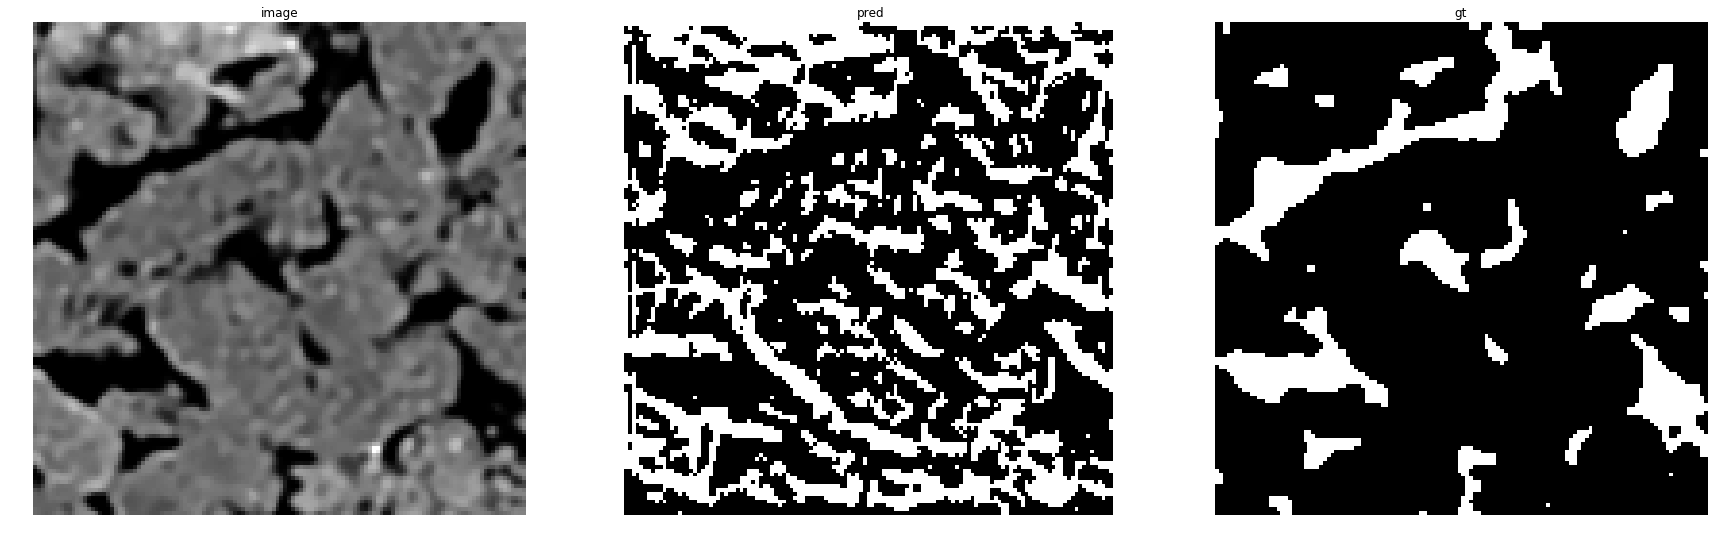

accuracy    : 0.5120849609375
precision   : 0.04682779456193353
recall      : 0.10755589822667695
f1          : 0.06524789522918616
pr_auc      : 0.09446728905662394
iou         : 0.033724162939683305


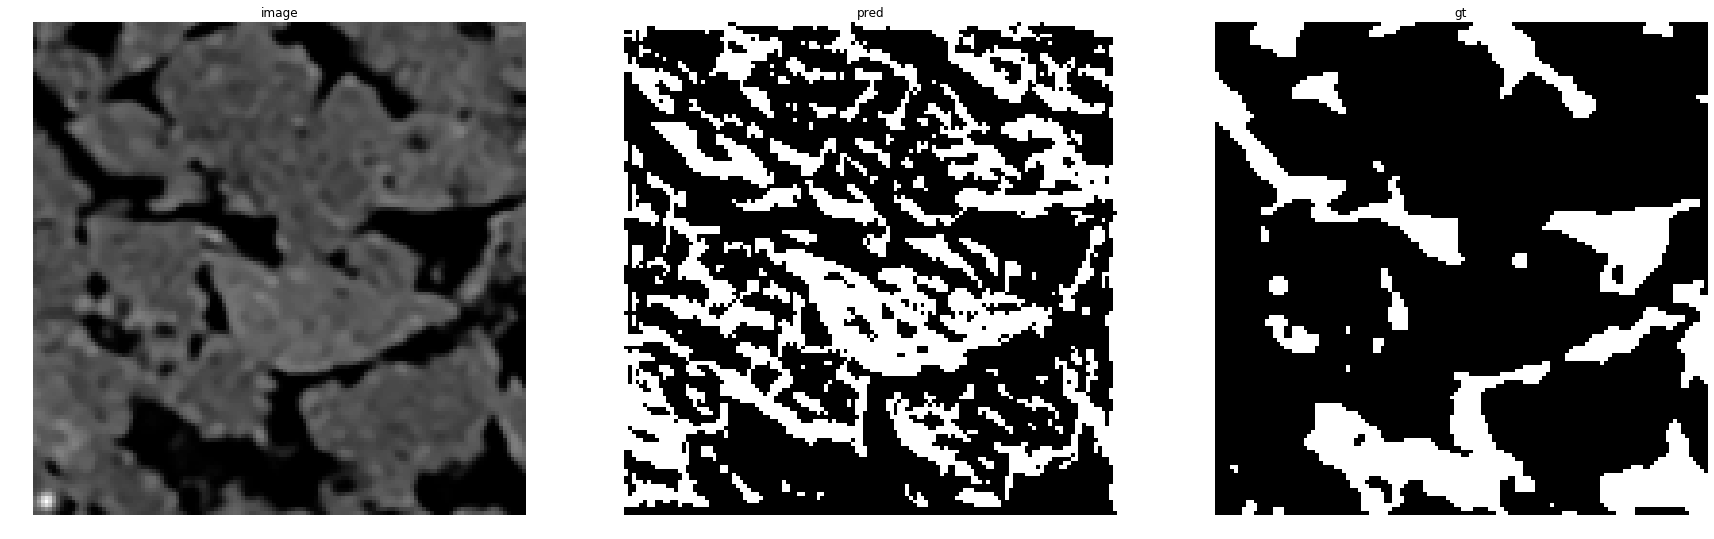

accuracy    : 0.4671630859375
precision   : 0.05679919812896759
recall      : 0.09929906542056074
f1          : 0.07226354941551541
pr_auc      : 0.13189050655747991
iou         : 0.037486218302094816


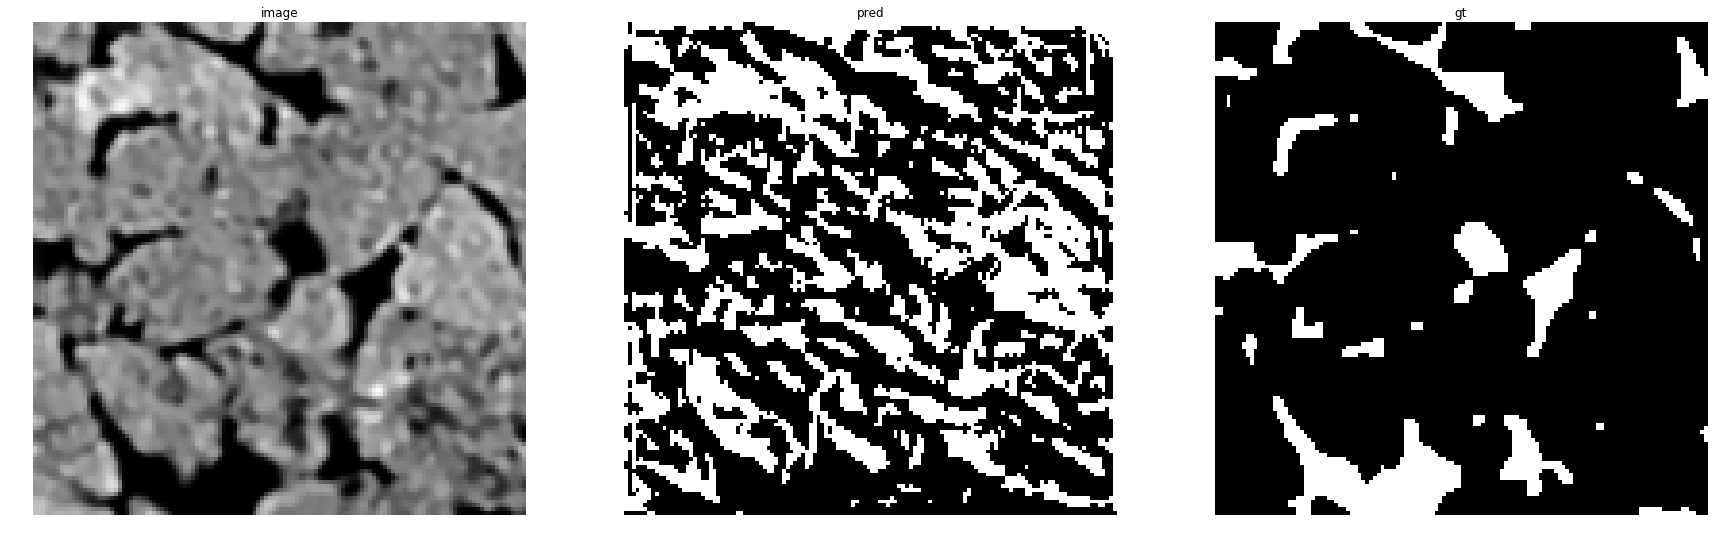

accuracy    : 0.5047607421875
precision   : 0.04219345011424219
recall      : 0.1317165953399905
f1          : 0.0639132441162898
pr_auc      : 0.08142437177955701
iou         : 0.033011560004767015
Urna_34


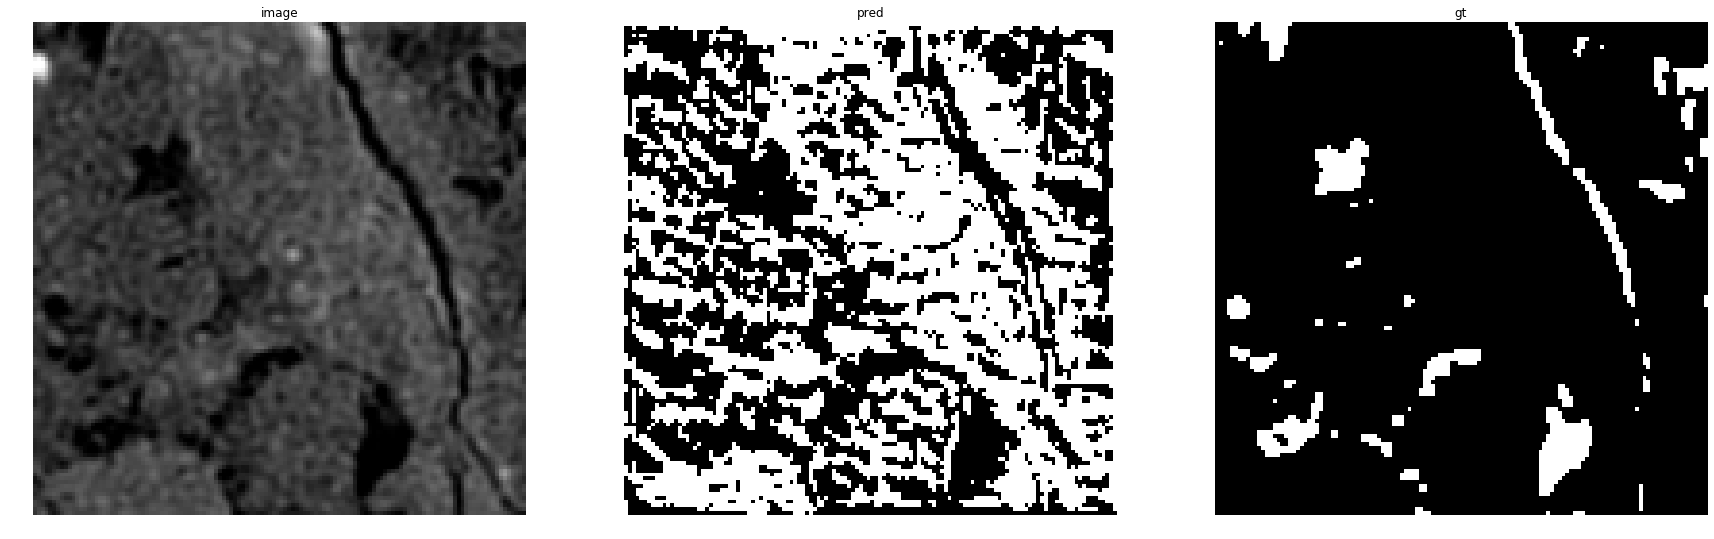

accuracy    : 0.4176025390625
precision   : 0.026625878087468843
recall      : 0.1981450252951096
f1          : 0.04694366759888135
pr_auc      : 0.0488291265232739
iou         : 0.024036002863864172


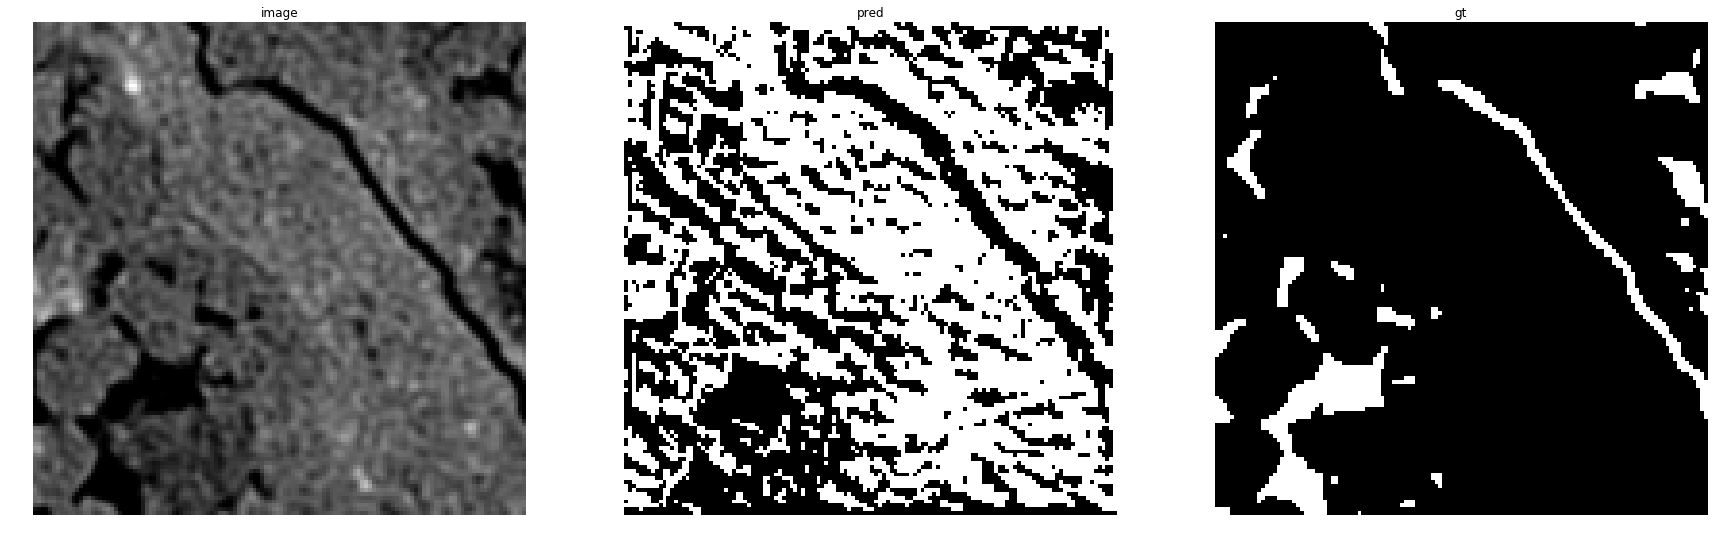

accuracy    : 0.36322021484375
precision   : 0.01928609483217901
recall      : 0.12836879432624113
f1          : 0.03353404353867532
pr_auc      : 0.04871329963926272
iou         : 0.017052948935368382


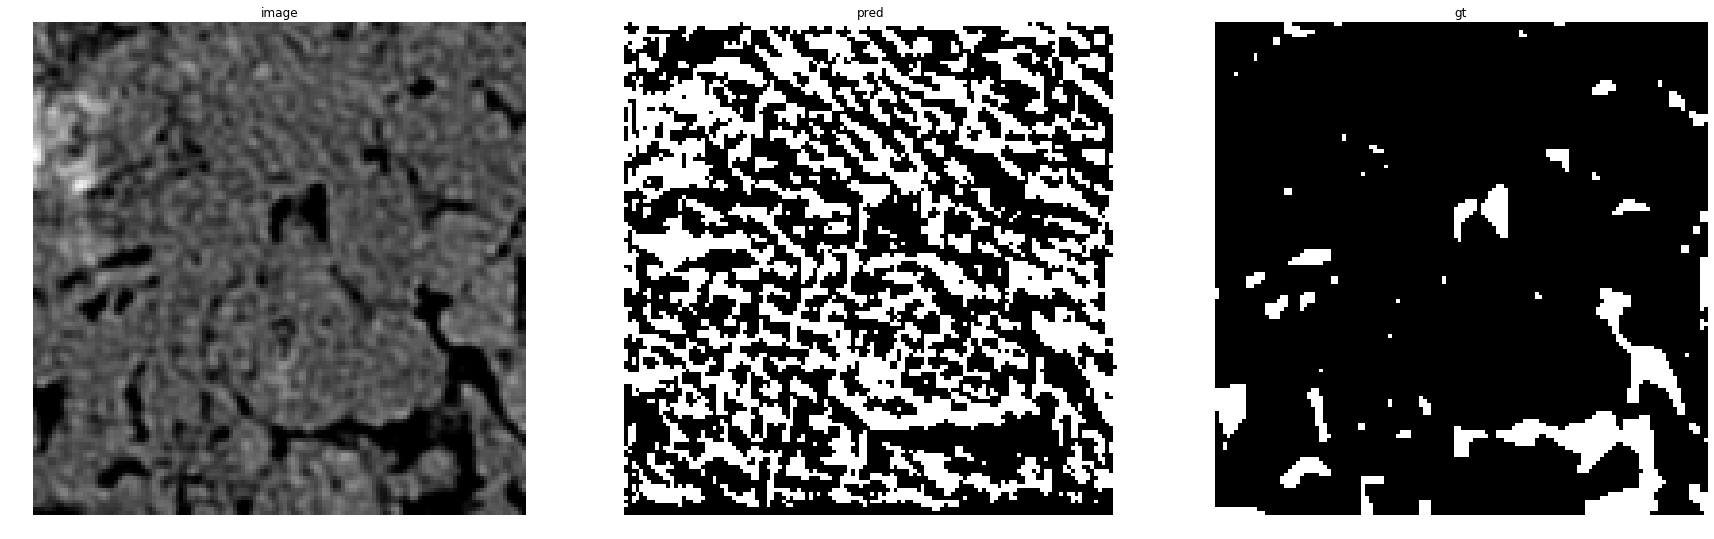

accuracy    : 0.5009765625
precision   : 0.030227743271221533
recall      : 0.15997078159240322
f1          : 0.05084745762711864
pr_auc      : 0.05511440688605703
iou         : 0.02608695652173913


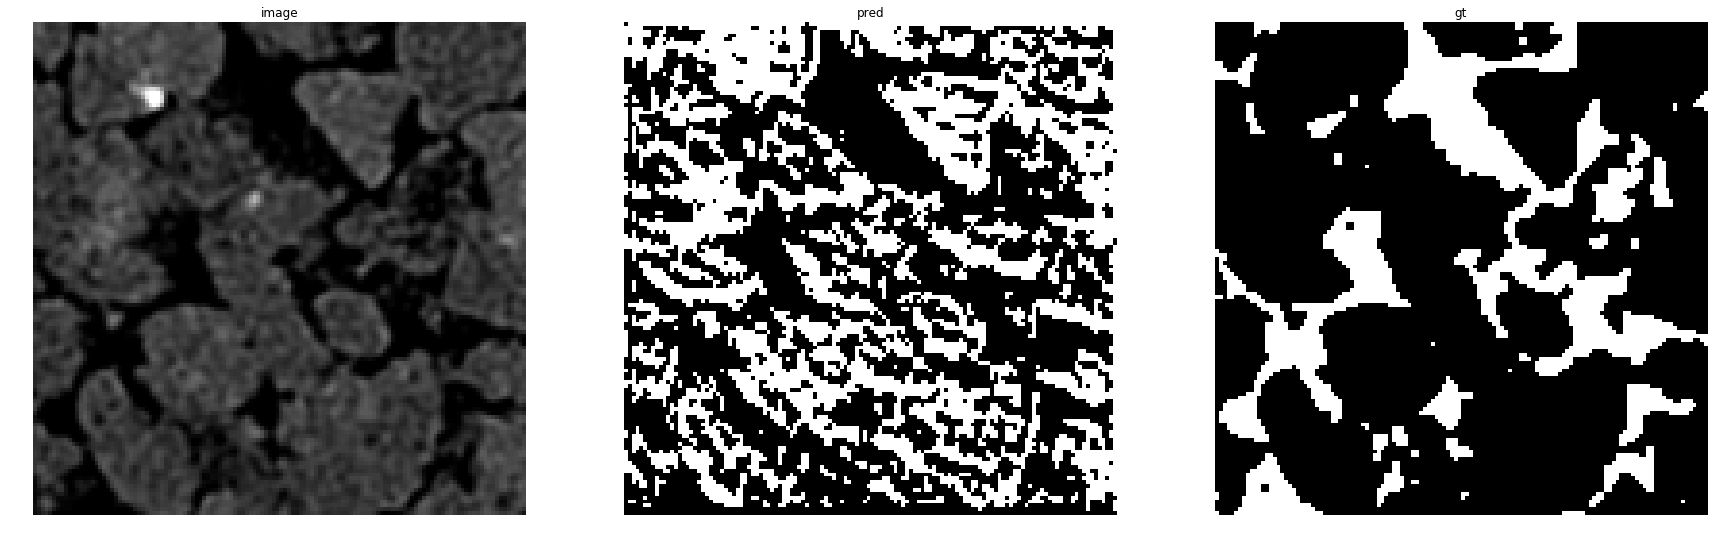

accuracy    : 0.4217529296875
precision   : 0.06940200785683108
recall      : 0.1341772151898734
f1          : 0.09148446490218641
pr_auc      : 0.13338372871995924
iou         : 0.047934880916490806


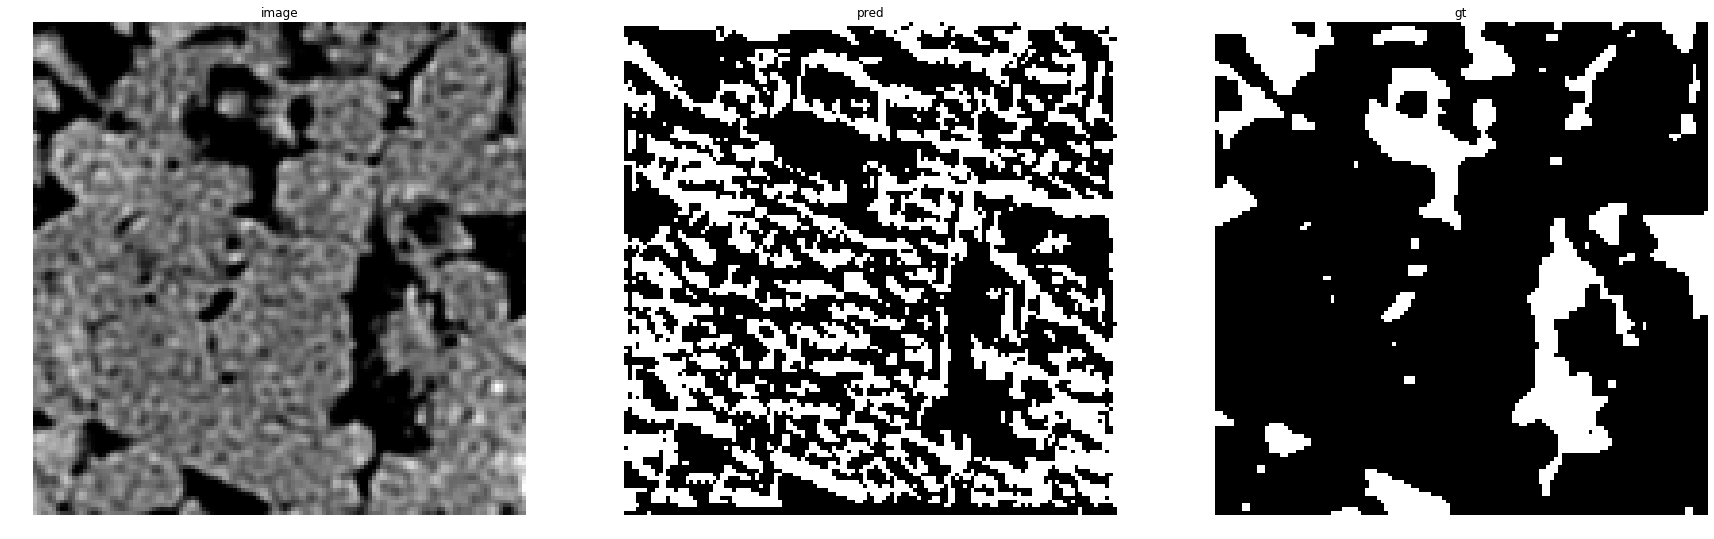

accuracy    : 0.46429443359375
precision   : 0.06430819967021437
recall      : 0.14473684210526316
f1          : 0.08905033731188376
pr_auc      : 0.12437343192658117
iou         : 0.04660004344992396


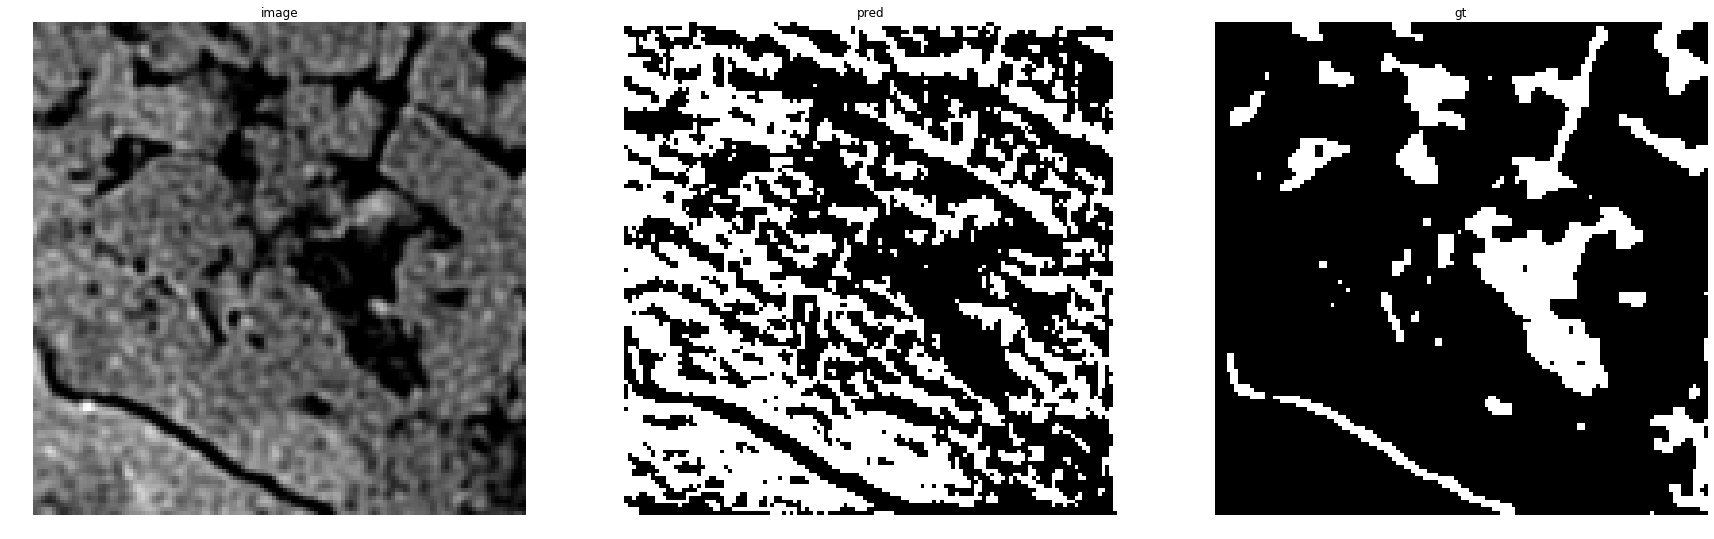

accuracy    : 0.41412353515625
precision   : 0.0458182756840475
recall      : 0.13861772745021475
f1          : 0.06887185954020758
pr_auc      : 0.09516731912490686
iou         : 0.035664054651396424


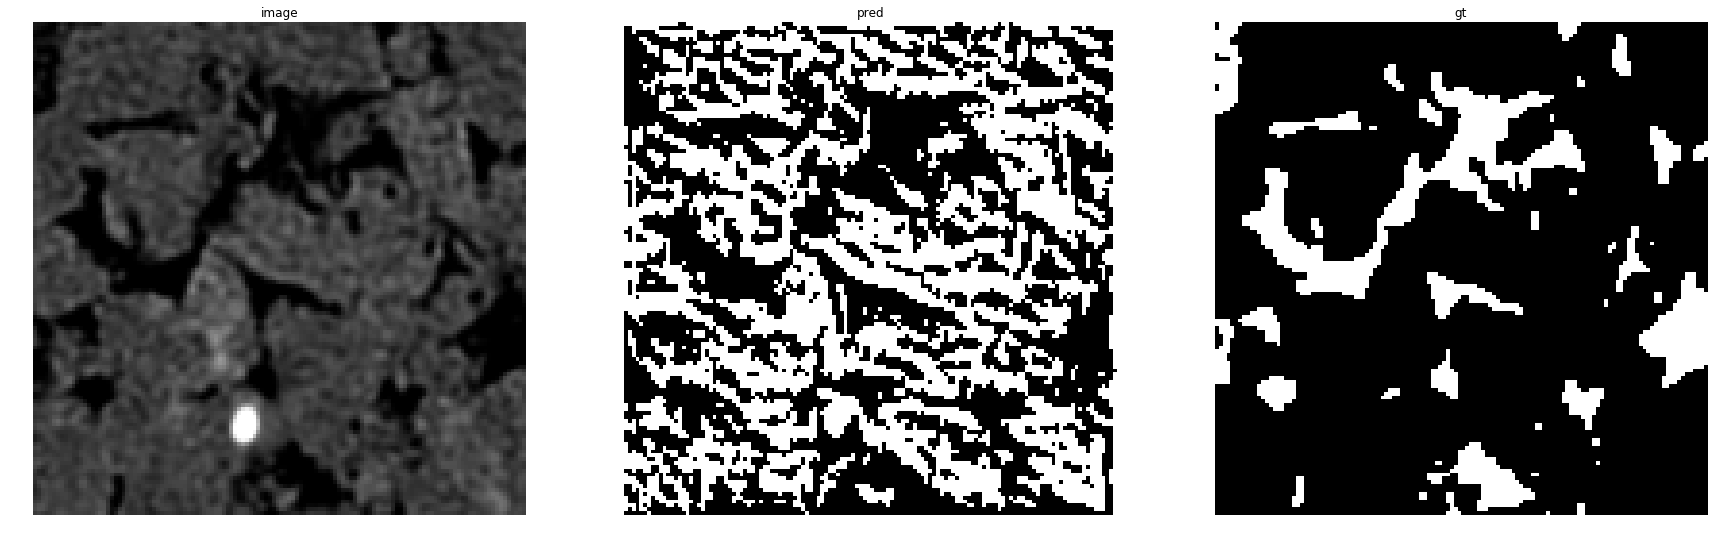

accuracy    : 0.42156982421875
precision   : 0.051484891713137075
recall      : 0.155078125
f1          : 0.07730503358971863
pr_auc      : 0.09714337611551169
iou         : 0.040206603200324084


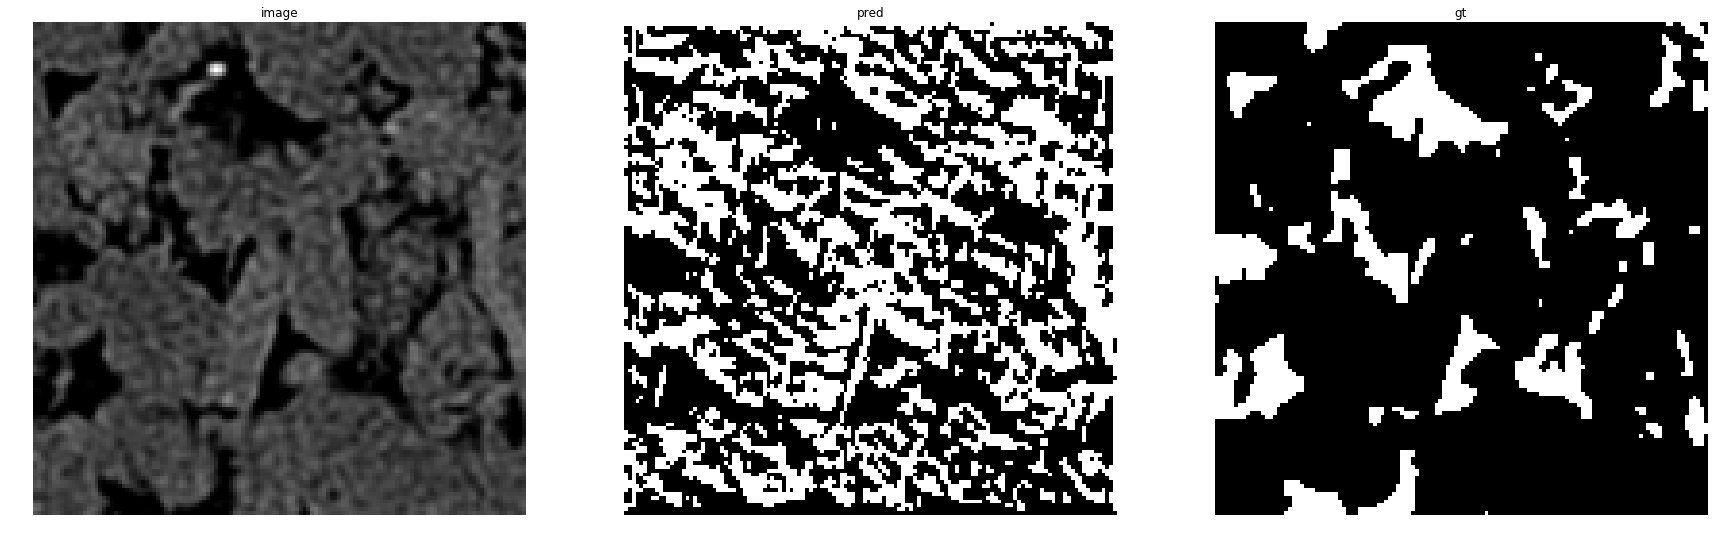

accuracy    : 0.46710205078125
precision   : 0.06218130311614731
recall      : 0.17222440172616713
f1          : 0.09137267145384535
pr_auc      : 0.10239224637549027
iou         : 0.04787350054525627


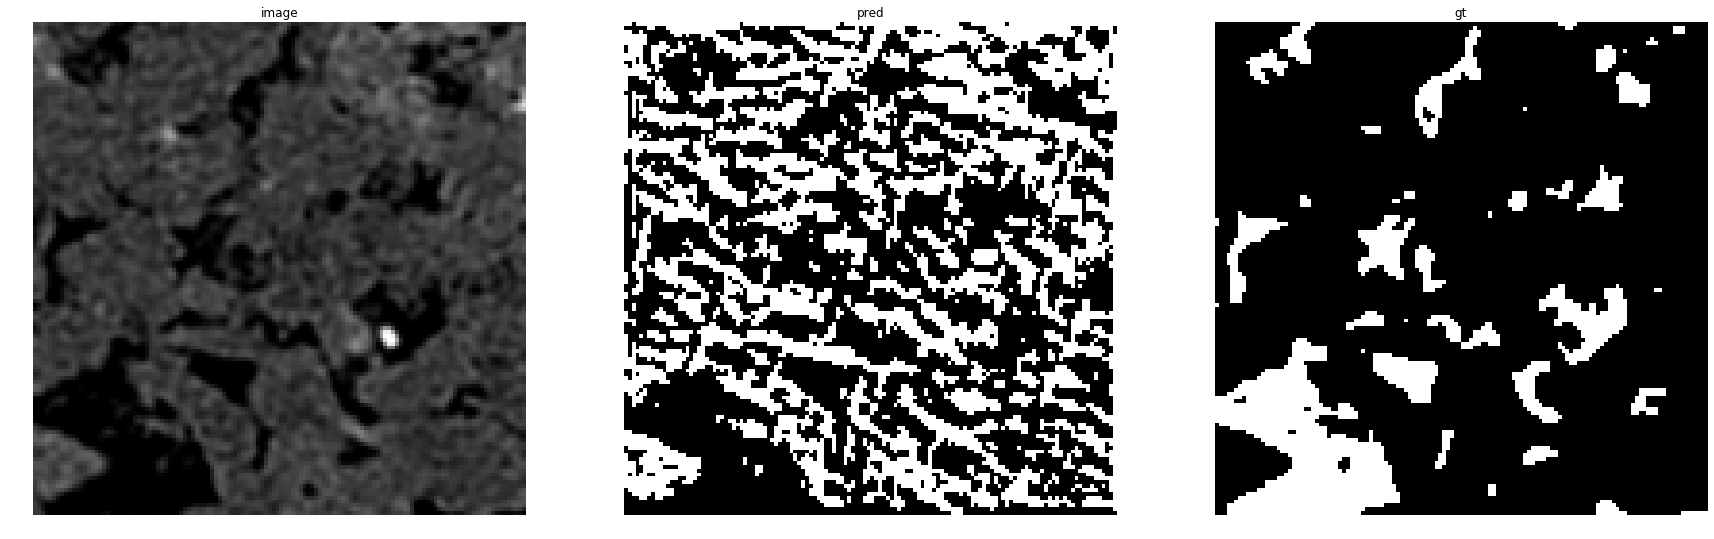

accuracy    : 0.459228515625
precision   : 0.04759166067577283
recall      : 0.12894429294896767
f1          : 0.06952320940978786
pr_auc      : 0.09267540301745712
iou         : 0.03601349145903601


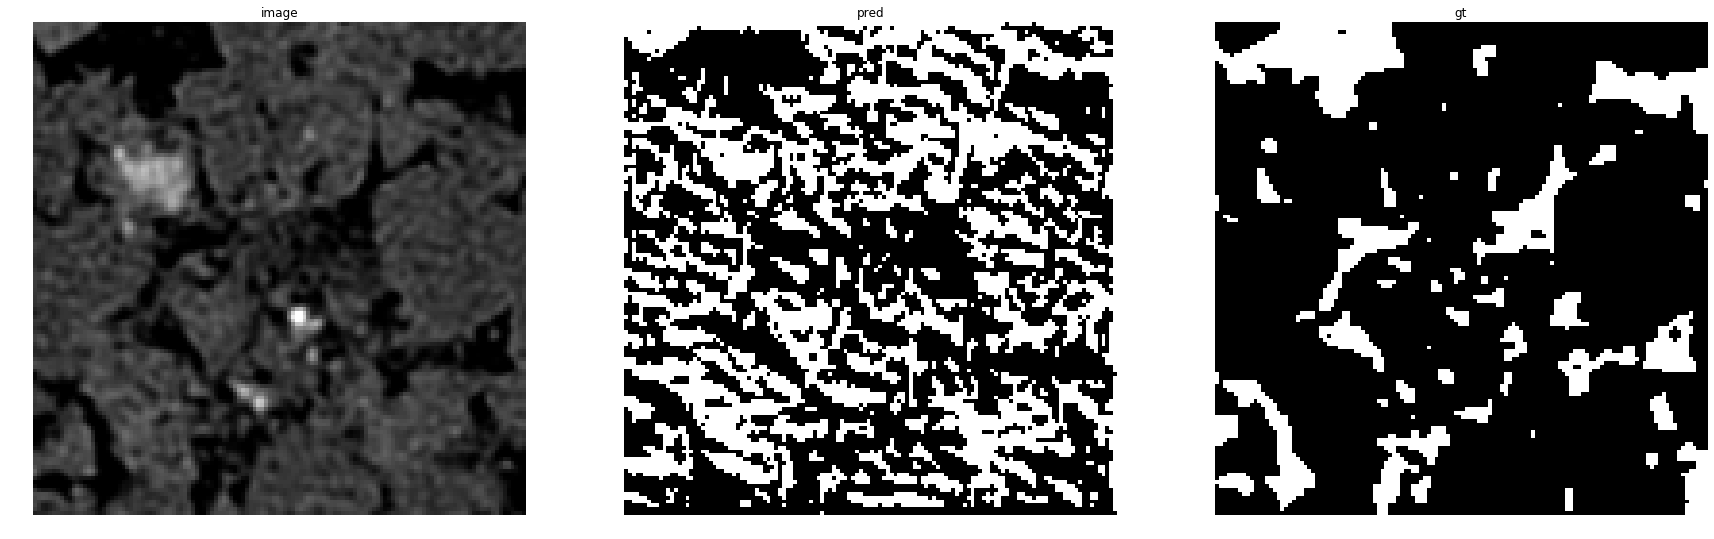

accuracy    : 0.46966552734375
precision   : 0.0703894195444526
recall      : 0.1685432793807178
f1          : 0.09930548357002177
pr_auc      : 0.11446818682158516
iou         : 0.05224694589877836


In [21]:
for stack_name, dataloader_test in dataloaders_test.items():
    cnt = to_plot
    
    stack_name = os.path.split(stack_name)[-1]
    dir_path = os.path.join(os.path.abspath('.'), 'samples', stack_name)
    if stack_name not in os.listdir(os.path.join('.', 'samples')):
        os.mkdir(dir_path)
    print(stack_name)
    for samples, masks in dataloader_test:

        preds = model(torch.from_numpy(samples).to(device)).cpu().data.numpy()

        for sample, mask, pred in list(zip(samples, masks, preds))[:cnt]:
            img_path = os.path.join('.', 'samples', stack_name, '{}.png'.format(cnt))
            plot_sample(sample[0], mask, pred, threshold, metrics, fig_path=None)
            cnt -= 1
            
        if cnt == 0:
            break

## Make prediction for particular stack

In [13]:
stack_name = 'SPE_carb10_58_box3'

In [14]:
stack = Stack.read_from_source('../../data/{}'.format(stack_name))

509it [00:01, 356.99it/s]
100%|██████████| 509/509 [00:02<00:00, 193.34it/s]


In [15]:
device

'cuda:1'

In [16]:
train_conf['device'] = device

In [17]:
predicted_stack_1 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 128, 1), 
    bs=32, num_workers=8, device=device,
    threshold=None)

8144it [00:00, 96772.07it/s]
8144it [00:42, 193.84it/s]
100%|██████████| 8144/8144 [00:02<00:00, 3523.96it/s]


In [18]:
predicted_stack_2 = stack.apply(
    model, 
    model_config,
    patch_sizes=(1, 128, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

8144it [00:00, 232724.78it/s]
8144it [00:43, 187.12it/s]
100%|██████████| 8144/8144 [00:00<00:00, 10765.48it/s]


In [19]:
predicted_stack_3 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 1, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

8144it [00:00, 227525.56it/s]
8144it [00:42, 190.02it/s]
100%|██████████| 8144/8144 [00:00<00:00, 12448.26it/s]


In [24]:
predicted_stack_1.targets

array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]],

       ...,

       [[255., 255., 255

In [25]:
predicted_stack_1.preds

array([[[0.52430534, 0.5243301 , 0.524338  , ..., 0.52419347,
         0.5241808 , 0.52418953],
        [0.52482986, 0.52484643, 0.5248522 , ..., 0.5248897 ,
         0.52491874, 0.52493036],
        [0.52335435, 0.5233313 , 0.52332336, ..., 0.52330303,
         0.5232037 , 0.5232384 ],
        ...,
        [0.52538365, 0.52495605, 0.5246989 , ..., 0.5256948 ,
         0.52539194, 0.5255278 ],
        [0.52434987, 0.5244866 , 0.5243581 , ..., 0.5240314 ,
         0.5240464 , 0.5238679 ],
        [0.52393633, 0.5238088 , 0.524119  , ..., 0.5236047 ,
         0.52362984, 0.5236929 ]],

       [[0.52038413, 0.52042633, 0.52046156, ..., 0.52016526,
         0.5201909 , 0.52021617],
        [0.5212877 , 0.521296  , 0.5213533 , ..., 0.521505  ,
         0.521863  , 0.5221822 ],
        [0.5214468 , 0.52143234, 0.5214336 , ..., 0.5222507 ,
         0.5224388 , 0.5225486 ],
        ...,
        [0.5252559 , 0.5252917 , 0.52543586, ..., 0.5254271 ,
         0.525024  , 0.5246574 ],
        [0.5

In [20]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_1.preds, 
    mode='stack',
    threshold=0.5)

0.09293589023963492

In [21]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_2.preds, 
    mode='stack',
    threshold=0.5)

0.09293589023963492

In [22]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_3.preds, 
    mode='stack',
    threshold=0.5)

0.09293589023963492

In [23]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    (predicted_stack_1.preds + predicted_stack_2.preds + predicted_stack_3.preds) / 3, 
    mode='stack',
    threshold=0.5)

0.09293589023963492

In [39]:
for k, v in metrics.items():
    print('{:12}: {:.6f}'.format(k, 
                                 v(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
                                    predicted_stack_1.preds, 
                                    mode='stack')))

accuracy    : 0.981631
precision   : 0.919325
recall      : 0.919377
f1          : 0.919351
pr_auc      : 0.980822
iou         : 0.850740


In [ ]:
for ps, d in zip([(128, 128, 1), (128, 1, 128), (1, 128, 128)], ['z', 'y', 'x']):
    predicted_stack = stack.apply(
        model, 
        patch_sizes=ps, 
        bs=32, num_workers=8, device='cuda:0',
        threshold=None)
    predicted_stack.dump('./{}_{}'.format(stack_name, d), features=False, targets=True, preds=True)

## Validate dependence between metrics and distance to patch center

In [21]:
from visualization_utils import output_to_binary

In [25]:
import torch

In [36]:
import pandas as pd

In [62]:
df_agg = None

for i, (img, gt) in tqdm(enumerate(dataloaders_test['../../data/carbRNF'])):
    pred = model(torch.from_numpy(img)).cpu().data.numpy()
    binary = output_to_binary(pred, threshold=0.5, mode='batch')
    
    h, w = binary.shape[1:]
    x = np.arange(h).reshape(-1, 1)
    x = x.repeat(w, axis=1)
    y = np.arange(w).reshape(1, -1)
    y = y.repeat(h, axis=0)
    r = np.sqrt(np.square(x - (h - 1) / 2) + np.square(y - (w - 1) / 2))
    r = r.reshape(1, *r.shape).repeat(binary.shape[0], axis=0).flatten()
    tp = ((binary == 1) & (gt == 1)).astype(np.float32).flatten()
    fp = ((binary == 1) & (gt == 0)).astype(np.float32).flatten()
    fn = ((binary == 0) & (gt == 1)).astype(np.float32).flatten()
    
    df = pd.DataFrame(data={'r': r, 'tp': tp, 'fp': fp, 'fn': fn})
    df['r'] = df['r'].astype('int')
    df['count'] = 1
    if df_agg is None:
        df_agg = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        
        portion = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        df_agg = df_agg + portion
    
#     if i > 20:
#         break



0it [00:00, ?it/s]

1it [00:02,  2.39s/it]

2it [00:04,  2.30s/it]

3it [00:06,  2.14s/it]

4it [00:08,  2.04s/it]

5it [00:10,  2.03s/it]

6it [00:12,  2.03s/it]

7it [00:13,  1.95s/it]

8it [00:15,  1.91s/it]

9it [00:17,  1.93s/it]

10it [00:19,  1.87s/it]

11it [00:21,  1.84s/it]

12it [00:22,  1.81s/it]

13it [00:24,  1.80s/it]

14it [00:26,  1.78s/it]

15it [00:28,  1.77s/it]

16it [00:29,  1.77s/it]

17it [00:31,  1.77s/it]

18it [00:33,  1.76s/it]

19it [00:35,  1.76s/it]

20it [00:36,  1.75s/it]

21it [00:38,  1.76s/it]

22it [00:40,  1.76s/it]

23it [00:42,  1.76s/it]

24it [00:43,  1.77s/it]

25it [00:45,  1.80s/it]

26it [00:47,  1.78s/it]

27it [00:49,  1.77s/it]

28it [00:51,  1.77s/it]

29it [00:52,  1.77s/it]

30it [00:54,  1.76s/it]

31it [00:56,  1.76s/it]

32it [00:58,  1.76s/it]

33it [00:59,  1.76s/it]

34it [01:01,  1.76s/it]

35it [01:03,  1.75s/it]

36it [01:05,  1.76s/it]

37it [01:06,  1.76s/it]

38it [01:08,  1.76s/it]

39it [01:10,  1.76s/it]

40it [01:12,

In [63]:
df_agg

count      tp     fp     fn
r                              
0     256    20.0    4.0    0.0
1     512    44.0   12.0    0.0
2    1280   130.0   16.0    6.0
3    1280   124.0    4.0   14.0
4    1792   154.0    6.0    8.0
5    2048   156.0   30.0   20.0
6    2816   220.0   22.0   34.0
7    3328   330.0   24.0   38.0
8    3072   324.0   24.0   28.0
9    3840   336.0   22.0   38.0
10   4352   430.0   34.0   36.0
11   4096   456.0   62.0   42.0
12   5888   678.0   38.0   54.0
13   4864   540.0   46.0   54.0
14   6400   632.0   54.0   40.0
15   6144   544.0   56.0   50.0
16   6400   594.0   56.0   68.0
17   6912   700.0   72.0   60.0
18   6656   702.0   78.0   40.0
19   8960   912.0   68.0   82.0
20   8448   924.0   70.0   60.0
21   8448   942.0   74.0   90.0
22   8704   932.0   76.0  102.0
23   8960   912.0   88.0   86.0
24  11008  1068.0  110.0   88.0
25   9728   924.0   84.0   98.0
26  10496  1048.0  114.0  122.0
27  11520  1142.0  126.0  100.0
28  11008  1070.0  110.0   82.0
29  11776  1062.0  114.0   78.0
..    ...     ...    ...    ...
60  24320  2366.0  180.0  178.0
61  26368  2554.0  190.0  196.0
62  25344  2414.0  166.0  274.0
63  25600  2440.0  152.0  232.0
64  19712  1902.0  150.0  222.0
65  20224  2022.0  138.0  200.0
66  17408  1678.0  138.0  194.0
67  16128  1538.0  126.0  192.0
68  14592  1438.0  116.0  166.0
69  12288  1254.0  104.0  132.0
70  14592  1588.0  110.0  162.0
71  11008  1142.0   94.0  160.0
72  11520  1368.0   82.0  134.0
73  10240  1200.0   86.0  132.0
74   8960   994.0   54.0  112.0
75   9472  1044.0   66.0   96.0
76   7168   770.0   36.0   80.0
77   7936   846.0   48.0  102.0
78   6400   666.0   44.0   66.0
79   6400   680.0   40.0   86.0
80   5632   584.0   42.0   84.0
81   3840   364.0   30.0   46.0
82   5376   518.0   26.0   64.0
83   3072   346.0   10.0   52.0
84   4352   484.0   28.0   42.0
85   1792   186.0    6.0   16.0
86   2304   192.0   10.0   22.0
87   1536   140.0    4.0   16.0
88    768    84.0    2.0    4.0
89    768    76.0    6.0   14.0

[90 rows x 4 columns]

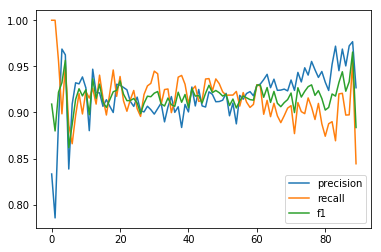

In [65]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision, label='precision')
plt.plot(df_agg.index, recall, label='recall')
plt.plot(df_agg.index, 2 * precision * recall / (precision + recall), label='f1')
plt.legend(loc='best')
plt.show()

In [76]:
(2 * precision * recall / (precision + recall)).mean()

0.9169255

In [74]:
np.mean(results['test_metrics']['../../data/carb96558']['f1'])

0.9757604510306116

In [75]:
np.mean(results['test_metrics']['../../data/carbRNF']['f1'])

0.9172696807633565

In [77]:
np.mean(results['test_metrics']['../../data/carbRNF']['iou'])

0.8471886630965806

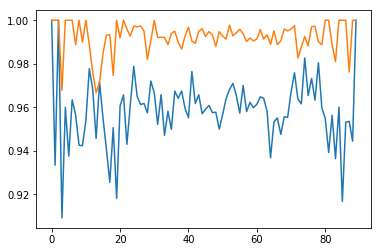

In [60]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision)
plt.plot(df_agg.index, recall)
plt.show()